In [3]:
import torch
from torch.autograd import Variable
from torch.nn.functional import normalize
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.sparse.csgraph import minimum_spanning_tree


from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
from matplotlib import gridspec

from time import time

In [4]:
def angle_analysis(W):
    with torch.no_grad():
        m = W.shape[0]
        WWT = W @ torch.t(W)
        norm2 = torch.diagonal(WWT, 0)
        N = (torch.sqrt(norm2[:, None] @ norm2[None, :]).detach() + 1e-8)*1.001  
        WWTN = WWT/N

        M = torch.logical_not(torch.eye(m))
        sp = torch.amax(WWTN[M].view(m, -1), dim=1)

        theta = torch.arccos(sp)
        mean = torch.mean(theta)
        Max = torch.amax(theta)
        Min = torch.amin(theta)

    return mean, Min, Max

In [5]:
def SV(n):
    q = n//2
    r = n%2
    if r == 1:
        sv = 3.1416
        for i in range(1, q+1):
            sv *= (2*i+1)/(2*i)
    else:
        sv = 2
        for i in range(1, q+1):
            sv *= 2*i/(2*i-1)
    return sv


def h(n):
    h = np.sqrt((n+1)/(2*n))
    return h


def LU(m, n):
    l = np.power((n+1)*SV(n)/(2*m), 1/n)
    u = l/h(n)
    return l, u

# 12/20 polyhedron

In [6]:
np.pi/2*63.4/90

1.106538745764405

In [7]:
LU(12, 3)

(0.9226357934955026, 1.1299934562459262)

In [8]:
np.pi/2*41.8/90

0.7295476273336298

In [9]:
LU(20, 3)

(0.7781811664107061, 0.953073392575037)

In [10]:
W1 = torch.randn(12, 3).cuda()
W1 /= torch.norm(W1, dim=1, keepdim=True)
W2 = torch.randn(20, 3).cuda()
W2 /= torch.norm(W2, dim=1, keepdim=True)
W1.requires_grad_()
W2.requires_grad_()
print()

# Angle learning

## angle normalizaing

In [16]:
def t_loss(W, theta):
    m = W.shape[0]
    W = torch.nn.Parameter(W)
    WWT = W @ torch.t(W)
    norm2 = torch.diagonal(WWT, 0)
    N = (torch.sqrt(norm2[:, None] @ norm2[None, :])+ 1e-8)*1.001 
    WWTN = WWT/N        
    if theta == 1.5708:
        M = torch.logical_not(torch.eye(m, dtype=bool).cuda())
        tloss = torch.sum(((torch.arccos(WWTN[M]) - theta))**2)
    else:
        Z = torch.logical_not(torch.eye(m, dtype=bool).cuda())
        M1 = (WWTN > np.cos(theta))*Z #  * (WWT > -0.99)
#         M2 = (WWTN < -np.cos(theta))*Z

        tloss = torch.sum((torch.arccos(WWTN[M1]) - theta)**2) 
#             torch.sum((torch.arccos(WWTN[M2]) - 3.1416 + theta)**2)  
    tloss.backward()
    return W.grad

def n_loss(W):
    m = W.shape[0]
    WWT = W @ torch.t(W)
    norm2 = torch.diagonal(WWT, 0)
    nloss = torch.sum((1 - norm2)**2)
    return nloss

In [17]:
w1 = copy.deepcopy(W1)

lambd1 = 0.1
lambd2 = 0.01

Norm = torch.norm(w1, dim=1)
for i in range(200):
    nloss = n_loss(w1)
    n_grad = torch.autograd.grad(nloss, w1)[0]
    with torch.no_grad():
        w1 -= lambd1*n_grad
    t_grad = t_loss(w1, theta=1.5)    
    with torch.no_grad():
        w1 -= lambd2*t_grad*torch.norm(w1, dim=[1], keepdim=True)**2
    with torch.no_grad():
        Norm = torch.norm(w1, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(w1)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')

1.00, 0.63, 0.31, 1.02
1.00, 0.68, 0.38, 1.04
1.00, 0.72, 0.44, 1.06
1.00, 0.75, 0.49, 1.08
1.00, 0.78, 0.53, 1.09
1.00, 0.80, 0.57, 1.10
1.00, 0.82, 0.60, 1.11
1.00, 0.83, 0.63, 1.11
1.00, 0.84, 0.66, 1.10
1.00, 0.85, 0.69, 1.09
1.00, 0.86, 0.71, 1.08
1.00, 0.87, 0.73, 1.07
1.00, 0.87, 0.73, 1.06
1.00, 0.88, 0.74, 1.05
1.00, 0.88, 0.75, 1.04
1.00, 0.88, 0.75, 1.05
1.00, 0.89, 0.75, 1.05
1.00, 0.89, 0.75, 1.05
1.00, 0.89, 0.75, 1.05
1.00, 0.90, 0.75, 1.05
1.00, 0.90, 0.76, 1.05
1.00, 0.90, 0.76, 1.06
1.00, 0.90, 0.76, 1.06
1.00, 0.91, 0.76, 1.05
1.00, 0.91, 0.77, 1.05
1.00, 0.91, 0.77, 1.05
1.00, 0.91, 0.77, 1.05
1.00, 0.91, 0.77, 1.05
1.00, 0.92, 0.78, 1.05
1.00, 0.92, 0.78, 1.05
1.00, 0.92, 0.78, 1.05
1.00, 0.92, 0.78, 1.05
1.00, 0.92, 0.79, 1.05
1.00, 0.92, 0.79, 1.05
1.00, 0.92, 0.79, 1.05
1.00, 0.92, 0.79, 1.05
1.00, 0.92, 0.80, 1.06
1.00, 0.92, 0.80, 1.06
1.00, 0.93, 0.80, 1.06
1.00, 0.93, 0.80, 1.06
1.00, 0.93, 0.80, 1.06
1.00, 0.93, 0.80, 1.06
1.00, 0.93, 0.81, 1.06
1.00, 0.93,

In [18]:
w2 = copy.deepcopy(W2)

lambd1 = 0.1
lambd2 = 0.01

Norm = torch.norm(w2, dim=1)
for i in range(1000):
    nloss = n_loss(w2)
    n_grad = torch.autograd.grad(nloss, w2)[0]
    with torch.no_grad():
        w2 -= lambd1*n_grad
    t_grad = t_loss(w2, theta=0.73)    
    with torch.no_grad():
        w2 -= lambd2*t_grad*torch.norm(w2, dim=[1], keepdim=True)**2
    with torch.no_grad():
        Norm = torch.norm(w2, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(w2)
#     print(np.arccos((w2[2]@torch.t(w2[-2])/torch.norm(w2[2])/torch.norm(w2[-2])).item())*180/np.pi)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')

1.00, 0.47, 0.11, 0.90
1.00, 0.49, 0.16, 0.89
1.00, 0.50, 0.20, 0.88
1.00, 0.51, 0.23, 0.87
1.00, 0.52, 0.27, 0.87
1.00, 0.54, 0.30, 0.87
1.00, 0.55, 0.33, 0.87
1.00, 0.56, 0.36, 0.87
1.00, 0.56, 0.39, 0.87
1.00, 0.57, 0.41, 0.87
1.00, 0.58, 0.43, 0.87
1.00, 0.59, 0.44, 0.87
1.00, 0.59, 0.45, 0.87
1.00, 0.60, 0.46, 0.87
1.00, 0.61, 0.48, 0.87
1.00, 0.61, 0.48, 0.87
1.00, 0.62, 0.49, 0.87
1.00, 0.62, 0.50, 0.87
1.00, 0.63, 0.51, 0.87
1.00, 0.63, 0.52, 0.87
1.00, 0.64, 0.53, 0.87
1.00, 0.64, 0.53, 0.87
1.00, 0.65, 0.54, 0.87
1.00, 0.65, 0.55, 0.87
1.00, 0.65, 0.55, 0.87
1.00, 0.65, 0.56, 0.87
1.00, 0.66, 0.56, 0.87
1.00, 0.66, 0.57, 0.87
1.00, 0.66, 0.58, 0.87
1.00, 0.67, 0.58, 0.87
1.00, 0.67, 0.59, 0.87
1.00, 0.67, 0.59, 0.87
1.00, 0.67, 0.59, 0.87
1.00, 0.67, 0.60, 0.87
1.00, 0.68, 0.60, 0.87
1.00, 0.68, 0.61, 0.87
1.00, 0.68, 0.61, 0.87
1.00, 0.68, 0.61, 0.87
1.00, 0.68, 0.62, 0.87
1.00, 0.69, 0.62, 0.87
1.00, 0.69, 0.63, 0.87
1.00, 0.69, 0.63, 0.87
1.00, 0.69, 0.63, 0.87
1.00, 0.69,

1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73, 0.72, 0.81
1.00, 0.73,

1.00, 0.73, 0.73, 0.81
1.00, 0.74, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.74, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.74, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.74, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.74, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.74, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.74, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.74, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.74, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.74, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.73, 0.73, 0.81
1.00, 0.74,

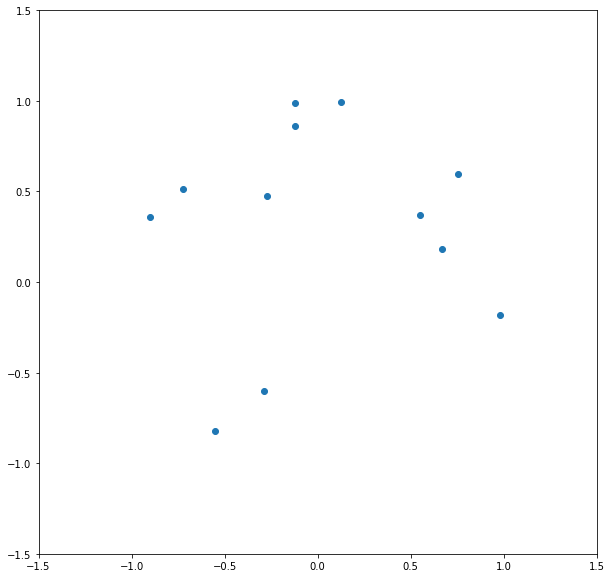

In [19]:
pcloud = W1.detach().cpu().numpy()
fig, axs = plt.subplots(ncols=1, figsize=(10, 10))
axs.set_xlim(-1.5, 1.5)
axs.set_ylim(-1.5, 1.5)
axs.scatter(pcloud[:, 0], pcloud[:, 1])
plt.show()

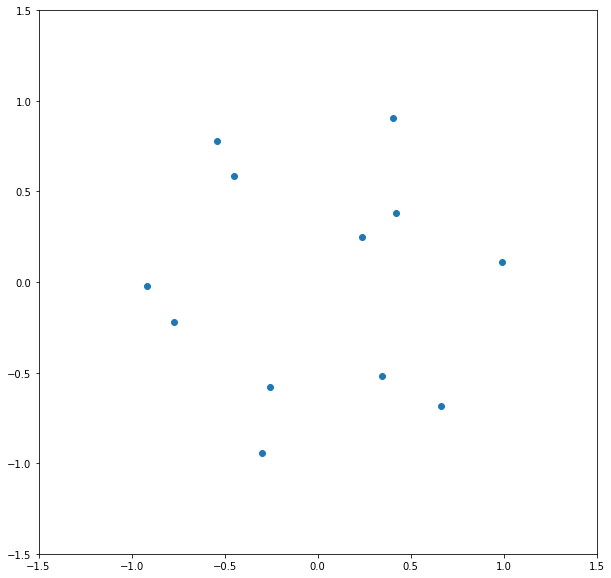

In [20]:
pcloud = w1.detach().cpu().numpy()
fig, axs = plt.subplots(ncols=1, figsize=(10, 10))
axs.set_xlim(-1.5, 1.5)
axs.set_ylim(-1.5, 1.5)
axs.scatter(pcloud[:, 0], pcloud[:, 1])
plt.show()

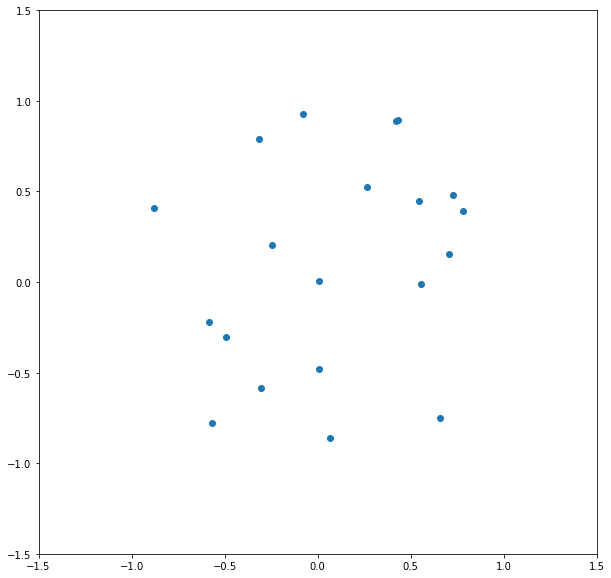

In [21]:
pcloud = W2.detach().cpu().numpy()
fig, axs = plt.subplots(ncols=1, figsize=(10, 10))
axs.set_xlim(-1.5, 1.5)
axs.set_ylim(-1.5, 1.5)
axs.scatter(pcloud[:, 0], pcloud[:, 1])
plt.show()

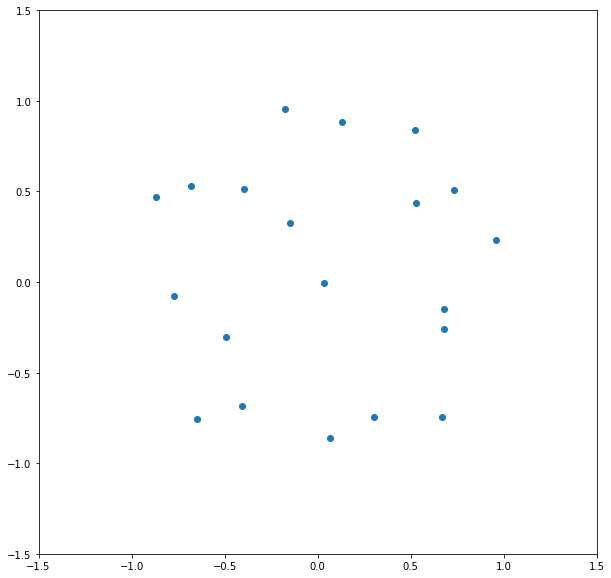

In [22]:
pcloud = w2.detach().cpu().numpy()
fig, axs = plt.subplots(ncols=1, figsize=(10, 10))
axs.set_xlim(-1.5, 1.5)
axs.set_ylim(-1.5, 1.5)
axs.scatter(pcloud[:, 0], pcloud[:, 1])
plt.show()

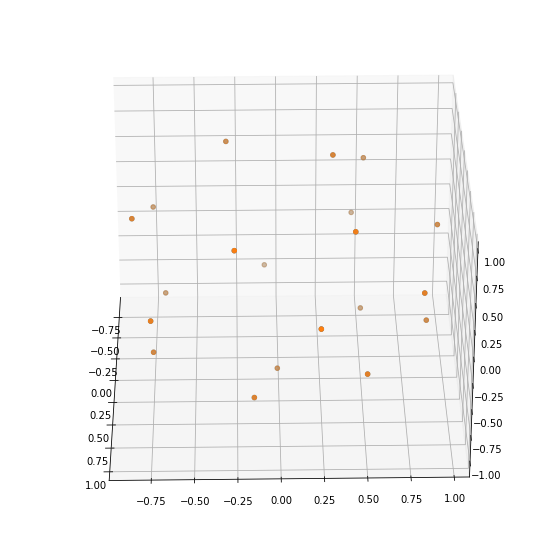

In [23]:
pcloud = w2.detach().cpu().numpy()
fig, axs = plt.subplots(ncols=1, figsize=(10, 10), subplot_kw={"projection":"3d"})

def init():
    axs.scatter(pcloud[:, 0], pcloud[:, 1], pcloud[:, 2])
    return fig,

def animate(i):
    axs.view_init(elev=30., azim=i)
    return fig,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=360, interval=20, blit=True)
anim.save('mpl3d_scatter20.gif', fps=30)

## adk

In [124]:
def ad_function(W, theta, target_norm=1):
    m = W.shape[0]
    WWT = W @ torch.t(W)
    norm2 = torch.diagonal(WWT, 0)
    with torch.no_grad():
        N = (torch.sqrt(norm2[:, None] @ norm2[None, :]) + 1e-8)*1.001
    WWTN = WWT/N
    if theta == 1.5708:
        M = torch.logical_not(torch.eye(m, dtype=bool)).cuda()
        tloss = torch.sum((torch.arccos(WWTN[M]) - theta)**2)
    else:
        Z = torch.logical_not(torch.eye(m, dtype=bool)).cuda()
        M1 = (WWTN > np.cos(theta))*Z
#         M2 = (WWTN < -np.cos(theta))*Z
        tloss = torch.sum(((torch.arccos(WWTN[M1]) - theta))**2) 
#             torch.sum((torch.arccos(WWTN[M2]) - 3.1416 + theta)**2)
    
    nloss = torch.sum((target_norm**2 - norm2)**2)
    return nloss, tloss


def ADK(weight, theta, double=False):
    m = weight.shape[0]
    W = weight.view(m, -1)
    n = W.shape[1]

    if double:
        nloss, tloss = ad_function(W, theta, target_norm=1)
        n2, t2 = ad_function(torch.t(W), theta, target_norm=m/n)
        nloss += n2
        tloss += t2       
    else: 
        nloss, tloss = ad_function(W, theta, target_norm=1)
    return nloss, tloss 

In [125]:
lamd1 = 0.1
lamd2 = 0.01
w1 = copy.deepcopy(W1)
W = torch.nn.Parameter(w1)
opt = optim.SGD([W], lr=1)
for i in range(1000):
    nloss, tloss = ADK(W, theta=1.1)
    loss = lamd1*nloss + lamd2*tloss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')

0.93, 0.66, 0.43, 1.12
0.92, 0.71, 0.51, 1.11
0.93, 0.75, 0.58, 1.08
0.95, 0.79, 0.64, 1.07
0.96, 0.82, 0.69, 1.05
0.97, 0.85, 0.73, 1.04
0.98, 0.87, 0.77, 1.03
0.98, 0.89, 0.80, 1.03
0.98, 0.91, 0.82, 1.02
0.99, 0.92, 0.85, 1.02
0.99, 0.94, 0.87, 1.02
0.99, 0.95, 0.89, 1.02
0.99, 0.96, 0.90, 1.02
0.99, 0.97, 0.92, 1.03
0.99, 0.98, 0.93, 1.04
0.99, 0.99, 0.94, 1.05
0.99, 1.00, 0.96, 1.05
0.99, 1.00, 0.97, 1.06
1.00, 1.01, 0.97, 1.07
1.00, 1.02, 0.98, 1.07
1.00, 1.02, 0.99, 1.08
1.00, 1.03, 1.00, 1.08
1.00, 1.03, 1.00, 1.08
1.00, 1.04, 1.01, 1.09
1.00, 1.04, 1.01, 1.09
1.00, 1.04, 1.02, 1.09
1.00, 1.05, 1.02, 1.10
1.00, 1.05, 1.03, 1.10
1.00, 1.05, 1.03, 1.10
1.00, 1.06, 1.04, 1.10
1.00, 1.06, 1.04, 1.10
1.00, 1.06, 1.04, 1.10
1.00, 1.06, 1.05, 1.10
1.00, 1.06, 1.05, 1.10
1.00, 1.07, 1.05, 1.10
1.00, 1.07, 1.05, 1.10
1.00, 1.07, 1.06, 1.10
1.00, 1.07, 1.06, 1.10
1.00, 1.07, 1.06, 1.11
1.00, 1.07, 1.06, 1.11
1.00, 1.08, 1.06, 1.11
1.00, 1.08, 1.07, 1.11
1.00, 1.08, 1.07, 1.11
1.00, 1.08,

1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.11
1.00, 1.10,

1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.11
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.12
1.00, 1.10, 1.10, 1.11
1.00, 1.10,

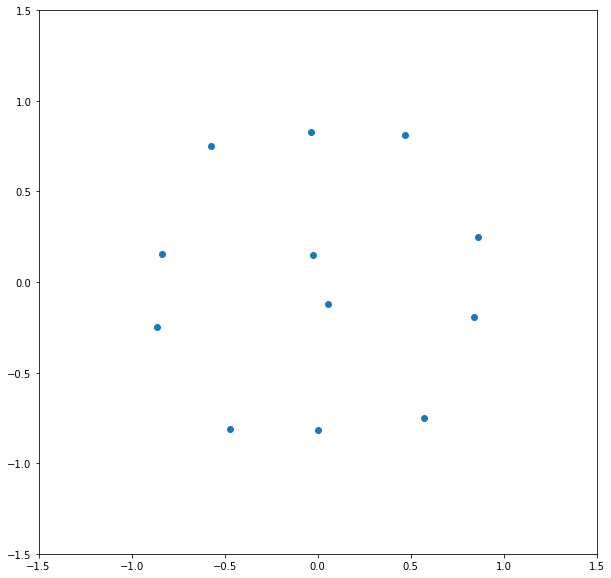

In [26]:
pcloud = W.detach().cpu().numpy()
fig, axs = plt.subplots(ncols=1, figsize=(10, 10))
axs.set_xlim(-1.5, 1.5)
axs.set_ylim(-1.5, 1.5)
axs.scatter(pcloud[:, 0], pcloud[:, 1])
plt.show()

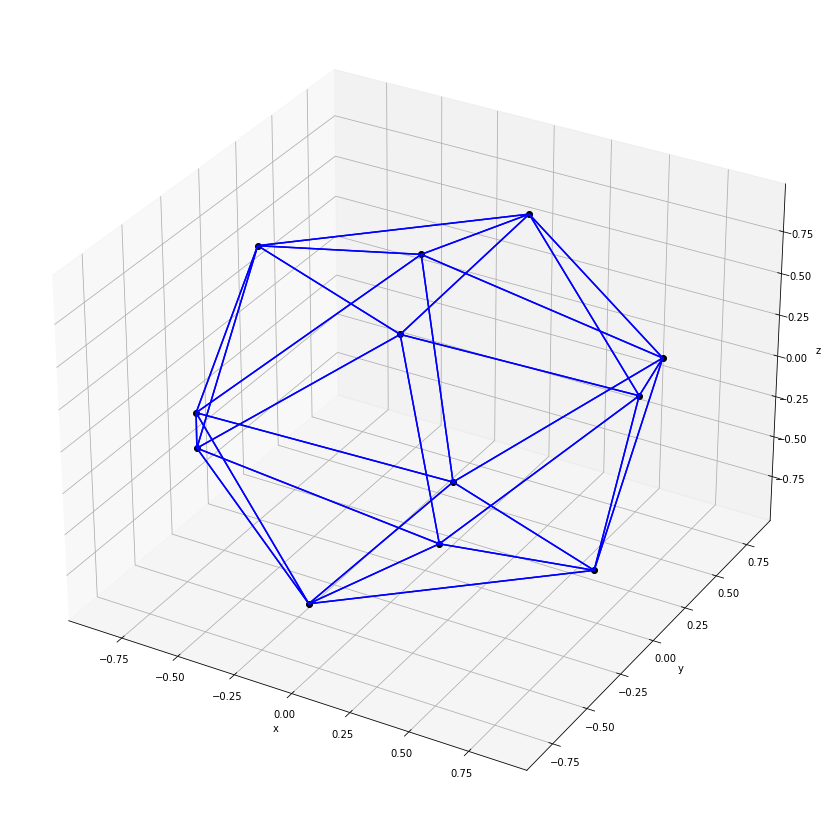

In [27]:


pts = W.cpu().detach().numpy()


hull = ConvexHull(pts)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection="3d")

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))

plt.show()

## so

In [28]:
def SO(weight):
    if len(weight) == 2:
        weight = weight[0]
    m = weight.shape[0]
    W = weight.view(m, -1)
    loss = torch.sum((W @ torch.t(W) - torch.eye(m, dtype=float).cuda())**2)
    return loss

In [29]:
lamd1 = 0.1
# lamd2 = 0.01
w1 = copy.deepcopy(W1)
W = torch.nn.Parameter(w1)
opt = optim.SGD([W], lr=1)
for i in range(1000):
    loss = SO(W)
    loss = lamd1*loss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')

0.71, 0.51, 0.11, 0.97
0.54, 0.64, 0.19, 1.01
0.48, 0.66, 0.25, 1.02
0.49, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66,

0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66,

0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66, 0.25, 1.04
0.50, 0.66,

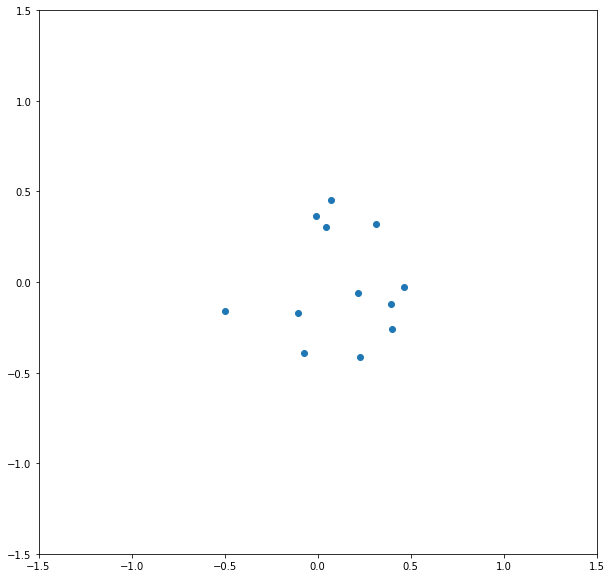

In [30]:
pcloud = W.detach().cpu().numpy()
fig, axs = plt.subplots(ncols=1, figsize=(10, 10))
axs.set_xlim(-1.5, 1.5)
axs.set_ylim(-1.5, 1.5)
axs.scatter(pcloud[:, 0], pcloud[:, 1])
plt.show()

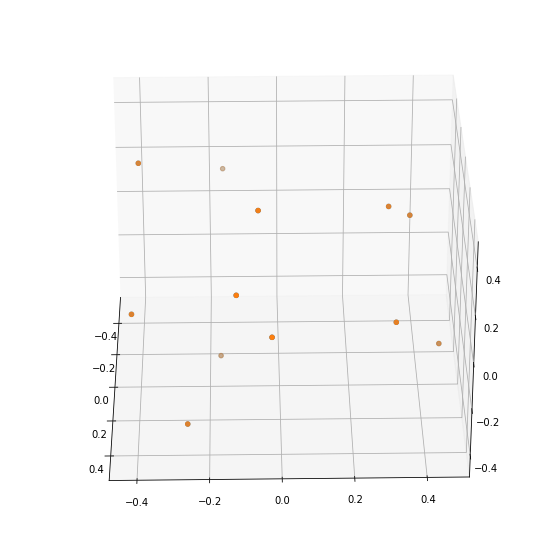

In [31]:
pcloud = W.detach().cpu().numpy()
fig, axs = plt.subplots(ncols=1, figsize=(10, 10), subplot_kw={"projection":"3d"})

def init():
    axs.scatter(pcloud[:, 0], pcloud[:, 1], pcloud[:, 2])
    return fig,

def animate(i):
    axs.view_init(elev=30., azim=i)
    return fig,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=360, interval=20, blit=True)
anim.save('mpl3d_scatter12SO.gif', fps=30)

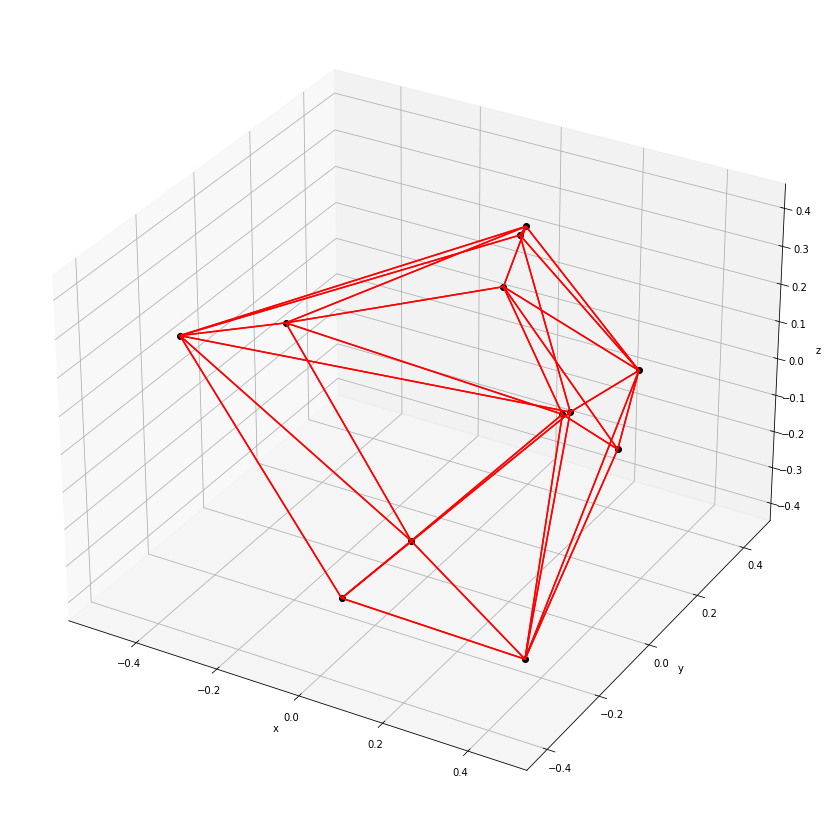

In [32]:


pts = W.cpu().detach().numpy()


hull = ConvexHull(pts)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection="3d")

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "r-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))

plt.show()

## srip

In [33]:
def SRIP(W):
    cols = W[0].numel()
    rows = W.shape[0]
    w1 = W.view(-1,cols)
    wt = torch.transpose(w1,0,1)
    m  = torch.matmul(w1,wt)
    ident = Variable(torch.eye(rows,rows))
    ident = ident.cuda()

    w_tmp = (m - ident)
    height = w_tmp.size(0)
    u = normalize(w_tmp.new_empty(height).normal_(0,1), dim=0, eps=1e-12)
    v = normalize(torch.matmul(w_tmp.t(), u), dim=0, eps=1e-12)
    u = normalize(torch.matmul(w_tmp, v), dim=0, eps=1e-12)
    sigma = torch.dot(u, torch.matmul(w_tmp, v))

    sloss = (sigma)**2
    return sloss

In [34]:
lamd1 = 0.001
# lamd2 = 0.01
w1 = copy.deepcopy(W1)
W = torch.nn.Parameter(w1)
opt = optim.SGD([W], lr=1)
for i in range(1000):
    loss = SRIP(W)
    loss = lamd1*loss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')

0.99, 0.57, 0.22, 1.01
0.99, 0.57, 0.22, 1.02
0.98, 0.58, 0.23, 1.03
0.98, 0.58, 0.23, 1.02
0.97, 0.58, 0.23, 1.03
0.97, 0.59, 0.23, 1.04
0.96, 0.59, 0.23, 1.05
0.96, 0.59, 0.24, 1.05
0.95, 0.59, 0.24, 1.06
0.95, 0.60, 0.24, 1.07
0.94, 0.60, 0.24, 1.08
0.94, 0.60, 0.24, 1.08
0.94, 0.61, 0.24, 1.10
0.93, 0.61, 0.24, 1.10
0.93, 0.61, 0.24, 1.10
0.93, 0.61, 0.24, 1.10
0.92, 0.61, 0.24, 1.11
0.92, 0.62, 0.24, 1.12
0.92, 0.62, 0.24, 1.12
0.92, 0.62, 0.24, 1.12
0.91, 0.62, 0.25, 1.13
0.91, 0.62, 0.25, 1.14
0.90, 0.62, 0.25, 1.14
0.90, 0.63, 0.25, 1.14
0.90, 0.63, 0.25, 1.15
0.89, 0.63, 0.25, 1.16
0.89, 0.63, 0.25, 1.16
0.89, 0.63, 0.25, 1.16
0.89, 0.63, 0.25, 1.16
0.88, 0.63, 0.25, 1.16
0.88, 0.63, 0.25, 1.17
0.87, 0.64, 0.25, 1.17
0.87, 0.64, 0.25, 1.17
0.87, 0.64, 0.25, 1.18
0.87, 0.64, 0.25, 1.19
0.86, 0.64, 0.24, 1.19
0.86, 0.64, 0.25, 1.19
0.86, 0.64, 0.25, 1.20
0.86, 0.64, 0.25, 1.20
0.85, 0.64, 0.24, 1.20
0.85, 0.64, 0.24, 1.21
0.85, 0.64, 0.24, 1.21
0.85, 0.64, 0.24, 1.21
0.84, 0.65,

0.68, 0.67, 0.25, 1.05
0.68, 0.67, 0.25, 1.05
0.68, 0.67, 0.25, 1.05
0.68, 0.67, 0.25, 1.05
0.68, 0.67, 0.25, 1.05
0.68, 0.67, 0.25, 1.05
0.68, 0.67, 0.25, 1.05
0.68, 0.67, 0.25, 1.05
0.68, 0.67, 0.25, 1.05
0.68, 0.67, 0.25, 1.05
0.68, 0.67, 0.25, 1.05
0.68, 0.67, 0.25, 1.05
0.67, 0.67, 0.25, 1.05
0.67, 0.67, 0.25, 1.05
0.67, 0.67, 0.25, 1.05
0.67, 0.67, 0.25, 1.05
0.67, 0.67, 0.25, 1.05
0.67, 0.67, 0.25, 1.05
0.67, 0.67, 0.25, 1.05
0.67, 0.67, 0.25, 1.05
0.67, 0.67, 0.25, 1.05
0.67, 0.67, 0.25, 1.05
0.67, 0.67, 0.25, 1.05
0.67, 0.67, 0.25, 1.05
0.67, 0.67, 0.25, 1.05
0.67, 0.67, 0.25, 1.05
0.67, 0.67, 0.25, 1.05
0.67, 0.67, 0.25, 1.05
0.67, 0.67, 0.25, 1.05
0.67, 0.67, 0.25, 1.05
0.67, 0.67, 0.25, 1.05
0.67, 0.67, 0.25, 1.05
0.67, 0.67, 0.25, 1.05
0.67, 0.67, 0.25, 1.05
0.67, 0.67, 0.25, 1.05
0.67, 0.67, 0.25, 1.05
0.67, 0.67, 0.25, 1.05
0.67, 0.67, 0.25, 1.05
0.67, 0.67, 0.25, 1.05
0.67, 0.67, 0.25, 1.05
0.67, 0.67, 0.25, 1.05
0.67, 0.67, 0.25, 1.05
0.67, 0.67, 0.25, 1.05
0.67, 0.67,

0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.05
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.05
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67, 0.25, 1.04
0.65, 0.67,

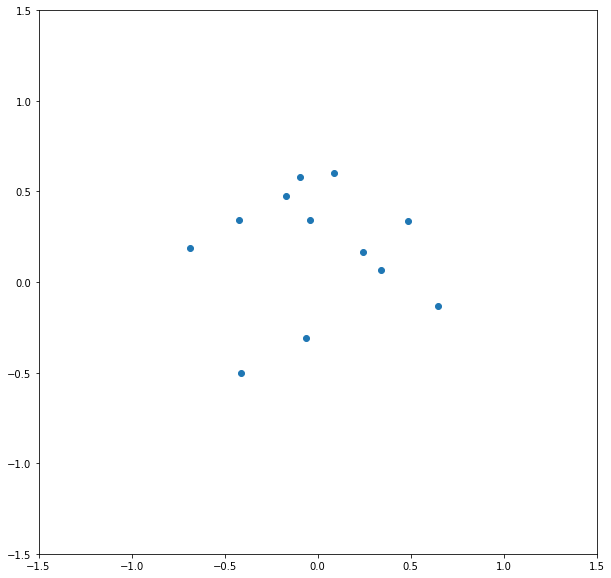

In [35]:
pcloud = W.detach().cpu().numpy()
fig, axs = plt.subplots(ncols=1, figsize=(10, 10))
axs.set_xlim(-1.5, 1.5)
axs.set_ylim(-1.5, 1.5)
axs.scatter(pcloud[:, 0], pcloud[:, 1])
plt.show()

## mst

In [36]:
def MST(weight):
    if len(weight) == 2:
        weight = weight[0]
    m = weight.shape[0]
    W = weight.view(m, -1)
    dist = torch.sqrt(torch.sum(torch.pow(W[:, None, :] - W[None, :, :], 2), dim=2))
    Tscr = minimum_spanning_tree(dist.detach().cpu().numpy())
    result = Tscr.toarray()
    mst = np.where(result > 0)
    tloss = -torch.sqrt(((W[mst[0]] - W[mst[1]])**2).sum(-1)).sum()

    norm = torch.norm(W, dim=1)
    nloss = torch.sum((1 - norm**2)**2)
    return nloss, tloss

In [37]:
lamd1 = 0.1
lamd2 = 0.1
w1 = copy.deepcopy(W1)
W = torch.nn.Parameter(w1)
opt = optim.SGD([W], lr=1)
for i in range(1000):
    nloss, tloss = MST(W)
    loss = lamd1*nloss + lamd2*tloss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')

1.07, 0.65, 0.32, 1.10
1.08, 0.75, 0.45, 1.23
1.08, 0.80, 0.49, 1.21
1.09, 0.81, 0.58, 1.20
1.09, 0.86, 0.61, 1.24
1.09, 0.87, 0.64, 1.23
1.09, 0.89, 0.68, 1.19
1.09, 0.90, 0.69, 1.12
1.09, 0.92, 0.65, 1.20
1.09, 0.91, 0.71, 1.10
1.09, 0.91, 0.67, 1.13
1.09, 0.92, 0.65, 1.08
1.09, 0.93, 0.73, 1.10
1.09, 0.92, 0.70, 1.11
1.09, 0.95, 0.84, 1.04
1.09, 0.96, 0.83, 1.10
1.10, 0.96, 0.87, 1.06
1.10, 0.98, 0.93, 1.08
1.10, 0.96, 0.79, 1.04
1.10, 0.99, 0.92, 1.10
1.10, 0.98, 0.91, 1.04
1.10, 1.01, 0.88, 1.10
1.10, 0.99, 0.95, 1.05
1.10, 1.01, 0.98, 1.08
1.10, 1.01, 0.96, 1.07
1.10, 1.00, 0.96, 1.08
1.10, 1.02, 0.98, 1.08
1.10, 1.03, 0.99, 1.07
1.10, 1.03, 0.99, 1.06
1.10, 1.00, 0.91, 1.08
1.10, 1.03, 0.99, 1.07
1.10, 0.99, 0.92, 1.07
1.10, 1.04, 1.01, 1.07
1.10, 1.03, 0.99, 1.07
1.10, 1.03, 0.99, 1.08
1.10, 1.01, 0.95, 1.09
1.10, 1.02, 0.97, 1.07
1.10, 1.00, 0.96, 1.05
1.10, 1.01, 0.95, 1.07
1.10, 1.04, 0.94, 1.08
1.10, 1.02, 0.97, 1.11
1.10, 1.02, 0.94, 1.08
1.10, 0.99, 0.89, 1.10
1.10, 1.03,

1.10, 1.04, 0.96, 1.10
1.10, 1.02, 0.99, 1.10
1.10, 1.00, 0.91, 1.08
1.10, 1.04, 0.99, 1.10
1.10, 1.03, 1.01, 1.07
1.10, 0.99, 0.92, 1.08
1.10, 1.05, 1.00, 1.09
1.10, 1.00, 0.91, 1.07
1.10, 1.03, 1.00, 1.07
1.10, 1.01, 0.98, 1.05
1.10, 1.00, 0.96, 1.06
1.10, 1.04, 0.99, 1.08
1.10, 1.01, 0.93, 1.10
1.10, 0.98, 0.90, 1.07
1.10, 1.01, 0.95, 1.09
1.10, 1.05, 1.02, 1.10
1.10, 1.01, 0.98, 1.04
1.10, 1.01, 0.97, 1.06
1.10, 1.02, 0.98, 1.08
1.10, 1.01, 0.95, 1.08
1.10, 0.99, 0.93, 1.06
1.10, 1.03, 1.00, 1.10
1.10, 1.01, 0.98, 1.08
1.10, 1.04, 0.99, 1.10
1.10, 1.00, 0.97, 1.06
1.10, 1.00, 0.95, 1.04
1.10, 1.02, 0.95, 1.08
1.10, 1.01, 0.94, 1.09
1.10, 1.02, 0.96, 1.09
1.10, 1.00, 0.94, 1.07
1.10, 1.04, 1.00, 1.10
1.10, 1.02, 0.98, 1.11
1.10, 1.01, 0.96, 1.11
1.10, 1.04, 0.99, 1.09
1.10, 1.00, 0.94, 1.05
1.10, 1.01, 0.92, 1.11
1.10, 1.01, 0.92, 1.07
1.10, 1.01, 0.91, 1.07
1.10, 1.03, 0.97, 1.09
1.10, 1.02, 0.99, 1.06
1.10, 1.03, 0.98, 1.06
1.10, 1.01, 0.97, 1.06
1.10, 1.01, 0.94, 1.08
1.10, 1.02,

1.10, 1.03, 1.00, 1.10
1.10, 1.00, 0.93, 1.11
1.10, 1.05, 1.02, 1.08
1.10, 1.04, 1.00, 1.07
1.10, 1.02, 1.00, 1.08
1.10, 1.03, 0.98, 1.07
1.10, 1.03, 1.00, 1.08
1.10, 1.04, 1.00, 1.11
1.10, 1.01, 0.96, 1.10
1.10, 1.00, 0.94, 1.08
1.10, 1.05, 1.02, 1.09
1.10, 1.01, 0.95, 1.09
1.10, 0.98, 0.89, 1.05
1.10, 1.03, 0.97, 1.06
1.10, 1.01, 0.94, 1.10
1.10, 1.04, 0.99, 1.09
1.10, 1.01, 0.94, 1.07
1.10, 1.03, 0.99, 1.11
1.10, 1.03, 1.00, 1.07
1.10, 1.04, 1.01, 1.09
1.10, 1.03, 0.96, 1.09
1.10, 1.01, 0.96, 1.08
1.10, 1.04, 0.98, 1.10
1.10, 1.01, 0.96, 1.06
1.10, 1.01, 0.93, 1.07
1.10, 0.99, 0.92, 1.08
1.10, 1.03, 0.97, 1.05
1.10, 1.01, 0.95, 1.06
1.10, 1.02, 0.97, 1.08
1.10, 1.02, 1.00, 1.08
1.10, 0.99, 0.91, 1.08
1.10, 1.03, 0.98, 1.07
1.10, 1.03, 0.97, 1.06
1.10, 1.03, 0.99, 1.09
1.10, 1.05, 1.01, 1.12
1.10, 1.01, 0.96, 1.07
1.10, 1.03, 0.97, 1.06
1.10, 1.02, 0.98, 1.06
1.10, 1.03, 0.97, 1.09
1.10, 0.99, 0.96, 1.04
1.10, 1.02, 0.98, 1.05
1.10, 1.02, 0.95, 1.09
1.10, 1.00, 0.95, 1.06
1.10, 1.02,

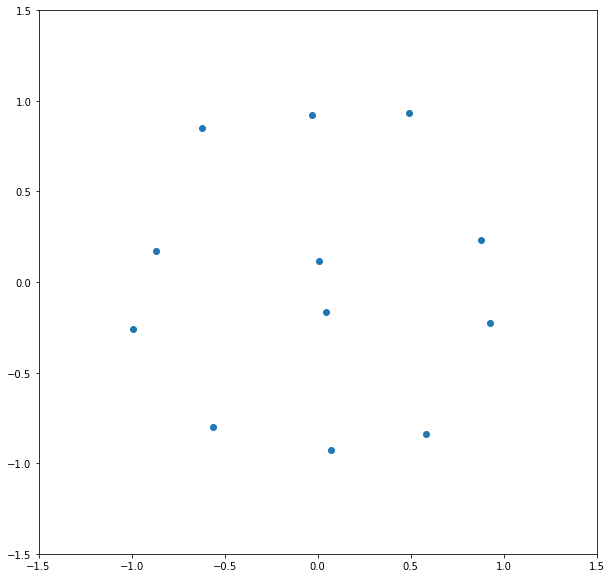

In [38]:
pcloud = W.detach().cpu().numpy()
fig, axs = plt.subplots(ncols=1, figsize=(10, 10))

axs.scatter(pcloud[:, 0], pcloud[:, 1])
axs.set_xlim(-1.5, 1.5)
axs.set_ylim(-1.5, 1.5)
plt.show()

In [39]:
W

Parameter containing:
tensor([[ 0.0720, -0.9264, -0.6916],
        [ 0.5807, -0.8367,  0.4564],
        [ 0.0066,  0.1161, -1.0480],
        [-0.5599, -0.7988,  0.4132],
        [ 0.0453, -0.1651,  1.0473],
        [-0.8708,  0.1713,  0.5733],
        [ 0.4907,  0.9334, -0.4804],
        [ 0.8789,  0.2322,  0.5471],
        [ 0.9264, -0.2252, -0.5748],
        [-0.0320,  0.9244,  0.6897],
        [-0.6199,  0.8494, -0.3682],
        [-0.9935, -0.2599, -0.4309]], device='cuda:0', requires_grad=True)

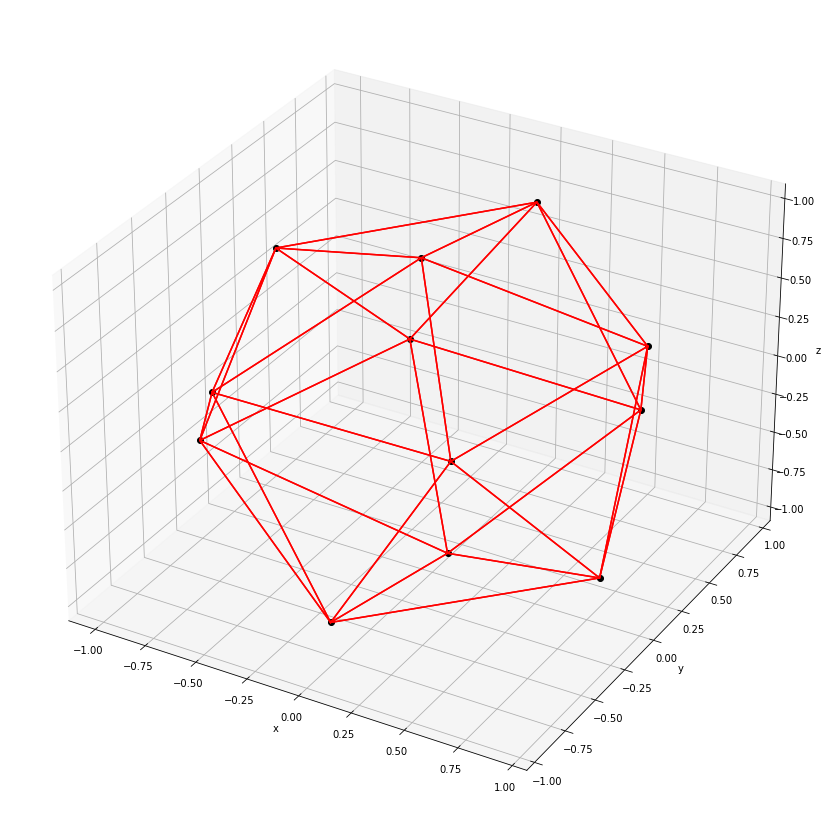

In [40]:

pts = W.cpu().detach().numpy()


hull = ConvexHull(pts)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection="3d")

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "r-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))

plt.show()

# Make Figure

## 4

In [41]:
W1 = torch.randn(4, 3).cuda()
W1 /= torch.norm(W1, dim=1, keepdim=True)
W1.requires_grad_()
with torch.no_grad():
    Norm = torch.norm(W1, dim=1)
    norm = torch.mean(Norm).item()
    mean, Min, Max = angle_analysis(W1)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')

1.00, 0.60, 0.35, 1.13


In [42]:
stime = time()
stime = time()
print('SO')
lamd1 = 0.01
# lamd2 = 0.01
w1 = copy.deepcopy(W1)
W1_so = torch.nn.Parameter(w1)
opt = optim.SGD([W1_so], lr=1)
for i in range(1000):
    loss = SO(W1_so)
    loss = lamd1*loss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_so, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_so)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')
print(time() - stime)

stime = time()
print('SRIP')
lamd1 = 0.01
# lamd2 = 0.01
w1 = copy.deepcopy(W1)
W1_srip = torch.nn.Parameter(w1)
opt = optim.SGD([W1_srip], lr=1)
for i in range(1000):
    loss = SRIP(W1_srip)
    loss = lamd1*loss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_srip, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_srip)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')
print(time() - stime)

stime = time()
print('MST')
lamd1 = 0.1
lamd2 = 0.01
w1 = copy.deepcopy(W1)
W1_mst = torch.nn.Parameter(w1)
opt = optim.SGD([W1_mst], lr=1)
for i in range(1000):
    nloss, tloss = MST(W1_mst)
    loss = lamd1*nloss + lamd2*tloss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_mst, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_mst)
    print(f'{norm:.2f}, {mean.item():.4f}, {Min.item():.4f}, {Max.item():.4f}')
print(time() - stime)

stime = time()
print('ADK')
lamd1 = 0.1
lamd2 = 0.01
w1 = copy.deepcopy(W1)
W1_adk = torch.nn.Parameter(w1)
opt = optim.SGD([W1_adk], lr=1)
for i in range(1000):
    nloss, tloss = ADK(W1_adk, theta=(109.47*np.pi/2))
    loss = lamd1*nloss + lamd2*tloss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_adk, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_adk)
    print(f'{norm:.2f}, {mean.item():.4f}, {Min.item():.4f}, {Max.item():.4f}')
print(time() - stime)

SO
0.95, 0.64, 0.38, 1.17
0.91, 0.67, 0.40, 1.20
0.89, 0.70, 0.42, 1.22
0.87, 0.72, 0.44, 1.24
0.85, 0.74, 0.45, 1.26
0.84, 0.76, 0.46, 1.28
0.83, 0.78, 0.48, 1.29
0.82, 0.79, 0.49, 1.30
0.82, 0.81, 0.50, 1.32
0.81, 0.82, 0.50, 1.32
0.81, 0.83, 0.51, 1.33
0.81, 0.84, 0.52, 1.33
0.80, 0.85, 0.53, 1.34
0.80, 0.86, 0.53, 1.34
0.80, 0.87, 0.54, 1.34
0.80, 0.88, 0.55, 1.34
0.80, 0.89, 0.55, 1.35
0.80, 0.89, 0.55, 1.35
0.80, 0.90, 0.56, 1.35
0.80, 0.91, 0.56, 1.35
0.81, 0.91, 0.57, 1.35
0.81, 0.92, 0.57, 1.35
0.81, 0.92, 0.57, 1.35
0.81, 0.93, 0.58, 1.35
0.81, 0.93, 0.58, 1.35
0.81, 0.94, 0.58, 1.35
0.82, 0.94, 0.59, 1.35
0.82, 0.94, 0.59, 1.35
0.82, 0.95, 0.59, 1.35
0.82, 0.95, 0.59, 1.35
0.82, 0.95, 0.59, 1.35
0.83, 0.96, 0.60, 1.35
0.83, 0.96, 0.60, 1.35
0.83, 0.96, 0.60, 1.35
0.83, 0.96, 0.60, 1.35
0.83, 0.97, 0.60, 1.35
0.83, 0.97, 0.60, 1.35
0.84, 0.97, 0.60, 1.35
0.84, 0.97, 0.61, 1.35
0.84, 0.97, 0.61, 1.35
0.84, 0.98, 0.61, 1.35
0.84, 0.98, 0.61, 1.35
0.84, 0.98, 0.61, 1.35
0.84, 0.

0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99,

0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99, 0.62, 1.40
0.86, 0.99,

0.80, 0.82, 0.58, 1.12
0.80, 0.81, 0.58, 1.12
0.80, 0.82, 0.59, 1.11
0.80, 0.81, 0.58, 1.12
0.80, 0.81, 0.57, 1.11
0.80, 0.81, 0.57, 1.11
0.80, 0.81, 0.58, 1.10
0.80, 0.81, 0.58, 1.10
0.80, 0.81, 0.59, 1.10
0.80, 0.81, 0.58, 1.09
0.80, 0.82, 0.58, 1.10
0.80, 0.82, 0.58, 1.10
0.80, 0.82, 0.57, 1.11
0.80, 0.82, 0.58, 1.09
0.79, 0.83, 0.59, 1.09
0.79, 0.83, 0.59, 1.09
0.79, 0.82, 0.58, 1.10
0.79, 0.83, 0.58, 1.10
0.79, 0.82, 0.58, 1.09
0.79, 0.83, 0.60, 1.08
0.80, 0.83, 0.60, 1.08
0.79, 0.82, 0.58, 1.08
0.80, 0.82, 0.58, 1.09
0.80, 0.82, 0.57, 1.09
0.80, 0.81, 0.54, 1.11
0.80, 0.81, 0.54, 1.12
0.80, 0.82, 0.56, 1.11
0.80, 0.82, 0.55, 1.10
0.80, 0.82, 0.54, 1.10
0.80, 0.82, 0.55, 1.11
0.80, 0.83, 0.55, 1.11
0.80, 0.82, 0.55, 1.11
0.80, 0.83, 0.57, 1.10
0.80, 0.84, 0.58, 1.09
0.80, 0.84, 0.59, 1.10
0.80, 0.84, 0.59, 1.10
0.79, 0.85, 0.59, 1.11
0.79, 0.85, 0.60, 1.11
0.79, 0.85, 0.61, 1.12
0.79, 0.85, 0.60, 1.12
0.79, 0.85, 0.61, 1.12
0.79, 0.84, 0.60, 1.12
0.79, 0.84, 0.58, 1.12
0.79, 0.83,

0.79, 0.75, 0.43, 1.21
0.79, 0.74, 0.43, 1.21
0.79, 0.74, 0.43, 1.21
0.79, 0.75, 0.43, 1.22
0.79, 0.75, 0.42, 1.22
0.79, 0.74, 0.41, 1.22
0.79, 0.74, 0.40, 1.22
0.79, 0.74, 0.40, 1.21
0.79, 0.74, 0.40, 1.22
0.79, 0.74, 0.40, 1.22
0.79, 0.74, 0.40, 1.22
0.79, 0.74, 0.41, 1.22
0.79, 0.74, 0.41, 1.23
0.79, 0.75, 0.44, 1.23
0.79, 0.76, 0.44, 1.23
0.79, 0.76, 0.44, 1.25
0.79, 0.76, 0.44, 1.24
0.79, 0.76, 0.45, 1.22
0.79, 0.76, 0.45, 1.22
0.79, 0.77, 0.47, 1.21
0.79, 0.77, 0.47, 1.21
0.79, 0.76, 0.45, 1.20
0.79, 0.76, 0.46, 1.20
0.79, 0.75, 0.45, 1.20
0.79, 0.76, 0.46, 1.18
0.79, 0.76, 0.45, 1.18
0.79, 0.76, 0.45, 1.19
0.80, 0.76, 0.44, 1.18
0.80, 0.76, 0.45, 1.18
0.80, 0.76, 0.44, 1.20
0.80, 0.75, 0.44, 1.19
0.79, 0.76, 0.45, 1.20
0.79, 0.76, 0.44, 1.20
0.80, 0.75, 0.43, 1.20
0.80, 0.75, 0.41, 1.21
0.80, 0.75, 0.41, 1.20
0.80, 0.75, 0.42, 1.20
0.80, 0.76, 0.44, 1.19
0.80, 0.75, 0.42, 1.20
0.80, 0.75, 0.43, 1.21
0.80, 0.75, 0.44, 1.21
0.80, 0.75, 0.44, 1.20
0.80, 0.75, 0.44, 1.19
0.80, 0.75,

1.01, 0.9447, 0.7679, 1.2828
1.01, 0.9548, 0.7818, 1.2870
1.01, 0.9686, 0.8023, 1.2878
1.01, 0.9813, 0.8156, 1.2953
1.01, 0.9931, 0.8293, 1.3042
1.01, 1.0058, 0.8499, 1.2998
1.01, 1.0171, 0.8625, 1.3072
1.01, 1.0298, 0.8763, 1.3163
1.01, 1.0419, 0.8961, 1.3117
1.01, 1.0522, 0.9092, 1.3202
1.01, 1.0654, 0.9220, 1.3278
1.01, 1.0770, 0.9416, 1.3231
1.01, 1.0874, 0.9545, 1.3319
1.01, 1.1003, 0.9669, 1.3393
1.01, 1.1108, 0.9864, 1.3345
1.01, 1.1218, 0.9989, 1.3428
1.01, 1.1335, 1.0110, 1.3495
1.01, 1.1429, 1.0302, 1.3465
1.01, 1.1553, 1.0422, 1.3538
1.01, 1.1653, 1.0542, 1.3574
1.01, 1.1758, 1.0727, 1.3574
1.01, 1.1880, 1.0843, 1.3650
1.01, 1.1961, 1.0960, 1.3651
1.01, 1.2080, 1.1145, 1.3681
1.01, 1.2199, 1.1258, 1.3753
1.01, 1.2290, 1.1440, 1.3696
1.01, 1.2392, 1.1552, 1.3782
1.01, 1.2497, 1.1661, 1.3840
1.01, 1.2582, 1.1839, 1.3813
1.01, 1.2698, 1.1948, 1.3886
1.01, 1.2780, 1.2054, 1.3898
1.01, 1.2881, 1.2229, 1.3911
1.01, 1.2994, 1.2333, 1.3986
1.01, 1.3083, 1.2507, 1.3927
1.01, 1.3171, 

1.01, 1.9055, 1.9046, 1.9081
1.01, 1.9055, 1.9022, 1.9091
1.01, 1.9055, 1.9046, 1.9081
1.01, 1.9055, 1.9022, 1.9091
1.01, 1.9055, 1.9047, 1.9081
1.01, 1.9056, 1.9022, 1.9094
1.01, 1.9055, 1.9045, 1.9079
1.01, 1.9056, 1.9022, 1.9094
1.01, 1.9055, 1.9045, 1.9079
1.01, 1.9056, 1.9022, 1.9094
1.01, 1.9054, 1.9045, 1.9079
1.01, 1.9056, 1.9022, 1.9094
1.01, 1.9055, 1.9044, 1.9081
1.01, 1.9055, 1.9022, 1.9094
1.01, 1.9055, 1.9044, 1.9081
1.01, 1.9055, 1.9022, 1.9095
1.01, 1.9056, 1.9043, 1.9083
1.01, 1.9055, 1.9019, 1.9094
1.01, 1.9056, 1.9042, 1.9083
1.01, 1.9055, 1.9019, 1.9094
1.01, 1.9056, 1.9042, 1.9083
1.01, 1.9055, 1.9019, 1.9094
1.01, 1.9056, 1.9041, 1.9083
1.01, 1.9056, 1.9019, 1.9094
1.01, 1.9055, 1.9041, 1.9083
1.01, 1.9056, 1.9019, 1.9094
1.01, 1.9056, 1.9040, 1.9081
1.01, 1.9056, 1.9019, 1.9094
1.01, 1.9056, 1.9040, 1.9081
1.01, 1.9056, 1.9019, 1.9095
1.01, 1.9055, 1.9038, 1.9081
1.01, 1.9056, 1.9019, 1.9094
1.01, 1.9055, 1.9038, 1.9081
1.01, 1.9057, 1.9022, 1.9094
1.01, 1.9054, 

1.01, 1.9018, 1.8988, 1.9049
1.01, 1.9018, 1.8991, 1.9045
1.01, 1.9018, 1.8988, 1.9049
1.01, 1.9018, 1.8991, 1.9045
1.01, 1.9018, 1.8988, 1.9049
1.01, 1.9018, 1.8991, 1.9045
1.01, 1.9018, 1.8988, 1.9049
1.01, 1.9018, 1.8991, 1.9045
1.01, 1.9018, 1.8988, 1.9049
1.01, 1.9018, 1.8990, 1.9045
1.01, 1.9018, 1.8988, 1.9048
1.01, 1.9018, 1.8990, 1.9045
1.01, 1.9018, 1.8988, 1.9048
1.01, 1.9018, 1.8990, 1.9045
1.01, 1.9018, 1.8988, 1.9048
1.01, 1.9018, 1.8990, 1.9045
1.01, 1.9018, 1.8988, 1.9048
1.01, 1.9018, 1.8990, 1.9045
1.01, 1.9018, 1.8988, 1.9048
1.01, 1.9018, 1.8990, 1.9045
1.01, 1.9018, 1.8988, 1.9048
1.01, 1.9018, 1.8990, 1.9045
1.01, 1.9018, 1.8988, 1.9048
1.01, 1.9017, 1.8989, 1.9045
1.01, 1.9017, 1.8988, 1.9047
1.01, 1.9017, 1.8989, 1.9045
1.01, 1.9017, 1.8988, 1.9047
1.01, 1.9017, 1.8989, 1.9045
1.01, 1.9017, 1.8988, 1.9047
1.01, 1.9017, 1.8989, 1.9045
1.01, 1.9017, 1.8988, 1.9047
1.01, 1.9017, 1.8989, 1.9045
1.01, 1.9017, 1.8988, 1.9047
1.01, 1.9016, 1.8989, 1.9043
1.01, 1.9017, 

1.01, 1.9002, 1.8973, 1.9031
1.01, 1.9001, 1.8973, 1.9030
1.01, 1.9001, 1.8972, 1.9031
1.01, 1.9001, 1.8973, 1.9030
1.01, 1.9001, 1.8972, 1.9031
1.01, 1.9001, 1.8973, 1.9030
1.01, 1.9001, 1.8972, 1.9031
1.01, 1.9001, 1.8973, 1.9029
1.01, 1.9001, 1.8972, 1.9031
1.01, 1.9001, 1.8973, 1.9029
1.01, 1.9001, 1.8972, 1.9031
1.01, 1.9001, 1.8973, 1.9029
1.01, 1.9001, 1.8972, 1.9031
1.01, 1.9001, 1.8973, 1.9029
1.01, 1.9001, 1.8972, 1.9030
1.01, 1.9001, 1.8973, 1.9029
1.01, 1.9001, 1.8972, 1.9030
1.01, 1.9001, 1.8973, 1.9029
1.01, 1.9001, 1.8972, 1.9030
1.01, 1.9001, 1.8973, 1.9029
1.01, 1.9000, 1.8972, 1.9028
1.01, 1.9001, 1.8973, 1.9029
1.01, 1.9000, 1.8972, 1.9028
1.01, 1.9001, 1.8973, 1.9029
1.01, 1.9000, 1.8972, 1.9028
1.01, 1.9001, 1.8973, 1.9029
1.01, 1.9000, 1.8972, 1.9028
1.01, 1.9001, 1.8973, 1.9029
1.01, 1.9000, 1.8972, 1.9028
1.01, 1.9001, 1.8973, 1.9029
1.01, 1.9000, 1.8972, 1.9028
1.01, 1.9001, 1.8973, 1.9029
1.01, 1.9000, 1.8972, 1.9028
1.01, 1.9001, 1.8973, 1.9029
1.01, 1.9000, 

nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, na

nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, na

ValueError: Points cannot contain NaN

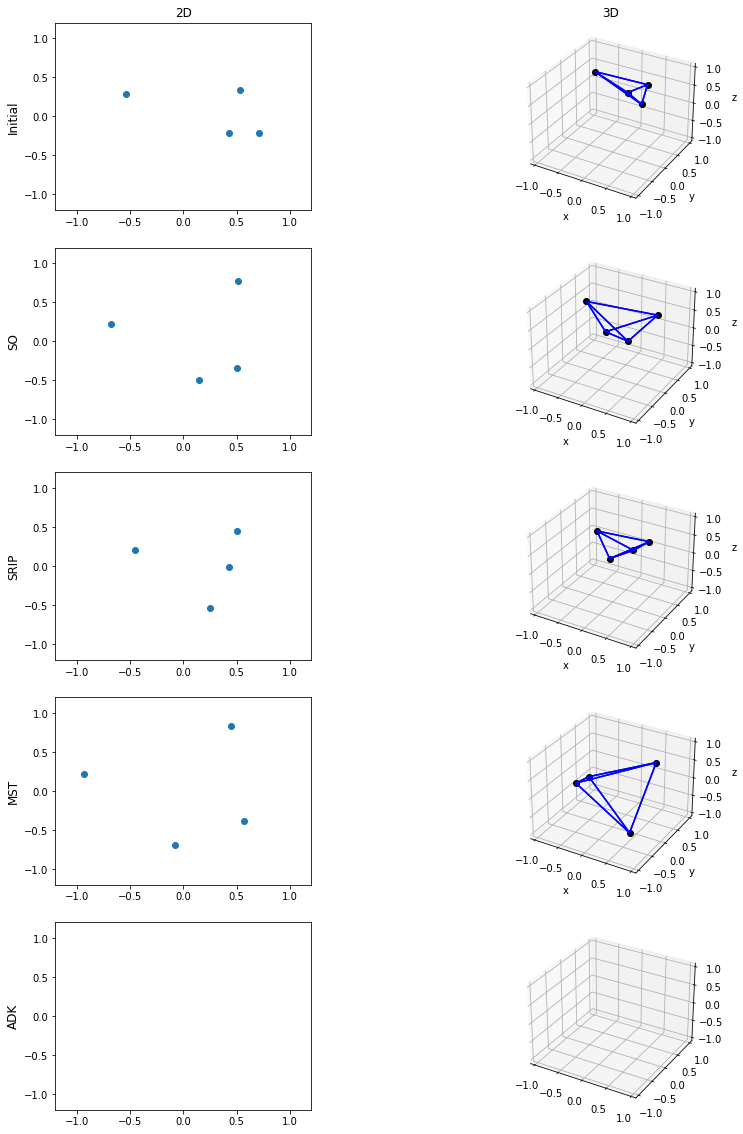

In [43]:
fig = plt.figure(figsize=(13, 20))

spec = gridspec.GridSpec(ncols=3, nrows=5, width_ratios=[3, 0.5, 4])

ax = fig.add_subplot(spec[0])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1.detach().cpu().numpy()[:, 0], W1.detach().cpu().numpy()[:, 1])
ax.set_title('2D')
ax.set_ylabel('Initial', size='large')

ax = fig.add_subplot(spec[2], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
ax.set_title('3D')
pts = W1.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))


####################
ax = fig.add_subplot(spec[3])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1_so.detach().cpu().numpy()[:, 0], W1_so.detach().cpu().numpy()[:, 1])
ax.set_ylabel('SO', size='large')

ax = fig.add_subplot(spec[5], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)

pts = W1_so.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    
###################
ax = fig.add_subplot(spec[6])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1_srip.detach().cpu().numpy()[:, 0], W1_srip.detach().cpu().numpy()[:, 1])
ax.set_ylabel('SRIP', size='large')

ax = fig.add_subplot(spec[8], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)

pts = W1_srip.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))

##################
ax = fig.add_subplot(spec[9])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1_mst.detach().cpu().numpy()[:, 0], W1_mst.detach().cpu().numpy()[:, 1])
ax.set_ylabel('MST', size='large')

ax = fig.add_subplot(spec[11], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)

pts = W1_mst.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    
#######################
ax = fig.add_subplot(spec[12])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1_adk.detach().cpu().numpy()[:, 0], W1_adk.detach().cpu().numpy()[:, 1])
ax.set_ylabel('ADK', size='large')

ax = fig.add_subplot(spec[14], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)

pts = W1_adk.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    

fig.tight_layout()
plt.show()

## 6

In [44]:
W1_6 = torch.randn(6, 3).cuda()
W1_6 /= torch.norm(W1_6, dim=1, keepdim=True)
W1_6.requires_grad_()
with torch.no_grad():
    Norm = torch.norm(W1_6, dim=1)
    norm = torch.mean(Norm).item()
    mean, Min, Max = angle_analysis(W1_6)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')

1.00, 0.97, 0.68, 1.59


In [45]:
stime = time()
stime = time()
print('SO')
lamd1 = 0.01
# lamd2 = 0.01
w1 = copy.deepcopy(W1_6)
W1_so_6 = torch.nn.Parameter(w1)
opt = optim.SGD([W1_so_6], lr=1)
for i in range(1000):
    loss = SO(W1_so_6)
    loss = lamd1*loss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_so_6, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_so_6)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')
print(time() - stime)

stime = time()
print('SRIP')
lamd1 = 0.01
# lamd2 = 0.01
w1 = copy.deepcopy(W1_6)
W1_srip_6 = torch.nn.Parameter(w1)
opt = optim.SGD([W1_srip_6], lr=1)
for i in range(1000):
    loss = SRIP(W1_srip_6)
    loss = lamd1*loss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_srip_6, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_srip_6)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')
print(time() - stime)

stime = time()
print('MST')
lamd1 = 0.1
lamd2 = 0.01
w1 = copy.deepcopy(W1_6)
W1_mst_6 = torch.nn.Parameter(w1)
opt = optim.SGD([W1_mst_6], lr=1)
for i in range(1000):
    nloss, tloss = MST(W1_mst_6)
    loss = lamd1*nloss + lamd2*tloss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_mst_6, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_mst_6)
    print(f'{norm:.2f}, {mean.item():.4f}, {Min.item():.4f}, {Max.item():.4f}')
print(time() - stime)

stime = time()
print('ADK')
lamd1 = 0.1
lamd2 = 0.01
w1 = copy.deepcopy(W1_6)
W1_adk_6 = torch.nn.Parameter(w1)
opt = optim.SGD([W1_adk_6], lr=1)
for i in range(1000):
    nloss, tloss = ADK(W1_adk_6, theta=np.pi/2)
    loss = lamd1*nloss + lamd2*tloss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_adk_6, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_adk_6)
    print(f'{norm:.2f}, {mean.item():.4f}, {Min.item():.4f}, {Max.item():.4f}')
print(time() - stime)

SO
0.94, 0.98, 0.67, 1.59
0.90, 0.98, 0.66, 1.59
0.87, 0.98, 0.65, 1.59
0.85, 0.98, 0.64, 1.59
0.83, 0.98, 0.64, 1.59
0.81, 0.98, 0.63, 1.59
0.80, 0.99, 0.63, 1.60
0.79, 0.99, 0.63, 1.60
0.78, 0.99, 0.62, 1.60
0.77, 0.99, 0.62, 1.60
0.76, 0.99, 0.62, 1.60
0.76, 0.99, 0.61, 1.61
0.75, 0.99, 0.61, 1.61
0.75, 0.99, 0.61, 1.61
0.74, 0.99, 0.61, 1.61
0.74, 0.99, 0.61, 1.61
0.73, 0.99, 0.60, 1.61
0.73, 0.99, 0.60, 1.62
0.73, 1.00, 0.60, 1.62
0.73, 1.00, 0.60, 1.62
0.72, 1.00, 0.60, 1.62
0.72, 1.00, 0.60, 1.62
0.72, 1.00, 0.60, 1.62
0.72, 1.00, 0.60, 1.62
0.72, 1.00, 0.60, 1.62
0.71, 1.00, 0.59, 1.62
0.71, 1.00, 0.59, 1.62
0.71, 1.00, 0.59, 1.62
0.71, 1.00, 0.59, 1.62
0.71, 1.00, 0.59, 1.63
0.71, 1.00, 0.59, 1.63
0.71, 1.00, 0.59, 1.63
0.71, 1.00, 0.59, 1.63
0.71, 1.00, 0.59, 1.63
0.71, 1.00, 0.59, 1.63
0.71, 1.00, 0.59, 1.63
0.71, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.

0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00,

0.70, 1.00, 0.58, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.58, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.58, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.58, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.58, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.58, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.58, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.58, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.58, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.58, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.58, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.58, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.58, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.58, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00, 0.59, 1.63
0.70, 1.00,

0.78, 0.96, 0.68, 1.54
0.78, 0.96, 0.68, 1.54
0.78, 0.96, 0.68, 1.54
0.78, 0.96, 0.68, 1.53
0.78, 0.96, 0.68, 1.53
0.78, 0.96, 0.68, 1.53
0.78, 0.96, 0.68, 1.53
0.78, 0.96, 0.68, 1.53
0.78, 0.96, 0.68, 1.53
0.78, 0.96, 0.68, 1.53
0.78, 0.96, 0.67, 1.53
0.78, 0.96, 0.68, 1.53
0.78, 0.96, 0.68, 1.53
0.78, 0.96, 0.67, 1.53
0.78, 0.96, 0.67, 1.53
0.78, 0.96, 0.67, 1.53
0.78, 0.96, 0.67, 1.53
0.78, 0.96, 0.67, 1.53
0.77, 0.96, 0.65, 1.53
0.77, 0.96, 0.65, 1.53
0.78, 0.96, 0.66, 1.53
0.77, 0.96, 0.66, 1.53
0.77, 0.96, 0.66, 1.53
0.77, 0.96, 0.66, 1.53
0.77, 0.96, 0.67, 1.52
0.77, 0.96, 0.67, 1.53
0.77, 0.96, 0.67, 1.53
0.77, 0.96, 0.67, 1.53
0.78, 0.96, 0.67, 1.53
0.78, 0.96, 0.67, 1.52
0.78, 0.96, 0.67, 1.52
0.78, 0.96, 0.67, 1.52
0.78, 0.96, 0.67, 1.52
0.78, 0.97, 0.67, 1.53
0.78, 0.96, 0.67, 1.52
0.77, 0.96, 0.68, 1.52
0.77, 0.96, 0.67, 1.53
0.77, 0.96, 0.67, 1.53
0.77, 0.97, 0.68, 1.53
0.77, 0.97, 0.68, 1.53
0.77, 0.97, 0.68, 1.53
0.77, 0.97, 0.68, 1.52
0.77, 0.97, 0.68, 1.53
0.77, 0.97,

0.77, 0.94, 0.62, 1.52
0.77, 0.94, 0.62, 1.52
0.77, 0.94, 0.62, 1.52
0.77, 0.94, 0.62, 1.52
0.77, 0.94, 0.63, 1.51
0.77, 0.94, 0.64, 1.50
0.77, 0.94, 0.63, 1.50
0.77, 0.94, 0.63, 1.51
0.77, 0.94, 0.63, 1.51
0.77, 0.94, 0.64, 1.51
0.77, 0.94, 0.64, 1.51
0.77, 0.94, 0.63, 1.51
0.77, 0.94, 0.64, 1.51
0.77, 0.94, 0.64, 1.51
0.77, 0.95, 0.64, 1.51
0.77, 0.94, 0.64, 1.51
0.77, 0.94, 0.64, 1.51
0.77, 0.95, 0.63, 1.51
0.77, 0.95, 0.64, 1.52
0.77, 0.95, 0.64, 1.52
0.77, 0.95, 0.64, 1.52
0.77, 0.95, 0.64, 1.52
0.77, 0.95, 0.64, 1.52
0.77, 0.95, 0.64, 1.51
0.77, 0.94, 0.64, 1.51
0.77, 0.94, 0.64, 1.51
0.77, 0.95, 0.64, 1.52
0.77, 0.95, 0.64, 1.52
0.77, 0.95, 0.64, 1.53
0.77, 0.95, 0.64, 1.53
0.77, 0.95, 0.64, 1.54
0.77, 0.95, 0.64, 1.53
0.77, 0.95, 0.65, 1.53
0.77, 0.95, 0.65, 1.53
0.77, 0.95, 0.65, 1.53
0.77, 0.95, 0.65, 1.53
0.77, 0.95, 0.65, 1.52
0.77, 0.95, 0.65, 1.52
0.77, 0.95, 0.65, 1.52
0.77, 0.95, 0.65, 1.52
0.77, 0.95, 0.65, 1.53
0.77, 0.95, 0.65, 1.53
0.77, 0.95, 0.65, 1.52
0.77, 0.95,

1.01, 0.9835, 0.6865, 1.5970
1.01, 0.9888, 0.6895, 1.6016
1.01, 0.9933, 0.6908, 1.6061
1.01, 0.9984, 0.6939, 1.6105
1.01, 1.0038, 0.6977, 1.6148
1.01, 1.0082, 0.6979, 1.6194
1.01, 1.0136, 0.7017, 1.6237
1.01, 1.0189, 0.7049, 1.6281
1.01, 1.0239, 0.7085, 1.6324
1.01, 1.0290, 0.7104, 1.6367
1.01, 1.0342, 0.7139, 1.6409
1.01, 1.0391, 0.7167, 1.6452
1.01, 1.0443, 0.7191, 1.6493
1.01, 1.0492, 0.7219, 1.6535
1.01, 1.0544, 0.7256, 1.6577
1.01, 1.0599, 0.7297, 1.6619
1.01, 1.0646, 0.7314, 1.6660
1.01, 1.0699, 0.7350, 1.6702
1.01, 1.0750, 0.7388, 1.6743
1.01, 1.0800, 0.7410, 1.6783
1.01, 1.0852, 0.7448, 1.6823
1.01, 1.0904, 0.7481, 1.6865
1.01, 1.0958, 0.7523, 1.6903
1.01, 1.1007, 0.7548, 1.6941
1.01, 1.1060, 0.7587, 1.6980
1.01, 1.1111, 0.7622, 1.7021
1.01, 1.1161, 0.7654, 1.7059
1.01, 1.1216, 0.7699, 1.7096
1.01, 1.1267, 0.7728, 1.7136
1.01, 1.1318, 0.7764, 1.7174
1.01, 1.1371, 0.7803, 1.7213
1.01, 1.1396, 0.7910, 1.7072
1.01, 1.1450, 0.7945, 1.7111
1.01, 1.1487, 0.7978, 1.7071
1.01, 1.1527, 

1.01, 1.5664, 1.5654, 1.5670
1.01, 1.5646, 1.5625, 1.5679
1.01, 1.5657, 1.5629, 1.5683
1.01, 1.5662, 1.5642, 1.5680
1.01, 1.5640, 1.5624, 1.5654
1.01, 1.5671, 1.5663, 1.5698
1.01, 1.5656, 1.5643, 1.5676
1.01, 1.5654, 1.5628, 1.5676
1.01, 1.5665, 1.5654, 1.5671
1.01, 1.5647, 1.5625, 1.5679
1.01, 1.5655, 1.5628, 1.5676
1.01, 1.5662, 1.5643, 1.5679
1.01, 1.5641, 1.5625, 1.5654
1.01, 1.5673, 1.5663, 1.5696
1.01, 1.5657, 1.5644, 1.5676
1.01, 1.5654, 1.5627, 1.5674
1.01, 1.5666, 1.5655, 1.5673
1.01, 1.5647, 1.5624, 1.5678
1.01, 1.5654, 1.5626, 1.5674
1.01, 1.5662, 1.5646, 1.5679
1.01, 1.5642, 1.5625, 1.5657
1.01, 1.5673, 1.5662, 1.5696
1.01, 1.5657, 1.5646, 1.5673
1.01, 1.5653, 1.5625, 1.5674
1.01, 1.5666, 1.5655, 1.5673
1.01, 1.5647, 1.5626, 1.5677
1.01, 1.5652, 1.5626, 1.5672
1.01, 1.5661, 1.5647, 1.5676
1.01, 1.5643, 1.5624, 1.5657
1.01, 1.5673, 1.5665, 1.5695
1.01, 1.5656, 1.5648, 1.5670
1.01, 1.5652, 1.5623, 1.5672
1.01, 1.5665, 1.5658, 1.5674
1.01, 1.5648, 1.5625, 1.5677
1.01, 1.5651, 

1.01, 1.5652, 1.5613, 1.5701
1.01, 1.5609, 1.5589, 1.5649
1.01, 1.5635, 1.5608, 1.5672
1.01, 1.5648, 1.5617, 1.5700
1.01, 1.5650, 1.5588, 1.5700
1.01, 1.5656, 1.5652, 1.5662
1.01, 1.5616, 1.5591, 1.5659
1.01, 1.5656, 1.5633, 1.5681
1.01, 1.5635, 1.5582, 1.5675
1.01, 1.5604, 1.5560, 1.5657
1.01, 1.5624, 1.5605, 1.5660
1.01, 1.5657, 1.5632, 1.5678
1.01, 1.5658, 1.5649, 1.5675
1.01, 1.5650, 1.5613, 1.5681
1.01, 1.5652, 1.5632, 1.5674
1.01, 1.5662, 1.5651, 1.5674
1.01, 1.5641, 1.5613, 1.5658
1.01, 1.5673, 1.5658, 1.5697
1.01, 1.5658, 1.5650, 1.5673
1.01, 1.5656, 1.5630, 1.5679
1.01, 1.5659, 1.5652, 1.5676
1.01, 1.5651, 1.5615, 1.5681
1.01, 1.5650, 1.5630, 1.5673
1.01, 1.5660, 1.5651, 1.5673
1.01, 1.5642, 1.5614, 1.5660
1.01, 1.5672, 1.5657, 1.5700
1.01, 1.5657, 1.5650, 1.5673
1.01, 1.5654, 1.5629, 1.5680
1.01, 1.5660, 1.5652, 1.5678
1.01, 1.5651, 1.5616, 1.5682
1.01, 1.5648, 1.5628, 1.5672
1.01, 1.5660, 1.5651, 1.5672
1.01, 1.5643, 1.5616, 1.5661
1.01, 1.5672, 1.5657, 1.5698
1.01, 1.5656, 

1.01, 1.5624, 1.5613, 1.5651
1.01, 1.5635, 1.5605, 1.5672
1.01, 1.5660, 1.5625, 1.5687
1.01, 1.5647, 1.5639, 1.5668
1.01, 1.5632, 1.5610, 1.5668
1.01, 1.5643, 1.5616, 1.5679
1.01, 1.5637, 1.5580, 1.5686
1.01, 1.5595, 1.5534, 1.5641
1.01, 1.5628, 1.5611, 1.5667
1.01, 1.5651, 1.5604, 1.5681
1.01, 1.5647, 1.5624, 1.5674
1.01, 1.5619, 1.5602, 1.5645
1.01, 1.5633, 1.5618, 1.5675
1.01, 1.5634, 1.5621, 1.5644
1.01, 1.5615, 1.5600, 1.5630
1.01, 1.5654, 1.5638, 1.5691
1.01, 1.5619, 1.5613, 1.5625
1.01, 1.5633, 1.5602, 1.5672
1.01, 1.5659, 1.5621, 1.5695
1.01, 1.5629, 1.5614, 1.5680
1.01, 1.5633, 1.5621, 1.5642
1.01, 1.5617, 1.5605, 1.5631
1.01, 1.5635, 1.5620, 1.5647
1.01, 1.5610, 1.5550, 1.5641
1.01, 1.5625, 1.5616, 1.5647
1.01, 1.5633, 1.5607, 1.5671
1.01, 1.5660, 1.5622, 1.5689
1.01, 1.5646, 1.5640, 1.5668
1.01, 1.5633, 1.5616, 1.5668
1.01, 1.5644, 1.5620, 1.5680
1.01, 1.5636, 1.5576, 1.5685
1.01, 1.5596, 1.5537, 1.5637
1.01, 1.5629, 1.5611, 1.5669
1.01, 1.5651, 1.5604, 1.5682
1.01, 1.5646, 

1.00, 1.5669, 1.5668, 1.5672
1.00, 1.5670, 1.5668, 1.5672
1.00, 1.5669, 1.5667, 1.5673
1.00, 1.5672, 1.5671, 1.5673
1.00, 1.5673, 1.5670, 1.5676
1.00, 1.5674, 1.5673, 1.5676
1.00, 1.5674, 1.5673, 1.5676
1.00, 1.5675, 1.5673, 1.5677
1.00, 1.5676, 1.5675, 1.5677
1.00, 1.5676, 1.5673, 1.5679
1.00, 1.5678, 1.5676, 1.5680
1.00, 1.5679, 1.5677, 1.5680
1.00, 1.5678, 1.5676, 1.5680
1.00, 1.5680, 1.5679, 1.5681
1.00, 1.5679, 1.5676, 1.5682
1.00, 1.5682, 1.5681, 1.5683
1.00, 1.5682, 1.5680, 1.5683
1.00, 1.5683, 1.5682, 1.5683
1.00, 1.5683, 1.5682, 1.5683
1.00, 1.5683, 1.5682, 1.5684
1.00, 1.5683, 1.5682, 1.5685
1.00, 1.5684, 1.5682, 1.5687
1.00, 1.5684, 1.5682, 1.5686
1.00, 1.5684, 1.5682, 1.5686
1.00, 1.5686, 1.5685, 1.5687
1.00, 1.5686, 1.5685, 1.5688
1.00, 1.5687, 1.5685, 1.5688
1.00, 1.5688, 1.5687, 1.5689
1.00, 1.5688, 1.5688, 1.5689
1.00, 1.5688, 1.5688, 1.5689
1.00, 1.5689, 1.5689, 1.5690
1.00, 1.5687, 1.5684, 1.5690
1.00, 1.5690, 1.5689, 1.5692
1.00, 1.5691, 1.5689, 1.5691
1.00, 1.5691, 

1.00, 1.5707, 1.5707, 1.5708
1.00, 1.5707, 1.5705, 1.5708
1.00, 1.5707, 1.5706, 1.5708
1.00, 1.5707, 1.5707, 1.5708
1.00, 1.5706, 1.5705, 1.5708
1.00, 1.5707, 1.5707, 1.5708
1.00, 1.5707, 1.5705, 1.5708
1.00, 1.5707, 1.5707, 1.5708
1.00, 1.5707, 1.5707, 1.5708
1.00, 1.5706, 1.5702, 1.5708
1.00, 1.5707, 1.5705, 1.5708
1.00, 1.5707, 1.5707, 1.5708
1.00, 1.5707, 1.5706, 1.5708
1.00, 1.5706, 1.5705, 1.5708
1.00, 1.5707, 1.5707, 1.5708
1.00, 1.5706, 1.5705, 1.5707
1.00, 1.5707, 1.5707, 1.5708
1.00, 1.5707, 1.5706, 1.5707
1.00, 1.5707, 1.5705, 1.5708
1.00, 1.5707, 1.5706, 1.5708
1.00, 1.5707, 1.5705, 1.5708
1.00, 1.5707, 1.5707, 1.5708
1.00, 1.5707, 1.5707, 1.5708
1.00, 1.5707, 1.5705, 1.5708
1.00, 1.5707, 1.5707, 1.5708
1.00, 1.5706, 1.5705, 1.5708
1.00, 1.5707, 1.5707, 1.5708
1.00, 1.5706, 1.5705, 1.5707
1.00, 1.5707, 1.5707, 1.5708
1.00, 1.5707, 1.5705, 1.5708
1.00, 1.5707, 1.5707, 1.5708
1.00, 1.5707, 1.5707, 1.5708
1.00, 1.5706, 1.5705, 1.5707
1.00, 1.5707, 1.5707, 1.5708
1.00, 1.5706, 

1.00, 1.5707, 1.5705, 1.5708
1.00, 1.5707, 1.5707, 1.5708
1.00, 1.5707, 1.5705, 1.5708
1.00, 1.5707, 1.5706, 1.5708
1.00, 1.5707, 1.5707, 1.5708
1.00, 1.5707, 1.5705, 1.5707
1.00, 1.5707, 1.5706, 1.5707
1.00, 1.5706, 1.5705, 1.5707
1.00, 1.5707, 1.5707, 1.5707
1.00, 1.5707, 1.5707, 1.5708
1.00, 1.5706, 1.5705, 1.5707
1.00, 1.5706, 1.5705, 1.5707
1.00, 1.5707, 1.5707, 1.5707
1.00, 1.5707, 1.5706, 1.5708
1.00, 1.5706, 1.5702, 1.5708
1.00, 1.5707, 1.5707, 1.5707
1.00, 1.5707, 1.5705, 1.5708
1.00, 1.5707, 1.5707, 1.5708
1.00, 1.5707, 1.5707, 1.5707
1.00, 1.5707, 1.5705, 1.5708
1.00, 1.5707, 1.5706, 1.5708
1.00, 1.5707, 1.5705, 1.5708
1.00, 1.5707, 1.5706, 1.5708
1.00, 1.5707, 1.5707, 1.5708
1.00, 1.5707, 1.5705, 1.5707
1.00, 1.5707, 1.5707, 1.5708
1.00, 1.5707, 1.5705, 1.5708
1.00, 1.5707, 1.5707, 1.5708
1.00, 1.5706, 1.5705, 1.5708
1.00, 1.5707, 1.5706, 1.5708
1.00, 1.5707, 1.5705, 1.5708
1.00, 1.5707, 1.5707, 1.5708
1.00, 1.5707, 1.5707, 1.5708
1.00, 1.5707, 1.5705, 1.5708
1.00, 1.5707, 

ValueError: Points cannot contain NaN

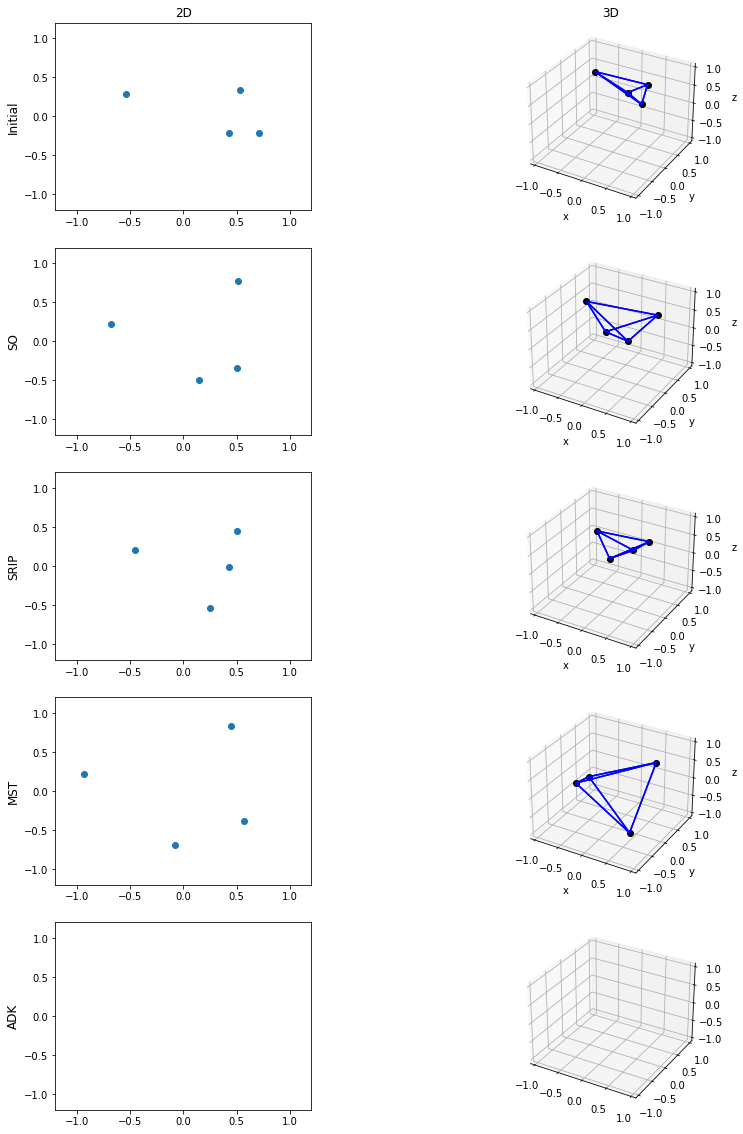

In [46]:
fig = plt.figure(figsize=(13, 20))

spec = gridspec.GridSpec(ncols=3, nrows=5, width_ratios=[3, 0.5, 4])

ax = fig.add_subplot(spec[0])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1.detach().cpu().numpy()[:, 0], W1.detach().cpu().numpy()[:, 1])
ax.set_title('2D')
ax.set_ylabel('Initial', size='large')

ax = fig.add_subplot(spec[2], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
ax.set_title('3D')
pts = W1.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))


####################
ax = fig.add_subplot(spec[3])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1_so.detach().cpu().numpy()[:, 0], W1_so.detach().cpu().numpy()[:, 1])
ax.set_ylabel('SO', size='large')

ax = fig.add_subplot(spec[5], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)

pts = W1_so.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    
###################
ax = fig.add_subplot(spec[6])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1_srip.detach().cpu().numpy()[:, 0], W1_srip.detach().cpu().numpy()[:, 1])
ax.set_ylabel('SRIP', size='large')

ax = fig.add_subplot(spec[8], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)

pts = W1_srip.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))

##################
ax = fig.add_subplot(spec[9])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1_mst.detach().cpu().numpy()[:, 0], W1_mst.detach().cpu().numpy()[:, 1])
ax.set_ylabel('MST', size='large')

ax = fig.add_subplot(spec[11], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)

pts = W1_mst.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    
#######################
ax = fig.add_subplot(spec[12])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1_adk.detach().cpu().numpy()[:, 0], W1_adk.detach().cpu().numpy()[:, 1])
ax.set_ylabel('ADK', size='large')

ax = fig.add_subplot(spec[14], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)

pts = W1_adk.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    

fig.tight_layout()
plt.show()

## 8

In [ ]:
W1 = torch.randn(8, 3).cuda()
W1 /= torch.norm(W1, dim=1, keepdim=True)
W1.requires_grad_()
with torch.no_grad():
    Norm = torch.norm(W1, dim=1)
    norm = torch.mean(Norm).item()
    mean, Min, Max = angle_analysis(W1)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')

In [ ]:
stime = time()
stime = time()
print('SO')
lamd1 = 0.01
# lamd2 = 0.01
w1 = copy.deepcopy(W1)
W1_so = torch.nn.Parameter(w1)
opt = optim.SGD([W1_so], lr=1)
for i in range(1000):
    loss = SO(W1_so)
    loss = lamd1*loss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_so, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_so)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')
print(time() - stime)

stime = time()
print('SRIP')
lamd1 = 0.01
# lamd2 = 0.01
w1 = copy.deepcopy(W1)
W1_srip = torch.nn.Parameter(w1)
opt = optim.SGD([W1_srip], lr=1)
for i in range(1000):
    loss = SRIP(W1_srip)
    loss = lamd1*loss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_srip, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_srip)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')
print(time() - stime)

stime = time()
print('MST')
lamd1 = 0.1
lamd2 = 0.01
w1 = copy.deepcopy(W1)
W1_mst = torch.nn.Parameter(w1)
opt = optim.SGD([W1_mst], lr=1)
for i in range(1000):
    nloss, tloss = MST(W1_mst)
    loss = lamd1*nloss + lamd2*tloss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_mst, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_mst)
    print(f'{norm:.2f}, {mean.item():.4f}, {Min.item():.4f}, {Max.item():.4f}')
print(time() - stime)

stime = time()
print('ADK')
lamd1 = 0.1
lamd2 = 0.01
w1 = copy.deepcopy(W1)
W1_adk = torch.nn.Parameter(w1)
opt = optim.SGD([W1_adk], lr=1)
for i in range(1000):
    nloss, tloss = ADK(W1_adk, theta=70.53*np.pi/180)
    loss = lamd1*nloss + lamd2*tloss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_adk, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_adk)
    print(f'{norm:.2f}, {mean.item():.4f}, {Min.item():.4f}, {Max.item():.4f}')
print(time() - stime)

In [ ]:
fig = plt.figure(figsize=(13, 20))

spec = gridspec.GridSpec(ncols=3, nrows=5, width_ratios=[3, 0.5, 4])

ax = fig.add_subplot(spec[0])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1.detach().cpu().numpy()[:, 0], W1.detach().cpu().numpy()[:, 1])
ax.set_title('2D')
ax.set_ylabel('Initial', size='large')

ax = fig.add_subplot(spec[2], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
ax.set_title('3D')
pts = W1.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))


####################
ax = fig.add_subplot(spec[3])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1_so.detach().cpu().numpy()[:, 0], W1_so.detach().cpu().numpy()[:, 1])
ax.set_ylabel('SO', size='large')

ax = fig.add_subplot(spec[5], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)

pts = W1_so.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    
###################
ax = fig.add_subplot(spec[6])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1_srip.detach().cpu().numpy()[:, 0], W1_srip.detach().cpu().numpy()[:, 1])
ax.set_ylabel('SRIP', size='large')

ax = fig.add_subplot(spec[8], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)

pts = W1_srip.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))

##################
ax = fig.add_subplot(spec[9])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1_mst.detach().cpu().numpy()[:, 0], W1_mst.detach().cpu().numpy()[:, 1])
ax.set_ylabel('MST', size='large')

ax = fig.add_subplot(spec[11], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)

pts = W1_mst.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    
#######################
ax = fig.add_subplot(spec[12])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1_adk.detach().cpu().numpy()[:, 0], W1_adk.detach().cpu().numpy()[:, 1])
ax.set_ylabel('ADK', size='large')

ax = fig.add_subplot(spec[14], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)

pts = W1_adk.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    

fig.tight_layout()
plt.show()

## 12

In [47]:
W1_12 = torch.randn(12, 3).cuda()
W1_12 /= torch.norm(W1_12, dim=1, keepdim=True)
W1_12.requires_grad_()
with torch.no_grad():
    Norm = torch.norm(W1_12, dim=1)
    norm = torch.mean(Norm).item()
    mean, Min, Max = angle_analysis(W1_12)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')

1.00, 0.48, 0.27, 0.78


In [ ]:
stime = time()
stime = time()
print('SO')
lamd1 = 0.01
# lamd2 = 0.01
w1 = copy.deepcopy(W1_12)
W1_so_12 = torch.nn.Parameter(w1)
opt = optim.SGD([W1_so_12], lr=1)
for i in range(1000):
    loss = SO(W1_so_12)
    loss = lamd1*loss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_so_12, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_so_12)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')
print(time() - stime)

stime = time()
print('SRIP')
lamd1 = 0.01
# lamd2 = 0.01
w1 = copy.deepcopy(W1_12)
W1_srip_12 = torch.nn.Parameter(w1)
opt = optim.SGD([W1_srip_12], lr=1)
for i in range(1000):
    loss = SRIP(W1_srip_12)
    loss = lamd1*loss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_srip_12, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_srip_12)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')
print(time() - stime)

stime = time()
print('MST')
lamd1 = 0.1
lamd2 = 0.01
w1 = copy.deepcopy(W1_12)
W1_mst_12 = torch.nn.Parameter(w1)
opt = optim.SGD([W1_mst_12], lr=1)
for i in range(1000):
    nloss, tloss = MST(W1_mst_12)
    loss = lamd1*nloss + lamd2*tloss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_mst_12, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_mst_12)
    print(f'{norm:.2f}, {mean.item():.4f}, {Min.item():.4f}, {Max.item():.4f}')
print(time() - stime)

In [50]:
stime = time()
print('ADK')
lamd1 = 0.1
lamd2 = 0.01
w1 = copy.deepcopy(W1_12)
W1_adk_12 = torch.nn.Parameter(w1)
opt = optim.SGD([W1_adk_12], lr=1)
for i in range(1000):
    nloss, tloss = ADK(W1_adk_12, theta=1.1065)
    loss = lamd1*nloss + lamd2*tloss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_adk_12, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_adk_12)
    print(f'{norm:.2f}, {mean.item():.4f}, {Min.item():.4f}, {Max.item():.4f}')
print(time() - stime)

ADK
0.91, 0.5250, 0.3393, 0.7836
0.89, 0.5766, 0.4143, 0.7902
0.89, 0.6249, 0.4849, 0.8024
0.90, 0.6668, 0.5458, 0.8176
0.92, 0.7020, 0.5947, 0.8297
0.93, 0.7318, 0.6340, 0.8395
0.94, 0.7568, 0.6659, 0.8478
0.95, 0.7782, 0.6921, 0.8551
0.96, 0.7969, 0.7144, 0.8624
0.96, 0.8135, 0.7340, 0.8863
0.97, 0.8258, 0.7505, 0.8874
0.97, 0.8348, 0.7653, 0.8866
0.97, 0.8417, 0.7786, 0.8864
0.97, 0.8467, 0.7863, 0.8920
0.97, 0.8510, 0.7882, 0.9064
0.97, 0.8555, 0.7912, 0.9193
0.97, 0.8598, 0.7937, 0.9316
0.97, 0.8641, 0.7968, 0.9436
0.98, 0.8682, 0.8004, 0.9537
0.98, 0.8724, 0.8034, 0.9640
0.98, 0.8764, 0.8071, 0.9734
0.98, 0.8803, 0.8105, 0.9824
0.98, 0.8844, 0.8145, 0.9908
0.98, 0.8879, 0.8178, 0.9985
0.98, 0.8912, 0.8216, 1.0060
0.98, 0.8943, 0.8252, 1.0127
0.98, 0.8975, 0.8291, 1.0190
0.98, 0.9004, 0.8325, 1.0257
0.98, 0.9032, 0.8364, 1.0312
0.98, 0.9060, 0.8398, 1.0370
0.98, 0.9087, 0.8431, 1.0421
0.98, 0.9113, 0.8463, 1.0471
0.98, 0.9140, 0.8499, 1.0515
0.98, 0.9161, 0.8530, 1.0519
0.98, 0.91

1.00, 1.0933, 1.0911, 1.0952
1.00, 1.0935, 1.0914, 1.0957
1.00, 1.0936, 1.0914, 1.0958
1.00, 1.0938, 1.0916, 1.0960
1.00, 1.0939, 1.0919, 1.0959
1.00, 1.0941, 1.0920, 1.0961
1.00, 1.0943, 1.0923, 1.0964
1.00, 1.0945, 1.0925, 1.0964
1.00, 1.0946, 1.0926, 1.0968
1.00, 1.0948, 1.0929, 1.0967
1.00, 1.0948, 1.0927, 1.0967
1.00, 1.0951, 1.0932, 1.0971
1.00, 1.0952, 1.0932, 1.0971
1.00, 1.0954, 1.0937, 1.0972
1.00, 1.0955, 1.0936, 1.0973
1.00, 1.0957, 1.0937, 1.0974
1.00, 1.0958, 1.0942, 1.0976
1.00, 1.0960, 1.0942, 1.0978
1.00, 1.0961, 1.0943, 1.0976
1.00, 1.0962, 1.0946, 1.0980
1.00, 1.0963, 1.0948, 1.0978
1.00, 1.0965, 1.0947, 1.0982
1.00, 1.0967, 1.0950, 1.0982
1.00, 1.0968, 1.0952, 1.0984
1.00, 1.0969, 1.0954, 1.0983
1.00, 1.0970, 1.0953, 1.0986
1.00, 1.0971, 1.0957, 1.0985
1.00, 1.0973, 1.0958, 1.0991
1.00, 1.0974, 1.0959, 1.0988
1.00, 1.0976, 1.0962, 1.0989
1.00, 1.0976, 1.0963, 1.0992
1.00, 1.0978, 1.0963, 1.0990
1.00, 1.0978, 1.0966, 1.0992
1.00, 1.0980, 1.0965, 1.0994
1.00, 1.0981, 

1.00, 1.1063, 1.1061, 1.1064
1.00, 1.1063, 1.1061, 1.1064
1.00, 1.1063, 1.1062, 1.1064
1.00, 1.1063, 1.1062, 1.1064
1.00, 1.1063, 1.1061, 1.1064
1.00, 1.1063, 1.1063, 1.1064
1.00, 1.1063, 1.1061, 1.1064
1.00, 1.1063, 1.1062, 1.1064
1.00, 1.1063, 1.1062, 1.1064
1.00, 1.1063, 1.1063, 1.1064
1.00, 1.1063, 1.1061, 1.1064
1.00, 1.1063, 1.1061, 1.1064
1.00, 1.1063, 1.1061, 1.1065
1.00, 1.1063, 1.1063, 1.1065
1.00, 1.1064, 1.1063, 1.1065
1.00, 1.1063, 1.1061, 1.1064
1.00, 1.1063, 1.1061, 1.1064
1.00, 1.1063, 1.1060, 1.1064
1.00, 1.1063, 1.1063, 1.1064
1.00, 1.1063, 1.1061, 1.1064
1.00, 1.1063, 1.1063, 1.1066
1.00, 1.1064, 1.1063, 1.1064
1.00, 1.1064, 1.1063, 1.1065
1.00, 1.1063, 1.1063, 1.1064
1.00, 1.1064, 1.1063, 1.1065
1.00, 1.1063, 1.1062, 1.1064
1.00, 1.1063, 1.1063, 1.1064
1.00, 1.1064, 1.1062, 1.1064
1.00, 1.1063, 1.1062, 1.1064
1.00, 1.1064, 1.1063, 1.1065
1.00, 1.1063, 1.1061, 1.1064
1.00, 1.1064, 1.1062, 1.1064
1.00, 1.1064, 1.1063, 1.1065
1.00, 1.1064, 1.1063, 1.1065
1.00, 1.1064, 

1.00, 1.1065, 1.1062, 1.1067
1.00, 1.1064, 1.1064, 1.1065
1.00, 1.1064, 1.1062, 1.1067
1.00, 1.1064, 1.1064, 1.1065
1.00, 1.1065, 1.1064, 1.1066
1.00, 1.1064, 1.1062, 1.1065
1.00, 1.1065, 1.1064, 1.1066
1.00, 1.1065, 1.1064, 1.1066
1.00, 1.1065, 1.1064, 1.1066
1.00, 1.1065, 1.1064, 1.1065
1.00, 1.1065, 1.1063, 1.1067
1.00, 1.1065, 1.1064, 1.1066
1.00, 1.1065, 1.1064, 1.1066
1.00, 1.1064, 1.1063, 1.1065
1.00, 1.1065, 1.1064, 1.1067
1.00, 1.1065, 1.1064, 1.1066
1.00, 1.1065, 1.1064, 1.1067
1.00, 1.1064, 1.1064, 1.1065
1.00, 1.1065, 1.1064, 1.1066
1.00, 1.1065, 1.1064, 1.1066
1.00, 1.1065, 1.1064, 1.1067
1.00, 1.1065, 1.1064, 1.1065
3.1079230308532715


ValueError: Points cannot contain NaN

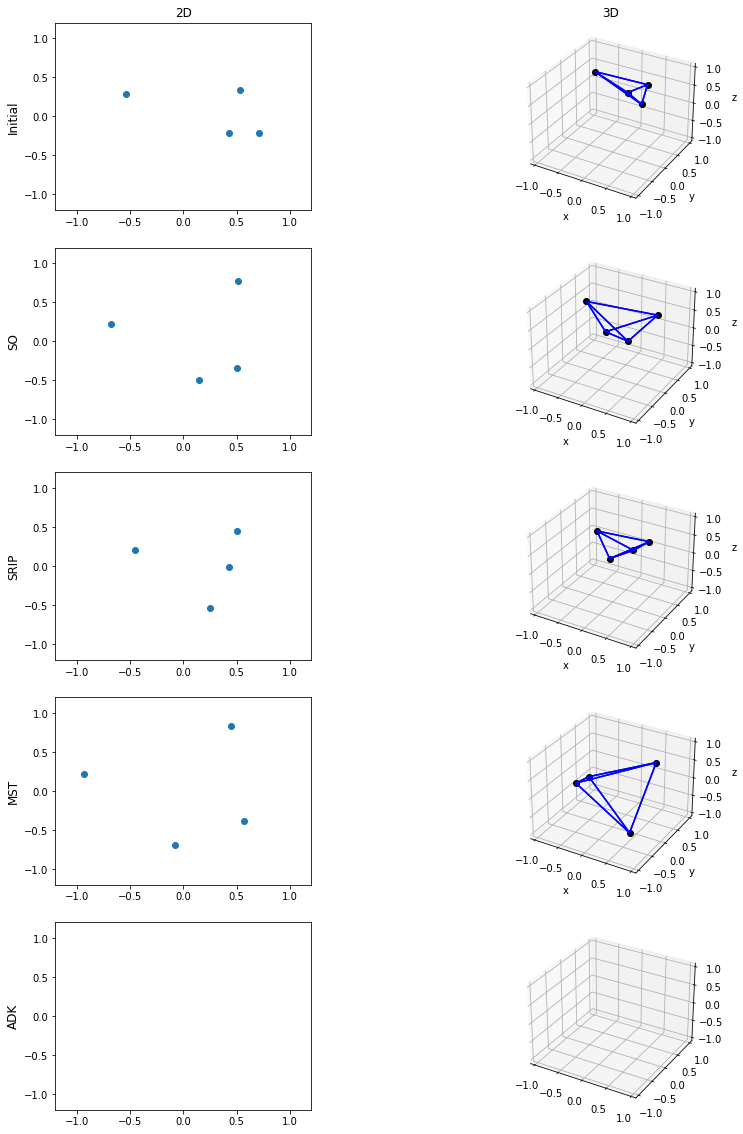

In [51]:
fig = plt.figure(figsize=(13, 20))

spec = gridspec.GridSpec(ncols=3, nrows=5, width_ratios=[3, 0.5, 4])

ax = fig.add_subplot(spec[0])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1.detach().cpu().numpy()[:, 0], W1.detach().cpu().numpy()[:, 1])
ax.set_title('2D')
ax.set_ylabel('Initial', size='large')

ax = fig.add_subplot(spec[2], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
ax.set_title('3D')
pts = W1.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))


####################
ax = fig.add_subplot(spec[3])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1_so.detach().cpu().numpy()[:, 0], W1_so.detach().cpu().numpy()[:, 1])
ax.set_ylabel('SO', size='large')

ax = fig.add_subplot(spec[5], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)

pts = W1_so.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    
###################
ax = fig.add_subplot(spec[6])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1_srip.detach().cpu().numpy()[:, 0], W1_srip.detach().cpu().numpy()[:, 1])
ax.set_ylabel('SRIP', size='large')

ax = fig.add_subplot(spec[8], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)

pts = W1_srip.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))

##################
ax = fig.add_subplot(spec[9])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1_mst.detach().cpu().numpy()[:, 0], W1_mst.detach().cpu().numpy()[:, 1])
ax.set_ylabel('MST', size='large')

ax = fig.add_subplot(spec[11], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)

pts = W1_mst.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    
#######################
ax = fig.add_subplot(spec[12])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1_adk.detach().cpu().numpy()[:, 0], W1_adk.detach().cpu().numpy()[:, 1])
ax.set_ylabel('ADK', size='large')

ax = fig.add_subplot(spec[14], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)

pts = W1_adk.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    

fig.tight_layout()
plt.show()

## 20

In [87]:
W1_20 = torch.randn(20, 3).cuda()
W1_20 /= torch.norm(W1_20, dim=1, keepdim=True)
W1_20.requires_grad_()
with torch.no_grad():
    Norm = torch.norm(W1_20, dim=1)
    norm = torch.mean(Norm).item()
    mean, Min, Max = angle_analysis(W1_20)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')

1.00, 0.44, 0.10, 1.03


In [88]:
stime = time()
print('SO')
lamd1 = 0.01
# lamd2 = 0.01
w1 = copy.deepcopy(W1_20)
W1_so_20 = torch.nn.Parameter(w1)
opt = optim.SGD([W1_so_20], lr=1)
for i in range(1000):
    loss = SO(W1_so_20)
    loss = lamd1*loss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_so_20, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_so_20)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')
print(time() - stime)

stime = time()
print('SRIP')
lamd1 = 0.01
# lamd2 = 0.01
w1 = copy.deepcopy(W1_20)
W1_srip_20 = torch.nn.Parameter(w1)
opt = optim.SGD([W1_srip_20], lr=1)
for i in range(1000):
    loss = SRIP(W1_srip_20)
    loss = lamd1*loss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_srip_20, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_srip_20)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')
print(time() - stime)

stime = time()
print('MST')
lamd1 = 0.1
lamd2 = 0.01
w1 = copy.deepcopy(W1_20)
W1_mst_20 = torch.nn.Parameter(w1)
opt = optim.SGD([W1_mst_20], lr=1)
for i in range(1000):
    nloss, tloss = MST(W1_mst_20)
    loss = lamd1*nloss + lamd2*tloss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_mst_20, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_mst_20)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')
print(time() - stime)

stime = time()
print('ADK')
lamd1 = 0.1
lamd2 = 0.01
w1 = copy.deepcopy(W1_20)
W1_adk_20 = torch.nn.Parameter(w1)
opt = optim.SGD([W1_adk_20], lr=1)
for i in range(1000):
    nloss, tloss = ADK(W1_adk_20, theta=0.73)
    loss = lamd1*nloss + lamd2*tloss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_adk_20, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_adk_20)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')
print(time() - stime)

SO
0.76, 0.45, 0.11, 1.01
0.67, 0.45, 0.11, 1.00
0.62, 0.45, 0.11, 0.99
0.58, 0.45, 0.12, 0.99
0.55, 0.45, 0.11, 0.99
0.53, 0.45, 0.11, 0.98
0.51, 0.45, 0.11, 0.98
0.49, 0.45, 0.12, 0.98
0.48, 0.45, 0.12, 0.98
0.47, 0.45, 0.12, 0.98
0.46, 0.45, 0.12, 0.98
0.45, 0.45, 0.12, 0.98
0.45, 0.45, 0.12, 0.98
0.44, 0.45, 0.11, 0.98
0.44, 0.45, 0.11, 0.98
0.43, 0.45, 0.12, 0.98
0.43, 0.45, 0.11, 0.98
0.42, 0.45, 0.12, 0.98
0.42, 0.45, 0.12, 0.98
0.42, 0.45, 0.12, 0.98
0.41, 0.45, 0.12, 0.98
0.41, 0.45, 0.12, 0.98
0.41, 0.45, 0.12, 0.98
0.41, 0.45, 0.12, 0.98
0.41, 0.45, 0.11, 0.98
0.40, 0.45, 0.11, 0.98
0.40, 0.45, 0.12, 0.98
0.40, 0.45, 0.12, 0.98
0.40, 0.45, 0.11, 0.98
0.40, 0.45, 0.11, 0.98
0.40, 0.45, 0.12, 0.98
0.40, 0.45, 0.12, 0.98
0.40, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.11, 0.98
0.39, 0.45, 0.11, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.11, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.

0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45,

0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45, 0.11, 0.98
0.39, 0.45, 0.12, 0.98
0.39, 0.45,

0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.40, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.40, 0.08, 0.86
0.50, 0.40, 0.08, 0.86
0.50, 0.40, 0.08, 0.86
0.50, 0.40, 0.08, 0.86
0.50, 0.40, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.40, 0.08, 0.86
0.50, 0.41, 0.07, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.07, 0.86
0.50, 0.40, 0.07, 0.86
0.50, 0.40, 0.07, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.40, 0.07, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.40, 0.07, 0.86
0.50, 0.41, 0.07, 0.86
0.50, 0.40, 0.07, 0.86
0.50, 0.40, 0.07, 0.86
0.50, 0.40, 0.08, 0.86
0.50, 0.40, 0.07, 0.86
0.50, 0.40, 0.07, 0.86
0.50, 0.40, 0.08, 0.86
0.50, 0.40, 0.08, 0.86
0.50, 0.40, 0.07, 0.86
0.50, 0.40, 0.07, 0.86
0.50, 0.40, 0.07, 0.86
0.50, 0.40, 0.07, 0.86
0.50, 0.40, 0.07, 0.86
0.50, 0.40, 0.07, 0.86
0.50, 0.40,

0.50, 0.41, 0.08, 0.87
0.50, 0.41, 0.08, 0.87
0.50, 0.41, 0.08, 0.87
0.50, 0.41, 0.08, 0.87
0.50, 0.41, 0.08, 0.87
0.50, 0.41, 0.08, 0.87
0.50, 0.41, 0.08, 0.87
0.50, 0.41, 0.08, 0.87
0.50, 0.41, 0.08, 0.87
0.50, 0.41, 0.08, 0.87
0.50, 0.41, 0.08, 0.87
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.87
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.87
0.50, 0.41, 0.08, 0.87
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.08, 0.86
0.50, 0.41, 0.07, 0.86
0.50, 0.41, 0.07, 0.86
0.50, 0.41,

0.50, 0.41, 0.09, 0.85
0.50, 0.41, 0.09, 0.85
0.50, 0.41, 0.09, 0.85
0.50, 0.41, 0.09, 0.85
0.50, 0.41, 0.09, 0.85
0.50, 0.41, 0.09, 0.85
0.50, 0.41, 0.09, 0.85
0.50, 0.41, 0.09, 0.85
0.50, 0.41, 0.09, 0.85
0.50, 0.41, 0.09, 0.85
0.50, 0.41, 0.09, 0.85
0.50, 0.41, 0.09, 0.85
0.50, 0.41, 0.09, 0.85
0.50, 0.41, 0.09, 0.84
0.50, 0.41, 0.09, 0.84
3.2514967918395996
MST
1.00, 0.45, 0.10, 1.04
1.01, 0.45, 0.10, 1.05
1.01, 0.46, 0.10, 1.07
1.01, 0.47, 0.11, 1.08
1.01, 0.47, 0.11, 1.09
1.01, 0.48, 0.12, 1.11
1.01, 0.49, 0.13, 1.12
1.01, 0.49, 0.14, 1.14
1.01, 0.50, 0.15, 1.15
1.01, 0.51, 0.17, 1.16
1.01, 0.52, 0.19, 1.16
1.01, 0.53, 0.21, 1.16
1.01, 0.53, 0.22, 1.16
1.01, 0.54, 0.24, 1.15
1.01, 0.55, 0.26, 1.16
1.01, 0.56, 0.28, 1.16
1.01, 0.57, 0.29, 1.15
1.01, 0.57, 0.32, 1.14
1.01, 0.58, 0.32, 1.15
1.01, 0.59, 0.33, 1.15
1.01, 0.60, 0.34, 1.15
1.01, 0.60, 0.34, 1.14
1.01, 0.61, 0.35, 1.14
1.01, 0.61, 0.35, 1.14
1.01, 0.62, 0.36, 1.14
1.01, 0.62, 0.37, 1.13
1.01, 0.63, 0.38, 1.13
1.01, 0.63,

1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.82
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.80, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.82, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82,

1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.82
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.82, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.82
1.01, 0.82, 0.82, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.84
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.80, 0.83
1.01, 0.82,

1.00, 0.72, 0.70, 0.78
1.00, 0.72, 0.71, 0.78
1.00, 0.72, 0.71, 0.78
1.00, 0.72, 0.71, 0.78
1.00, 0.72, 0.71, 0.78
1.00, 0.72, 0.71, 0.78
1.00, 0.72, 0.71, 0.78
1.00, 0.72, 0.71, 0.78
1.00, 0.72, 0.71, 0.78
1.00, 0.72, 0.71, 0.78
1.00, 0.72, 0.71, 0.78
1.00, 0.72, 0.71, 0.78
1.00, 0.72, 0.71, 0.78
1.00, 0.72, 0.71, 0.78
1.00, 0.72, 0.71, 0.77
1.00, 0.72, 0.71, 0.77
1.00, 0.72, 0.71, 0.77
1.00, 0.72, 0.71, 0.77
1.00, 0.72, 0.71, 0.77
1.00, 0.72, 0.71, 0.77
1.00, 0.72, 0.71, 0.77
1.00, 0.72, 0.71, 0.77
1.00, 0.72, 0.71, 0.77
1.00, 0.72, 0.71, 0.77
1.00, 0.72, 0.71, 0.77
1.00, 0.72, 0.71, 0.77
1.00, 0.72, 0.71, 0.77
1.00, 0.72, 0.72, 0.77
1.00, 0.72, 0.72, 0.77
1.00, 0.72, 0.72, 0.77
1.00, 0.72, 0.72, 0.77
1.00, 0.72, 0.72, 0.77
1.00, 0.72, 0.72, 0.77
1.00, 0.73, 0.72, 0.77
1.00, 0.73, 0.72, 0.77
1.00, 0.73, 0.72, 0.77
1.00, 0.73, 0.72, 0.77
1.00, 0.73, 0.72, 0.77
1.00, 0.73, 0.72, 0.77
1.00, 0.73, 0.72, 0.77
1.00, 0.73, 0.72, 0.77
1.00, 0.73, 0.72, 0.77
1.00, 0.73, 0.72, 0.77
1.00, 0.73,

1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73,

1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73, 0.73, 0.76
1.00, 0.73,

ValueError: Points cannot contain NaN

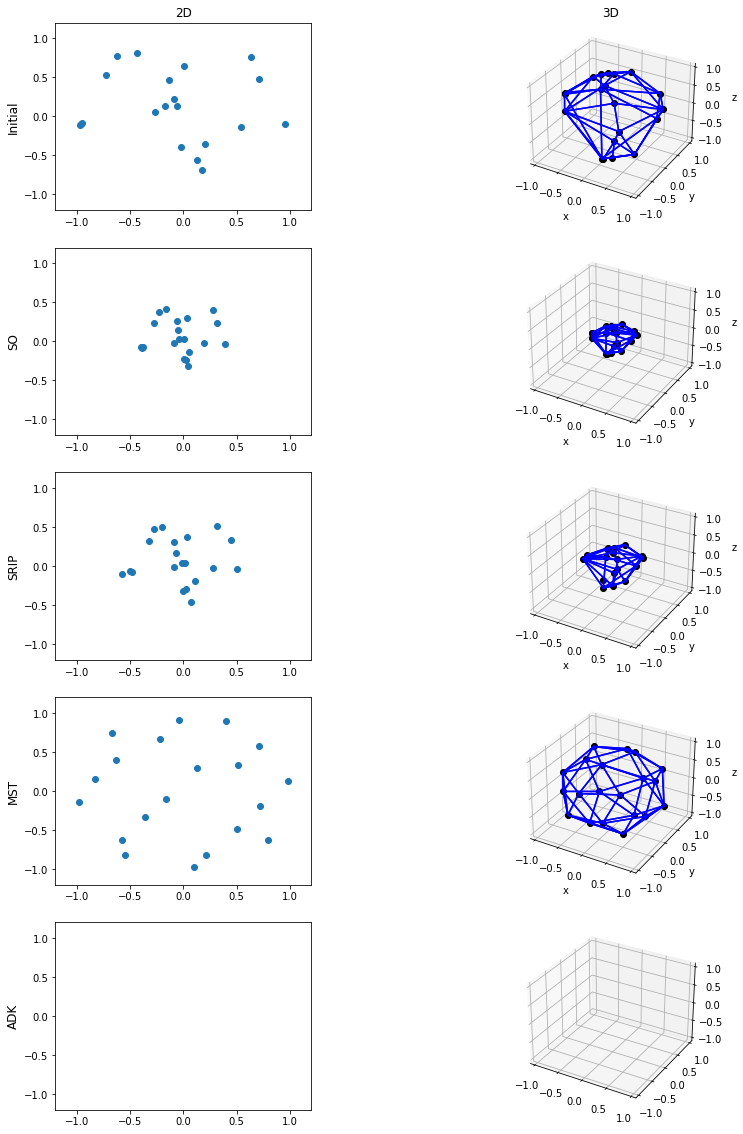

In [83]:
fig = plt.figure(figsize=(13, 20))

spec = gridspec.GridSpec(ncols=3, nrows=5, width_ratios=[3, 0.5, 4])

ax = fig.add_subplot(spec[0])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1_20.detach().cpu().numpy()[:, 0], W1_20.detach().cpu().numpy()[:, 1])
ax.set_title('2D')
ax.set_ylabel('Initial', size='large')

ax = fig.add_subplot(spec[2], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
ax.set_title('3D')
pts = W1_20.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))


####################
ax = fig.add_subplot(spec[3])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1_so_20.detach().cpu().numpy()[:, 0], W1_so_20.detach().cpu().numpy()[:, 1])
ax.set_ylabel('SO', size='large')

ax = fig.add_subplot(spec[5], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)

pts = W1_so_20.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    
###################
ax = fig.add_subplot(spec[6])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1_srip_20.detach().cpu().numpy()[:, 0], W1_srip_20.detach().cpu().numpy()[:, 1])
ax.set_ylabel('SRIP', size='large')

ax = fig.add_subplot(spec[8], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)

pts = W1_srip_20.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))

##################
ax = fig.add_subplot(spec[9])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1_mst_20.detach().cpu().numpy()[:, 0], W1_mst_20.detach().cpu().numpy()[:, 1])
ax.set_ylabel('MST', size='large')

ax = fig.add_subplot(spec[11], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)

pts = W1_mst_20.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    
#######################
ax = fig.add_subplot(spec[12])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1_adk_20.detach().cpu().numpy()[:, 0], W1_adk_20.detach().cpu().numpy()[:, 1])
ax.set_ylabel('ADK', size='large')

ax = fig.add_subplot(spec[14], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)

pts = W1_adk_20.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    

fig.tight_layout()
plt.show()

## 60

In [90]:
W1_60 = torch.randn(60, 3).cuda()
W1_60 /= torch.norm(W1_60, dim=1, keepdim=True)
W1_60.requires_grad_()
with torch.no_grad():
    Norm = torch.norm(W1_60, dim=1)
    norm = torch.mean(Norm).item()
    mean, Min, Max = angle_analysis(W1_60)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')

1.00, 0.22, 0.05, 0.47


In [91]:
stime = time()
print('SO')
lamd1 = 0.01
# lamd2 = 0.01
w1 = copy.deepcopy(W1_60)
W1_so_60 = torch.nn.Parameter(w1)
opt = optim.SGD([W1_so_60], lr=1)
for i in range(1000):
    loss = SO(W1_so_60)
    loss = lamd1*loss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_so_60, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_so_60)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')
print(time() - stime)

stime = time()
print('SRIP')
lamd1 = 0.001
# lamd2 = 0.01
w1 = copy.deepcopy(W1_60)
W1_srip_60 = torch.nn.Parameter(w1)
opt = optim.SGD([W1_srip_60], lr=1)
for i in range(1000):
    loss = SRIP(W1_srip_60)
    loss = lamd1*loss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_srip_60, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_srip_60)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')
print(time() - stime)

stime = time()
print('MST')
lamd1 = 0.1
lamd2 = 0.01
w1 = copy.deepcopy(W1_60)
W1_mst_60 = torch.nn.Parameter(w1)
opt = optim.SGD([W1_mst_60], lr=1)
for i in range(1000):
    nloss, tloss = MST(W1_mst_60)
    loss = lamd1*nloss + lamd2*tloss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_mst_60, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_mst_60)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')
print(time() - stime)

stime = time()
print('ADK')
lamd1 = 0.1
lamd2 = 0.01
w1 = copy.deepcopy(W1_60)
W1_adk_60 = torch.nn.Parameter(w1)
opt = optim.SGD([W1_adk_60], lr=1)
for i in range(1000):
    nloss, tloss = ADK(W1_adk_60, theta=0.44)
    loss = lamd1*nloss + lamd2*tloss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_adk_60, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_adk_60)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')
print(time() - stime)

SO
0.24, 0.21, 0.06, 0.39
0.24, 0.22, 0.06, 0.39
0.23, 0.22, 0.06, 0.40
0.23, 0.22, 0.05, 0.40
0.23, 0.22, 0.06, 0.39
0.23, 0.22, 0.06, 0.39
0.23, 0.22, 0.06, 0.39
0.22, 0.22, 0.06, 0.40
0.22, 0.22, 0.06, 0.40
0.22, 0.22, 0.06, 0.41
0.22, 0.22, 0.05, 0.41
0.22, 0.22, 0.05, 0.41
0.22, 0.22, 0.06, 0.41
0.22, 0.22, 0.06, 0.41
0.22, 0.22, 0.06, 0.41
0.22, 0.22, 0.05, 0.40
0.22, 0.22, 0.06, 0.40
0.22, 0.22, 0.05, 0.41
0.22, 0.22, 0.06, 0.41
0.22, 0.22, 0.05, 0.41
0.22, 0.22, 0.06, 0.42
0.22, 0.22, 0.05, 0.42
0.22, 0.22, 0.06, 0.42
0.22, 0.22, 0.05, 0.42
0.22, 0.22, 0.06, 0.43
0.22, 0.22, 0.06, 0.43
0.22, 0.22, 0.06, 0.43
0.22, 0.22, 0.06, 0.43
0.22, 0.22, 0.06, 0.43
0.22, 0.22, 0.06, 0.43
0.22, 0.22, 0.06, 0.44
0.22, 0.22, 0.05, 0.44
0.22, 0.22, 0.05, 0.44
0.22, 0.22, 0.06, 0.44
0.22, 0.22, 0.06, 0.44
0.22, 0.22, 0.06, 0.44
0.22, 0.22, 0.05, 0.44
0.22, 0.22, 0.05, 0.44
0.22, 0.22, 0.05, 0.44
0.22, 0.22, 0.05, 0.44
0.22, 0.22, 0.06, 0.44
0.22, 0.22, 0.05, 0.44
0.22, 0.22, 0.06, 0.45
0.22, 0.

0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22,

0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.05, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22, 0.06, 0.45
0.22, 0.22,

0.40, 0.22, 0.07, 0.47
0.40, 0.22, 0.07, 0.47
0.40, 0.22, 0.07, 0.47
0.40, 0.22, 0.07, 0.47
0.40, 0.22, 0.07, 0.47
0.40, 0.22, 0.07, 0.47
0.40, 0.22, 0.07, 0.47
0.40, 0.22, 0.07, 0.47
0.40, 0.22, 0.07, 0.47
0.40, 0.22, 0.07, 0.47
0.40, 0.22, 0.07, 0.47
0.40, 0.22, 0.08, 0.47
0.40, 0.22, 0.07, 0.47
0.40, 0.22, 0.07, 0.47
0.40, 0.22, 0.07, 0.47
0.40, 0.22, 0.07, 0.47
0.40, 0.22, 0.07, 0.47
0.40, 0.22, 0.07, 0.47
0.40, 0.22, 0.07, 0.47
0.40, 0.22, 0.07, 0.47
0.40, 0.22, 0.07, 0.47
0.39, 0.22, 0.07, 0.47
0.39, 0.22, 0.07, 0.47
0.39, 0.22, 0.07, 0.47
0.39, 0.22, 0.07, 0.47
0.39, 0.22, 0.07, 0.46
0.39, 0.22, 0.07, 0.46
0.39, 0.22, 0.07, 0.46
0.39, 0.22, 0.07, 0.46
0.39, 0.22, 0.07, 0.46
0.39, 0.22, 0.07, 0.46
0.39, 0.22, 0.07, 0.46
0.39, 0.22, 0.07, 0.46
0.39, 0.22, 0.07, 0.46
0.39, 0.22, 0.07, 0.46
0.39, 0.22, 0.07, 0.46
0.39, 0.22, 0.07, 0.46
0.39, 0.22, 0.07, 0.46
0.39, 0.22, 0.07, 0.46
0.39, 0.22, 0.07, 0.46
0.39, 0.22, 0.07, 0.46
0.39, 0.22, 0.07, 0.46
0.39, 0.22, 0.07, 0.46
0.39, 0.22,

0.34, 0.22, 0.08, 0.47
0.34, 0.22, 0.07, 0.47
0.34, 0.22, 0.07, 0.47
0.34, 0.22, 0.08, 0.47
0.34, 0.22, 0.07, 0.47
0.34, 0.22, 0.07, 0.47
0.34, 0.22, 0.07, 0.47
0.34, 0.22, 0.07, 0.47
0.34, 0.22, 0.08, 0.47
0.34, 0.22, 0.08, 0.47
0.34, 0.22, 0.07, 0.47
0.34, 0.22, 0.07, 0.47
0.34, 0.22, 0.07, 0.47
0.34, 0.22, 0.08, 0.47
0.34, 0.22, 0.07, 0.47
0.34, 0.22, 0.07, 0.47
0.34, 0.22, 0.07, 0.47
0.34, 0.22, 0.07, 0.47
0.34, 0.22, 0.07, 0.47
0.34, 0.22, 0.08, 0.47
0.34, 0.22, 0.08, 0.47
0.34, 0.22, 0.07, 0.47
0.34, 0.22, 0.07, 0.47
0.34, 0.22, 0.07, 0.47
0.34, 0.22, 0.07, 0.47
0.34, 0.22, 0.07, 0.47
0.34, 0.22, 0.08, 0.47
0.34, 0.22, 0.07, 0.47
0.34, 0.22, 0.07, 0.47
0.34, 0.22, 0.07, 0.47
0.34, 0.22, 0.07, 0.47
0.34, 0.22, 0.07, 0.47
0.34, 0.22, 0.07, 0.47
0.34, 0.22, 0.08, 0.47
0.34, 0.22, 0.08, 0.47
0.34, 0.22, 0.08, 0.47
0.34, 0.22, 0.08, 0.47
0.34, 0.22, 0.07, 0.47
0.34, 0.22, 0.07, 0.47
0.34, 0.22, 0.08, 0.47
0.34, 0.22, 0.08, 0.47
0.34, 0.22, 0.07, 0.47
0.34, 0.22, 0.07, 0.47
0.34, 0.22,

0.32, 0.22, 0.08, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.08, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.08, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.08, 0.47
0.32, 0.22, 0.08, 0.47
0.32, 0.22, 0.08, 0.47
0.32, 0.22, 0.08, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.08, 0.47
0.32, 0.22, 0.08, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.08, 0.47
0.32, 0.22, 0.07, 0.47
0.32, 0.22, 0.08, 0.47
0.32, 0.22,

1.01, 0.47, 0.44, 0.49
1.01, 0.47, 0.44, 0.49
1.01, 0.47, 0.44, 0.49
1.01, 0.47, 0.44, 0.49
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.44, 0.48
1.01, 0.47, 0.44, 0.49
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.44, 0.49
1.01, 0.47, 0.44, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.44, 0.48
1.01, 0.47, 0.44, 0.49
1.01, 0.47, 0.44, 0.49
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.44, 0.49
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.44, 0.48
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.44, 0.49
1.01, 0.47, 0.45, 0.48
1.01, 0.46, 0.44, 0.48
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.46, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.46, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47,

1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.46, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.46, 0.49
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.46, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.46, 0.48
1.01, 0.47, 0.46, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.46, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.46, 0.48
1.01, 0.47, 0.46, 0.49
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.46, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47,

nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, na

nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, nan, nan
nan, nan, na

In [ ]:
fig = plt.figure(figsize=(13, 20))

spec = gridspec.GridSpec(ncols=3, nrows=5, width_ratios=[3, 0.5, 4])

ax = fig.add_subplot(spec[0])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1.detach().cpu().numpy()[:, 0], W1.detach().cpu().numpy()[:, 1])
ax.set_title('2D')
ax.set_ylabel('Initial', size='large')

ax = fig.add_subplot(spec[2], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
ax.set_title('3D')
pts = W1.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))


####################
ax = fig.add_subplot(spec[3])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1_so.detach().cpu().numpy()[:, 0], W1_so.detach().cpu().numpy()[:, 1])
ax.set_ylabel('SO', size='large')

ax = fig.add_subplot(spec[5], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)

pts = W1_so.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    
###################
ax = fig.add_subplot(spec[6])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1_srip.detach().cpu().numpy()[:, 0], W1_srip.detach().cpu().numpy()[:, 1])
ax.set_ylabel('SRIP', size='large')

ax = fig.add_subplot(spec[8], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)

pts = W1_srip.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))

##################
ax = fig.add_subplot(spec[9])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1_mst.detach().cpu().numpy()[:, 0], W1_mst.detach().cpu().numpy()[:, 1])
ax.set_ylabel('MST', size='large')

ax = fig.add_subplot(spec[11], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)

pts = W1_mst.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    
#######################
ax = fig.add_subplot(spec[12])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1_adk.detach().cpu().numpy()[:, 0], W1_adk.detach().cpu().numpy()[:, 1])
ax.set_ylabel('ADK', size='large')

ax = fig.add_subplot(spec[14], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)

pts = W1_adk.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    

fig.tight_layout()
plt.show()

## 6/12/20/60

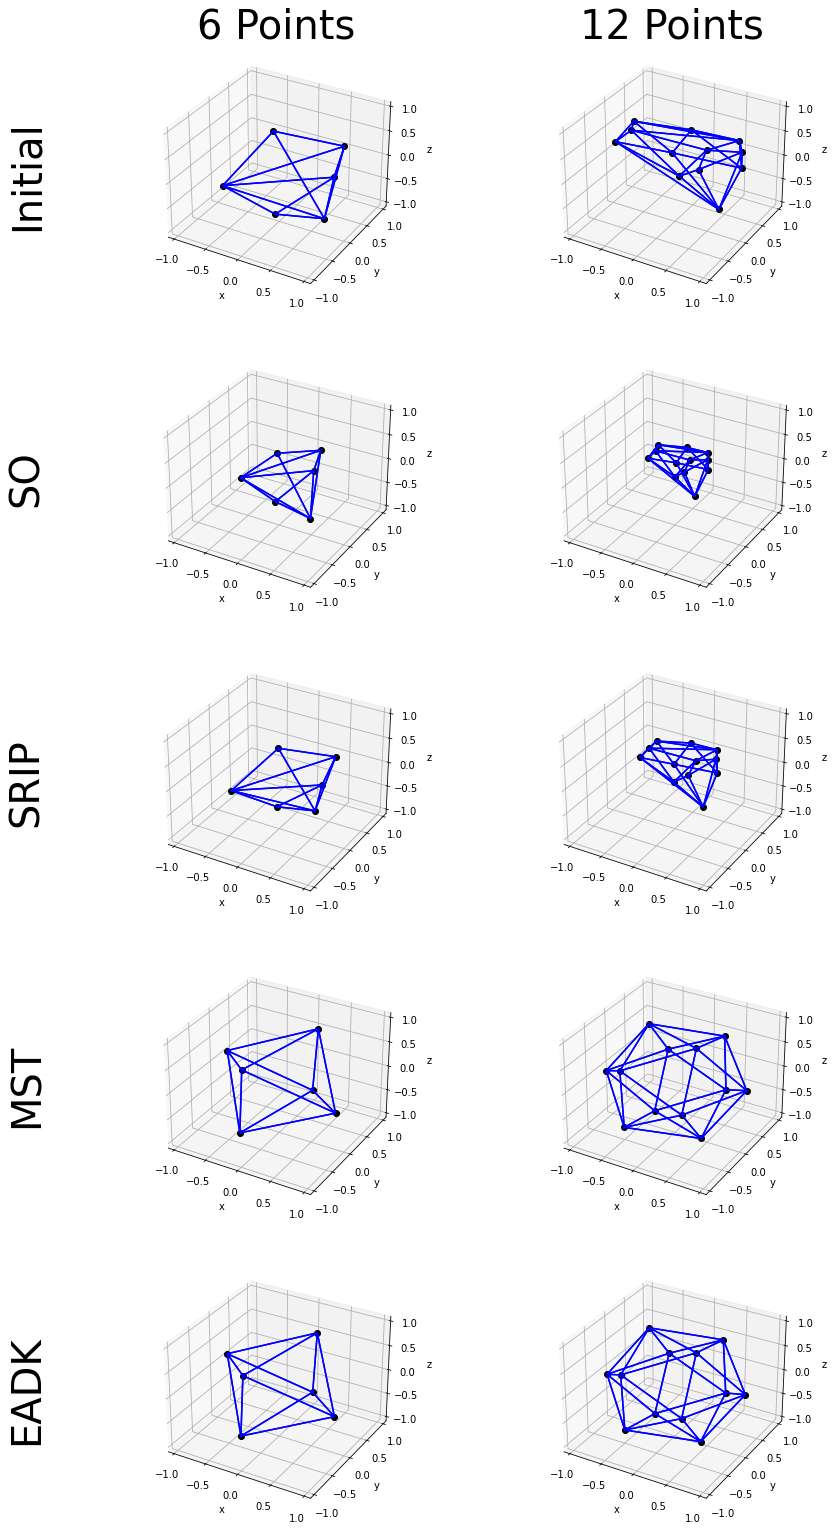

In [56]:
fig = plt.figure(figsize=(13, 27))

spec = gridspec.GridSpec(ncols=2, nrows=5, width_ratios=[3, 3])


pad = 5



ax = fig.add_subplot(spec[0], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
ax.set_title('6 Points', size=40)
pts = W1_6.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
ax.annotate('Initial', xy=(-80, -2), xytext=(-ax.zaxis.labelpad - pad, 0),
                xycoords=ax.zaxis.label, textcoords='offset points',
                size=40, ha='left', va='center', rotation=90)



ax = fig.add_subplot(spec[1], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
ax.set_title('12 Points', size=40)
pts = W1_12.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))


# ####################

ax = fig.add_subplot(spec[2], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
pts = W1_so_6.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
ax.annotate('SO', xy=(-80, -2), xytext=(-ax.zaxis.labelpad - pad, 0),
                xycoords=ax.zaxis.label, textcoords='offset points',
                size=40, ha='left', va='center', rotation=90)



ax = fig.add_subplot(spec[3], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
pts = W1_so_12.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    
# ###################

ax = fig.add_subplot(spec[4], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
pts = W1_srip_6.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
ax.annotate('SRIP', xy=(-80, -2), xytext=(-ax.zaxis.labelpad - pad, 0),
                xycoords=ax.zaxis.label, textcoords='offset points',
                size=40, ha='left', va='center', rotation=90)



ax = fig.add_subplot(spec[5], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
pts = W1_srip_12.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))

# ##################


ax = fig.add_subplot(spec[6], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
pts = W1_mst_6.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
ax.annotate('MST', xy=(-80, -2), xytext=(-ax.zaxis.labelpad - pad, 0),
                xycoords=ax.zaxis.label, textcoords='offset points',
                size=40, ha='left', va='center', rotation=90)



ax = fig.add_subplot(spec[7], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
pts = W1_mst_12.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    
# #######################

ax = fig.add_subplot(spec[8], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
pts = W1_adk_6.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
ax.annotate('EADK', xy=(-80, -2), xytext=(-ax.zaxis.labelpad - pad, 0),
                xycoords=ax.zaxis.label, textcoords='offset points',
                size=40, ha='left', va='center', rotation=90)



ax = fig.add_subplot(spec[9], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
pts = W1_adk_12.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    
# fig.tight_layout()
plt.show()

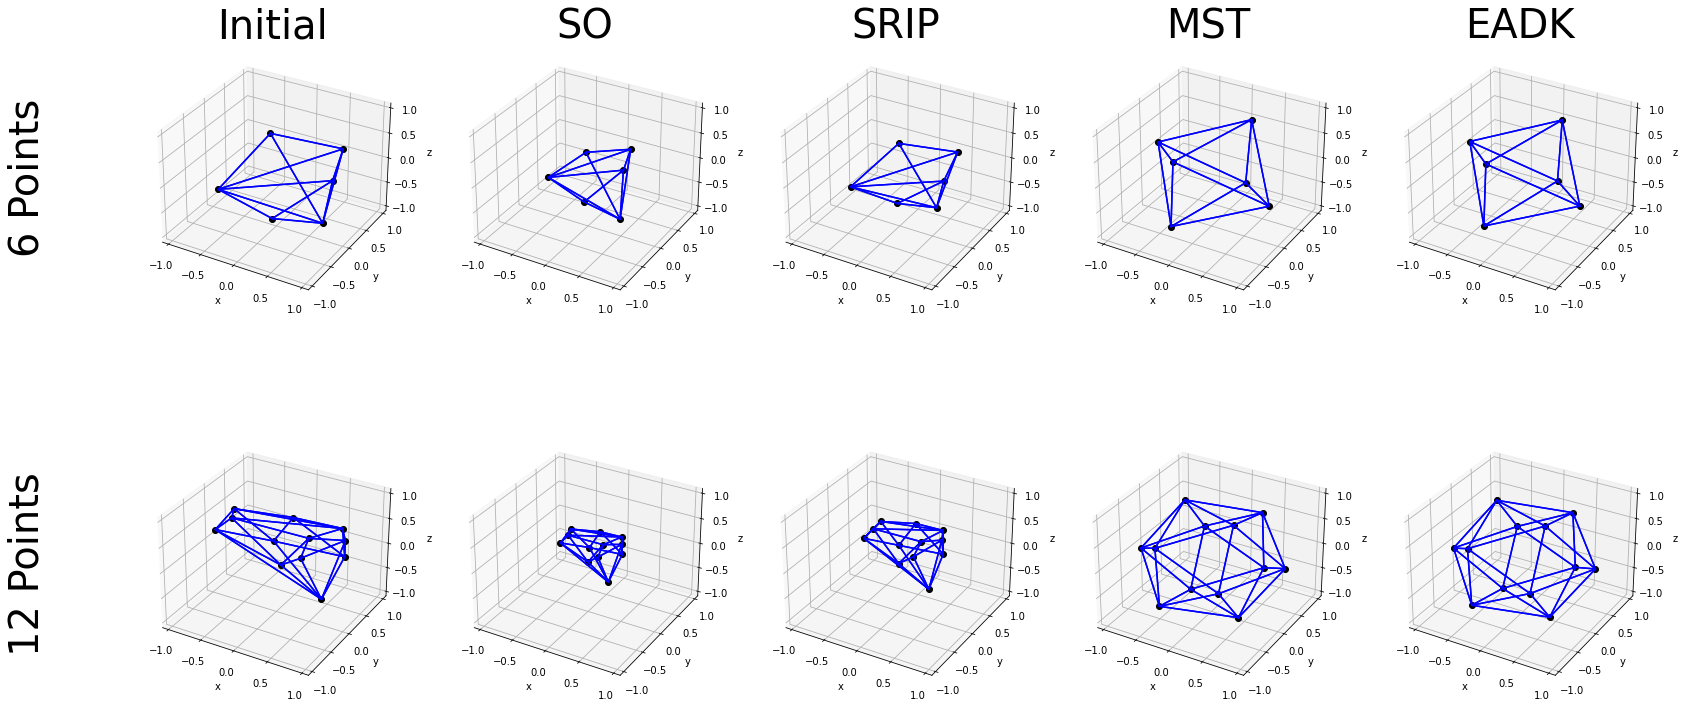

In [59]:
fig = plt.figure(figsize=(27, 13))

spec = gridspec.GridSpec(ncols=5, nrows=2)


pad = 5



ax = fig.add_subplot(spec[0], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
ax.set_title('Initial', size=40)
pts = W1_6.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
ax.annotate('6 Points', xy=(-80, -2), xytext=(-ax.zaxis.labelpad - pad, 0),
                xycoords=ax.zaxis.label, textcoords='offset points',
                size=40, ha='left', va='center', rotation=90)



ax = fig.add_subplot(spec[5], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
# ax.set_title('12 Points', size=40)
pts = W1_12.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
ax.annotate('12 Points', xy=(-80, -2), xytext=(-ax.zaxis.labelpad - pad, 0),
                xycoords=ax.zaxis.label, textcoords='offset points',
                size=40, ha='left', va='center', rotation=90)

# ####################

ax = fig.add_subplot(spec[1], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
ax.set_title('SO', size=40)
pts = W1_so_6.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
# ax.annotate('SO', xy=(-80, -2), xytext=(-ax.zaxis.labelpad - pad, 0),
#                 xycoords=ax.zaxis.label, textcoords='offset points',
#                 size=40, ha='left', va='center', rotation=90)



ax = fig.add_subplot(spec[6], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
pts = W1_so_12.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    
# ###################

ax = fig.add_subplot(spec[2], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
ax.set_title('SRIP', size=40)
pts = W1_srip_6.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
# ax.annotate('SRIP', xy=(-80, -2), xytext=(-ax.zaxis.labelpad - pad, 0),
#                 xycoords=ax.zaxis.label, textcoords='offset points',
#                 size=40, ha='left', va='center', rotation=90)



ax = fig.add_subplot(spec[7], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
pts = W1_srip_12.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))

# ##################


ax = fig.add_subplot(spec[3], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
ax.set_title('MST', size=40)
pts = W1_mst_6.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
# ax.annotate('MST', xy=(-80, -2), xytext=(-ax.zaxis.labelpad - pad, 0),
#                 xycoords=ax.zaxis.label, textcoords='offset points',
#                 size=40, ha='left', va='center', rotation=90)



ax = fig.add_subplot(spec[8], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
pts = W1_mst_12.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    
# #######################

ax = fig.add_subplot(spec[4], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
ax.set_title('EADK', size=40)
pts = W1_adk_6.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
# ax.annotate('EADK', xy=(-80, -2), xytext=(-ax.zaxis.labelpad - pad, 0),
#                 xycoords=ax.zaxis.label, textcoords='offset points',
#                 size=40, ha='left', va='center', rotation=90)



ax = fig.add_subplot(spec[9], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
pts = W1_adk_12.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    
# fig.tight_layout()
plt.show()

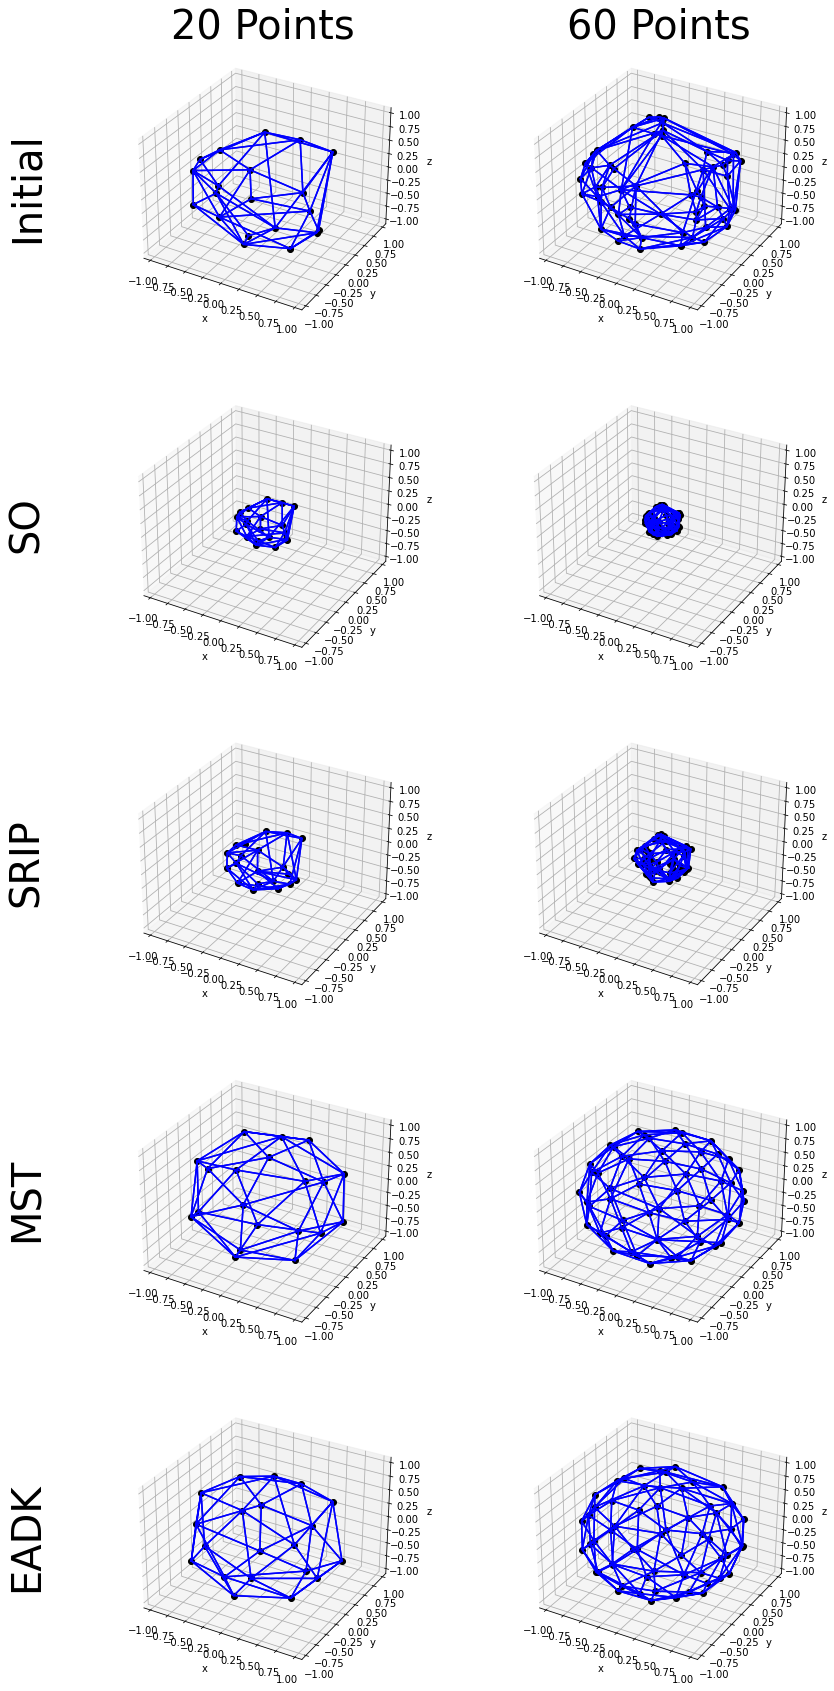

In [688]:
fig = plt.figure(figsize=(13, 30))

spec = gridspec.GridSpec(ncols=2, nrows=5, width_ratios=[3, 3])


pad = 5



ax = fig.add_subplot(spec[0], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
ax.set_title('20 Points', size=40)
pts = W1_20.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
ax.annotate('Initial', xy=(-80, -2), xytext=(-ax.zaxis.labelpad - pad, 0),
                xycoords=ax.zaxis.label, textcoords='offset points',
                size=40, ha='left', va='center', rotation=90)



ax = fig.add_subplot(spec[1], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
ax.set_title('60 Points', size=40)
pts = W1_60.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))


# ####################

ax = fig.add_subplot(spec[2], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
pts = W1_so_20.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
ax.annotate('SO', xy=(-80, -2), xytext=(-ax.zaxis.labelpad - pad, 0),
                xycoords=ax.zaxis.label, textcoords='offset points',
                size=40, ha='left', va='center', rotation=90)



ax = fig.add_subplot(spec[3], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
pts = W1_so_60.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    
# ###################

ax = fig.add_subplot(spec[4], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
pts = W1_srip_20.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
ax.annotate('SRIP', xy=(-80, -2), xytext=(-ax.zaxis.labelpad - pad, 0),
                xycoords=ax.zaxis.label, textcoords='offset points',
                size=40, ha='left', va='center', rotation=90)



ax = fig.add_subplot(spec[5], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
pts = W1_srip_60.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))

# ##################


ax = fig.add_subplot(spec[6], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
pts = W1_mst_20.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
ax.annotate('MST', xy=(-80, -2), xytext=(-ax.zaxis.labelpad - pad, 0),
                xycoords=ax.zaxis.label, textcoords='offset points',
                size=40, ha='left', va='center', rotation=90)



ax = fig.add_subplot(spec[7], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
pts = W1_mst_60.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    
# #######################

ax = fig.add_subplot(spec[8], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
pts = W1_adk_20.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
ax.annotate('EADK', xy=(-80, -2), xytext=(-ax.zaxis.labelpad - pad, 0),
                xycoords=ax.zaxis.label, textcoords='offset points',
                size=40, ha='left', va='center', rotation=90)



ax = fig.add_subplot(spec[9], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
pts = W1_adk_60.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    
# fig.tight_layout()
plt.show()

ValueError: Points cannot contain NaN

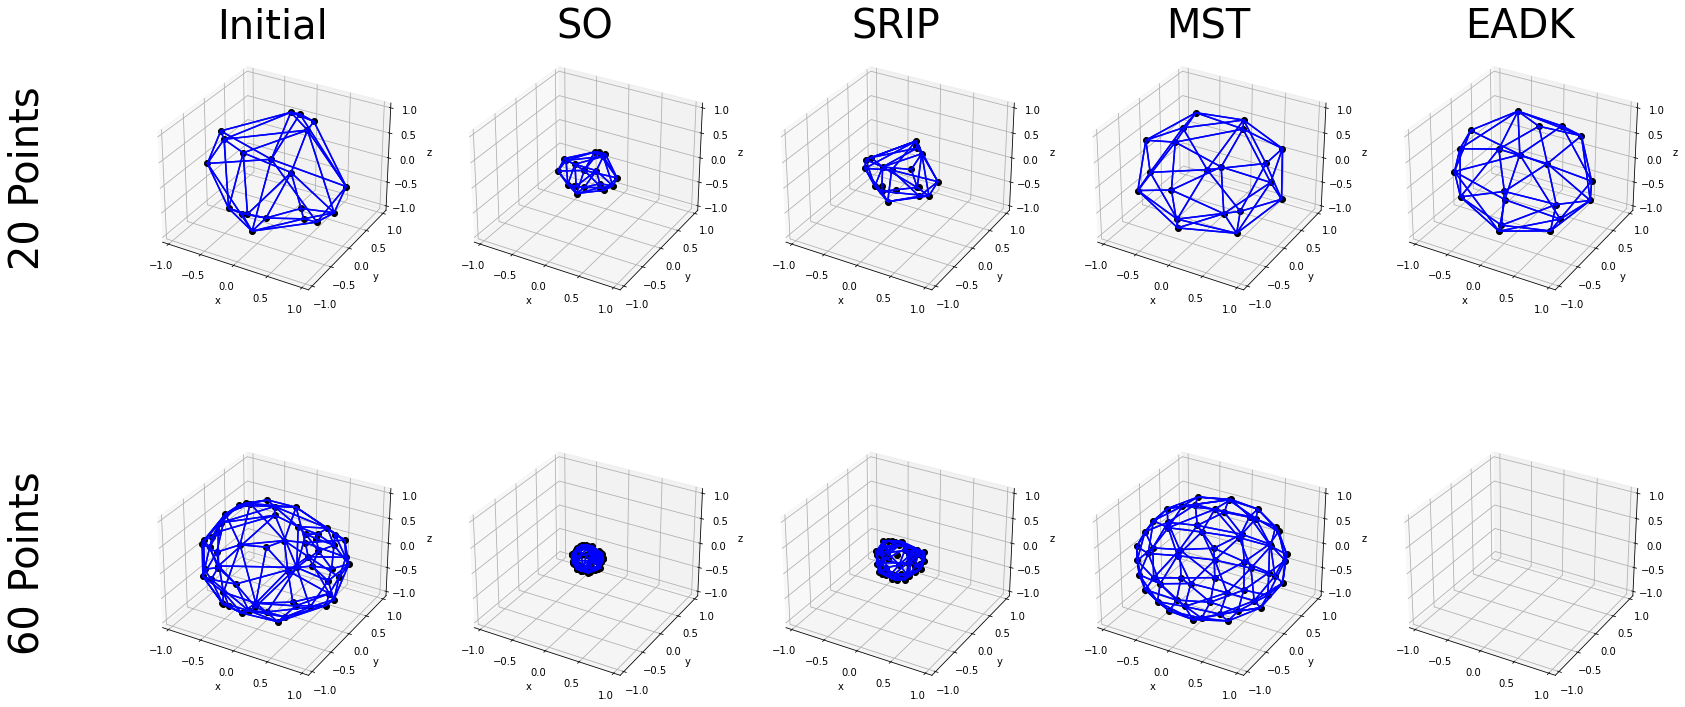

In [92]:
fig = plt.figure(figsize=(27, 13))

spec = gridspec.GridSpec(ncols=5, nrows=2)


pad = 5



ax = fig.add_subplot(spec[0], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
ax.set_title('Initial', size=40)
pts = W1_20.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
ax.annotate('20 Points', xy=(-80, -2), xytext=(-ax.zaxis.labelpad - pad, 0),
                xycoords=ax.zaxis.label, textcoords='offset points',
                size=40, ha='left', va='center', rotation=90)



ax = fig.add_subplot(spec[5], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
# ax.set_title('12 Points', size=40)
pts = W1_60.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
ax.annotate('60 Points', xy=(-80, -2), xytext=(-ax.zaxis.labelpad - pad, 0),
                xycoords=ax.zaxis.label, textcoords='offset points',
                size=40, ha='left', va='center', rotation=90)

# ####################

ax = fig.add_subplot(spec[1], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
ax.set_title('SO', size=40)
pts = W1_so_20.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
# ax.annotate('SO', xy=(-80, -2), xytext=(-ax.zaxis.labelpad - pad, 0),
#                 xycoords=ax.zaxis.label, textcoords='offset points',
#                 size=40, ha='left', va='center', rotation=90)



ax = fig.add_subplot(spec[6], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
pts = W1_so_60.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    
# ###################

ax = fig.add_subplot(spec[2], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
ax.set_title('SRIP', size=40)
pts = W1_srip_20.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
# ax.annotate('SRIP', xy=(-80, -2), xytext=(-ax.zaxis.labelpad - pad, 0),
#                 xycoords=ax.zaxis.label, textcoords='offset points',
#                 size=40, ha='left', va='center', rotation=90)



ax = fig.add_subplot(spec[7], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
pts = W1_srip_60.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))

# ##################


ax = fig.add_subplot(spec[3], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
ax.set_title('MST', size=40)
pts = W1_mst_20.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
# ax.annotate('MST', xy=(-80, -2), xytext=(-ax.zaxis.labelpad - pad, 0),
#                 xycoords=ax.zaxis.label, textcoords='offset points',
#                 size=40, ha='left', va='center', rotation=90)



ax = fig.add_subplot(spec[8], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
pts = W1_mst_60.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    
# #######################

ax = fig.add_subplot(spec[4], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
ax.set_title('EADK', size=40)
pts = W1_adk_20.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
# ax.annotate('EADK', xy=(-80, -2), xytext=(-ax.zaxis.labelpad - pad, 0),
#                 xycoords=ax.zaxis.label, textcoords='offset points',
#                 size=40, ha='left', va='center', rotation=90)



ax = fig.add_subplot(spec[9], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
pts = W1_adk_60.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    
# fig.tight_layout()
plt.show()

## theta 연구

In [437]:
W1 = torch.randn(12, 3).cuda()
W1 /= torch.norm(W1, dim=1, keepdim=True)
W1.requires_grad_()
with torch.no_grad():
    Norm = torch.norm(W1, dim=1)
    norm = torch.mean(Norm).item()
    mean, Min, Max = angle_analysis(W1)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')

1.00, 0.56, 0.21, 1.18


In [438]:
print('ADK')
lamd1 = 0.1
lamd2 = 0.01
w1 = copy.deepcopy(W1)
W1_1 = torch.nn.Parameter(w1)
opt = optim.SGD([W1_1], lr=1)
for i in range(1000):
    nloss, tloss = ADK(W1_1, theta=0.75)
    loss = lamd1*nloss + lamd2*tloss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_1, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_1)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')

ADK
0.97, 0.57, 0.25, 1.17
0.96, 0.59, 0.30, 1.17
0.97, 0.60, 0.35, 1.16
0.97, 0.62, 0.39, 1.16
0.98, 0.63, 0.42, 1.15
0.98, 0.64, 0.45, 1.15
0.98, 0.65, 0.47, 1.14
0.98, 0.66, 0.49, 1.14
0.99, 0.67, 0.51, 1.14
0.99, 0.67, 0.53, 1.13
0.99, 0.68, 0.55, 1.13
0.99, 0.69, 0.56, 1.12
0.99, 0.69, 0.57, 1.12
0.99, 0.70, 0.59, 1.12
0.99, 0.70, 0.60, 1.12
0.99, 0.71, 0.61, 1.11
0.99, 0.71, 0.61, 1.11
0.99, 0.71, 0.62, 1.11
0.99, 0.72, 0.63, 1.11
0.99, 0.72, 0.64, 1.10
0.99, 0.72, 0.64, 1.10
0.99, 0.73, 0.65, 1.10
0.99, 0.73, 0.65, 1.10
0.99, 0.73, 0.66, 1.10
0.99, 0.73, 0.66, 1.09
1.00, 0.73, 0.67, 1.09
1.00, 0.74, 0.67, 1.09
1.00, 0.74, 0.68, 1.09
1.00, 0.74, 0.68, 1.09
1.00, 0.74, 0.68, 1.09
1.00, 0.74, 0.69, 1.09
1.00, 0.74, 0.69, 1.08
1.00, 0.74, 0.69, 1.08
1.00, 0.75, 0.69, 1.08
1.00, 0.75, 0.70, 1.08
1.00, 0.75, 0.70, 1.08
1.00, 0.75, 0.70, 1.08
1.00, 0.75, 0.70, 1.08
1.00, 0.75, 0.70, 1.08
1.00, 0.75, 0.71, 1.08
1.00, 0.75, 0.71, 1.08
1.00, 0.75, 0.71, 1.08
1.00, 0.75, 0.71, 1.07
1.00, 0

1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78,

1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78, 0.75, 1.06
1.00, 0.78,

In [439]:
print('ADK')
lamd1 = 0.1
lamd2 = 0.01
w1 = copy.deepcopy(W1)
W1_2 = torch.nn.Parameter(w1)
opt = optim.SGD([W1_2], lr=1)
for i in range(1000):
    nloss, tloss = ADK(W1_2, theta=0.925)
    loss = lamd1*nloss + lamd2*tloss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_2, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_2)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')

ADK
0.94, 0.58, 0.27, 1.17
0.93, 0.61, 0.34, 1.15
0.94, 0.63, 0.40, 1.14
0.94, 0.65, 0.45, 1.13
0.95, 0.67, 0.49, 1.12
0.96, 0.68, 0.52, 1.11
0.96, 0.70, 0.55, 1.10
0.97, 0.71, 0.58, 1.09
0.97, 0.72, 0.60, 1.08
0.97, 0.73, 0.62, 1.07
0.97, 0.74, 0.64, 1.06
0.98, 0.75, 0.65, 1.05
0.98, 0.76, 0.66, 1.05
0.98, 0.76, 0.68, 1.04
0.98, 0.77, 0.69, 1.03
0.98, 0.78, 0.70, 1.03
0.98, 0.78, 0.71, 1.02
0.98, 0.79, 0.72, 1.02
0.98, 0.79, 0.72, 1.01
0.98, 0.79, 0.73, 1.01
0.98, 0.80, 0.74, 1.01
0.99, 0.80, 0.74, 1.00
0.99, 0.81, 0.75, 1.00
0.99, 0.81, 0.75, 0.99
0.99, 0.81, 0.76, 0.99
0.99, 0.82, 0.76, 0.99
0.99, 0.82, 0.77, 0.99
0.99, 0.82, 0.77, 0.98
0.99, 0.83, 0.78, 0.98
0.99, 0.83, 0.78, 0.98
0.99, 0.83, 0.78, 0.98
0.99, 0.83, 0.78, 0.97
0.99, 0.83, 0.79, 0.97
0.99, 0.84, 0.79, 0.97
0.99, 0.84, 0.79, 0.97
0.99, 0.84, 0.79, 0.97
0.99, 0.84, 0.79, 0.97
0.99, 0.84, 0.79, 0.97
0.99, 0.84, 0.79, 0.96
0.99, 0.85, 0.80, 0.96
0.99, 0.85, 0.80, 0.96
0.99, 0.85, 0.80, 0.96
0.99, 0.85, 0.80, 0.96
0.99, 0

1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93,

1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93, 0.92, 0.97
1.00, 0.93,

In [440]:
print('ADK')
lamd1 = 0.1
lamd2 = 0.01
w1 = copy.deepcopy(W1)
W1_3 = torch.nn.Parameter(w1)
opt = optim.SGD([W1_3], lr=1)
for i in range(1000):
    nloss, tloss = ADK(W1_3, theta=1.1)
    loss = lamd1*nloss + lamd2*tloss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_3, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_3)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')

ADK
0.92, 0.59, 0.28, 1.15
0.89, 0.63, 0.36, 1.13
0.89, 0.66, 0.44, 1.11
0.90, 0.69, 0.51, 1.08
0.92, 0.71, 0.56, 1.07
0.93, 0.73, 0.60, 1.05
0.94, 0.74, 0.63, 1.04
0.95, 0.76, 0.66, 1.03
0.95, 0.77, 0.69, 1.02
0.96, 0.78, 0.71, 1.02
0.96, 0.79, 0.73, 1.01
0.96, 0.80, 0.74, 1.01
0.96, 0.81, 0.76, 1.01
0.97, 0.82, 0.77, 1.01
0.97, 0.83, 0.77, 1.01
0.97, 0.84, 0.78, 1.01
0.97, 0.84, 0.79, 1.01
0.97, 0.85, 0.79, 1.01
0.97, 0.86, 0.79, 1.01
0.97, 0.86, 0.80, 1.02
0.97, 0.87, 0.80, 1.02
0.97, 0.87, 0.81, 1.02
0.98, 0.87, 0.81, 1.03
0.98, 0.88, 0.81, 1.03
0.98, 0.88, 0.81, 1.03
0.98, 0.89, 0.82, 1.04
0.98, 0.89, 0.82, 1.04
0.98, 0.89, 0.82, 1.04
0.98, 0.90, 0.82, 1.03
0.98, 0.90, 0.82, 1.03
0.98, 0.90, 0.82, 1.03
0.98, 0.91, 0.83, 1.03
0.98, 0.91, 0.83, 1.03
0.98, 0.91, 0.83, 1.03
0.98, 0.91, 0.83, 1.02
0.98, 0.92, 0.83, 1.02
0.98, 0.92, 0.84, 1.02
0.98, 0.92, 0.84, 1.02
0.98, 0.92, 0.84, 1.02
0.98, 0.93, 0.84, 1.02
0.98, 0.93, 0.84, 1.02
0.98, 0.93, 0.84, 1.02
0.98, 0.93, 0.84, 1.02
0.98, 0

1.00, 1.06, 1.05, 1.08
1.00, 1.06, 1.05, 1.08
1.00, 1.06, 1.05, 1.08
1.00, 1.06, 1.05, 1.08
1.00, 1.06, 1.05, 1.08
1.00, 1.06, 1.05, 1.08
1.00, 1.06, 1.05, 1.08
1.00, 1.06, 1.05, 1.08
1.00, 1.06, 1.05, 1.08
1.00, 1.06, 1.05, 1.08
1.00, 1.07, 1.05, 1.08
1.00, 1.07, 1.05, 1.08
1.00, 1.07, 1.05, 1.08
1.00, 1.07, 1.05, 1.08
1.00, 1.07, 1.05, 1.08
1.00, 1.07, 1.05, 1.08
1.00, 1.07, 1.05, 1.08
1.00, 1.07, 1.05, 1.08
1.00, 1.07, 1.06, 1.08
1.00, 1.07, 1.06, 1.08
1.00, 1.07, 1.06, 1.08
1.00, 1.07, 1.06, 1.08
1.00, 1.07, 1.06, 1.08
1.00, 1.07, 1.06, 1.08
1.00, 1.07, 1.06, 1.08
1.00, 1.07, 1.06, 1.09
1.00, 1.07, 1.06, 1.09
1.00, 1.07, 1.06, 1.09
1.00, 1.07, 1.06, 1.09
1.00, 1.07, 1.06, 1.09
1.00, 1.07, 1.06, 1.09
1.00, 1.07, 1.06, 1.09
1.00, 1.07, 1.06, 1.09
1.00, 1.07, 1.06, 1.09
1.00, 1.07, 1.06, 1.09
1.00, 1.07, 1.06, 1.09
1.00, 1.07, 1.06, 1.09
1.00, 1.07, 1.06, 1.09
1.00, 1.08, 1.06, 1.09
1.00, 1.08, 1.06, 1.09
1.00, 1.08, 1.06, 1.09
1.00, 1.08, 1.07, 1.09
1.00, 1.08, 1.07, 1.09
1.00, 1.08,

1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10, 1.10, 1.10
1.00, 1.10,

In [441]:
print('ADK')
lamd1 = 0.1
lamd2 = 0.01
w1 = copy.deepcopy(W1)
W1_4 = torch.nn.Parameter(w1)
opt = optim.SGD([W1_4], lr=1)
for i in range(1000):
    nloss, tloss = ADK(W1_4, theta=1.274)
    loss = lamd1*nloss + lamd2*tloss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_4, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_4)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')

ADK
0.88, 0.60, 0.30, 1.14
0.85, 0.65, 0.42, 1.11
0.84, 0.70, 0.52, 1.09
0.85, 0.73, 0.61, 1.08
0.87, 0.76, 0.67, 1.07
0.89, 0.78, 0.71, 1.07
0.90, 0.80, 0.72, 1.07
0.92, 0.81, 0.73, 1.08
0.93, 0.82, 0.74, 1.08
0.93, 0.83, 0.75, 1.09
0.94, 0.84, 0.75, 1.09
0.94, 0.85, 0.76, 1.10
0.95, 0.86, 0.76, 1.11
0.95, 0.86, 0.77, 1.10
0.95, 0.87, 0.77, 1.10
0.95, 0.87, 0.77, 1.10
0.95, 0.88, 0.78, 1.10
0.95, 0.89, 0.78, 1.09
0.96, 0.89, 0.79, 1.09
0.96, 0.90, 0.79, 1.09
0.96, 0.90, 0.79, 1.09
0.96, 0.91, 0.80, 1.08
0.96, 0.91, 0.80, 1.08
0.96, 0.91, 0.80, 1.08
0.96, 0.92, 0.81, 1.08
0.96, 0.92, 0.81, 1.08
0.96, 0.93, 0.82, 1.08
0.96, 0.93, 0.82, 1.08
0.96, 0.93, 0.82, 1.07
0.97, 0.94, 0.82, 1.07
0.97, 0.94, 0.83, 1.07
0.97, 0.94, 0.83, 1.07
0.97, 0.94, 0.83, 1.07
0.97, 0.95, 0.84, 1.07
0.97, 0.95, 0.84, 1.07
0.97, 0.95, 0.84, 1.07
0.97, 0.95, 0.85, 1.07
0.97, 0.96, 0.85, 1.06
0.97, 0.96, 0.85, 1.06
0.97, 0.96, 0.85, 1.06
0.97, 0.96, 0.86, 1.06
0.97, 0.96, 0.86, 1.05
0.97, 0.96, 0.86, 1.05
0.97, 0

0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11,

0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11, 1.11, 1.11
0.98, 1.11,

In [442]:
print('ADK')
lamd1 = 0.1
lamd2 = 0.01
w1 = copy.deepcopy(W1)
W1_5 = torch.nn.Parameter(w1)
opt = optim.SGD([W1_5], lr=1)
for i in range(1000):
    nloss, tloss = ADK(W1_5, theta=1.449)
    loss = lamd1*nloss + lamd2*tloss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_5, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_5)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')

ADK
0.85, 0.62, 0.33, 1.13
0.80, 0.69, 0.51, 1.10
0.78, 0.74, 0.66, 1.09
0.78, 0.79, 0.70, 1.09
0.79, 0.81, 0.72, 1.10
0.79, 0.81, 0.73, 1.12
0.80, 0.82, 0.74, 1.13
0.81, 0.81, 0.65, 1.13
0.85, 0.80, 0.58, 1.14
0.85, 0.81, 0.63, 1.14
0.85, 0.82, 0.67, 1.14
0.84, 0.83, 0.76, 0.93
0.91, 0.77, 0.42, 1.12
0.89, 0.79, 0.50, 1.13
0.88, 0.81, 0.58, 1.13
0.87, 0.83, 0.63, 1.14
0.86, 0.84, 0.66, 1.14
0.87, 0.76, 0.19, 1.00
0.92, 0.83, 0.56, 1.10
0.92, 0.85, 0.61, 1.12
0.92, 0.86, 0.65, 1.13
0.93, 0.86, 0.68, 1.13
0.93, 0.87, 0.70, 1.14
0.93, 0.88, 0.73, 1.14
0.93, 0.88, 0.74, 1.15
0.93, 0.89, 0.76, 1.15
0.93, 0.89, 0.76, 1.16
0.94, 0.90, 0.76, 1.15
0.94, 0.90, 0.76, 1.15
0.94, 0.90, 0.76, 1.14
0.94, 0.90, 0.75, 1.13
0.94, 0.90, 0.75, 1.12
0.94, 0.90, 0.76, 1.12
0.94, 0.91, 0.76, 1.11
0.94, 0.91, 0.76, 1.11
0.94, 0.91, 0.76, 1.10
0.94, 0.91, 0.76, 1.10
0.94, 0.91, 0.76, 1.09
0.94, 0.91, 0.76, 1.09
0.94, 0.91, 0.76, 1.09
0.94, 0.91, 0.77, 1.09
0.94, 0.91, 0.77, 1.09
0.94, 0.92, 0.77, 1.08
0.94, 0

0.95, 0.96, 0.92, 1.05
0.95, 0.96, 0.92, 1.05
0.95, 0.96, 0.92, 1.05
0.95, 0.96, 0.92, 1.05
0.95, 0.96, 0.92, 1.05
0.95, 0.96, 0.92, 1.05
0.95, 0.96, 0.92, 1.04
0.95, 0.96, 0.92, 1.04
0.95, 0.96, 0.92, 1.04
0.95, 0.96, 0.92, 1.04
0.95, 0.96, 0.92, 1.04
0.95, 0.96, 0.92, 1.04
0.95, 0.96, 0.92, 1.04
0.95, 0.96, 0.92, 1.04
0.95, 0.96, 0.92, 1.04
0.95, 0.96, 0.92, 1.03
0.95, 0.96, 0.92, 1.03
0.95, 0.96, 0.92, 1.03
0.95, 0.96, 0.92, 1.03
0.95, 0.96, 0.93, 1.03
0.95, 0.96, 0.93, 1.03
0.95, 0.96, 0.93, 1.03
0.95, 0.96, 0.93, 1.03
0.95, 0.96, 0.93, 1.02
0.95, 0.96, 0.93, 1.02
0.95, 0.96, 0.93, 1.02
0.95, 0.96, 0.93, 1.02
0.95, 0.96, 0.93, 1.02
0.95, 0.96, 0.93, 1.02
0.95, 0.96, 0.93, 1.02
0.95, 0.96, 0.93, 1.02
0.95, 0.96, 0.93, 1.02
0.95, 0.96, 0.93, 1.02
0.95, 0.96, 0.93, 1.01
0.95, 0.96, 0.93, 1.01
0.95, 0.96, 0.93, 1.01
0.95, 0.96, 0.93, 1.01
0.95, 0.96, 0.93, 1.01
0.95, 0.96, 0.93, 1.01
0.95, 0.96, 0.94, 1.01
0.95, 0.96, 0.94, 1.01
0.95, 0.96, 0.94, 1.01
0.95, 0.96, 0.94, 1.01
0.95, 0.96,

0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11, 1.11, 1.11
0.95, 1.11,

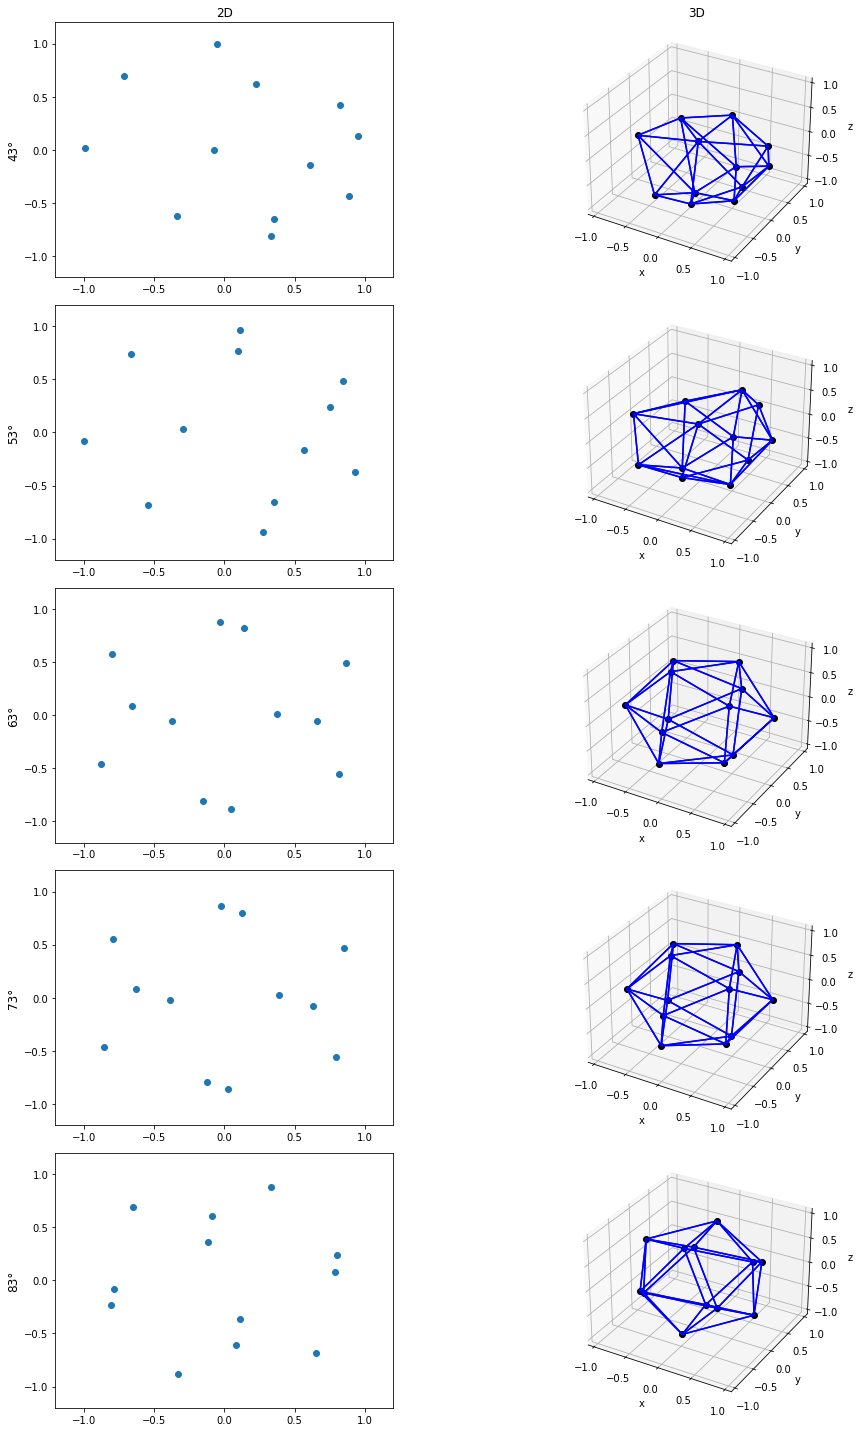

In [443]:
fig = plt.figure(figsize=(13, 20))

spec = gridspec.GridSpec(ncols=3, nrows=5, width_ratios=[3, 0.5, 4])

ax = fig.add_subplot(spec[0])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1_1.detach().cpu().numpy()[:, 0], W1_1.detach().cpu().numpy()[:, 1])
ax.set_title('2D')
ax.set_ylabel('43'+u'\xb0', size='large')

ax = fig.add_subplot(spec[2], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
ax.set_title('3D')
pts = W1_1.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))


####################
ax = fig.add_subplot(spec[3])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1_2.detach().cpu().numpy()[:, 0], W1_2.detach().cpu().numpy()[:, 1])
ax.set_ylabel('53'+u'\xb0', size='large')

ax = fig.add_subplot(spec[5], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)

pts = W1_2.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    
###################
ax = fig.add_subplot(spec[6])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1_3.detach().cpu().numpy()[:, 0], W1_3.detach().cpu().numpy()[:, 1])
ax.set_ylabel('63'+u'\xb0', size='large')

ax = fig.add_subplot(spec[8], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)

pts = W1_3.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))

##################
ax = fig.add_subplot(spec[9])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1_4.detach().cpu().numpy()[:, 0], W1_4.detach().cpu().numpy()[:, 1])
ax.set_ylabel('73'+u'\xb0', size='large')

ax = fig.add_subplot(spec[11], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)

pts = W1_4.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    
#######################
ax = fig.add_subplot(spec[12])
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.scatter(W1_5.detach().cpu().numpy()[:, 0], W1_5.detach().cpu().numpy()[:, 1])
ax.set_ylabel('83'+u'\xb0', size='large')

ax = fig.add_subplot(spec[14], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)

pts = W1_5.cpu().detach().numpy()
hull = ConvexHull(pts)

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    

fig.tight_layout()
plt.show()

In [394]:
def todegree(theta_list):
    out = []
    for t in theta_list:
        out.append(t*180/np.pi)
    print(out)

In [686]:
todegree([1.564, 1.559, 1.569, 1.571, 1.571, 1.571])

[89.61059915846074, 89.32412026089534, 89.89707805602617, 90.01166961505233, 90.01166961505233, 90.01166961505233]


In [410]:
def toradian(theta_list):
    out = []
    for t in theta_list:
        out.append(t*np.pi/180)
    print(out)

In [421]:
toradian([43, 53, 63, 73, 83])

[0.7504915783575616, 0.9250245035569946, 1.0995574287564276, 1.2740903539558606, 1.4486232791552935]


## Inferring Ideal angle

In [493]:
target_angles_12 = [60, 61, 62, 63, 64, 65, 66] # 12
target_angles_20 = [39, 40, 41, 42, 43, 44, 45] # 20

In [494]:
def infer_angle(num_points, target_angles):
    for t in target_angles:
        r = t*np.pi/180
        
        W1 = torch.randn(num_points, 3).cuda()
        W1 /= torch.norm(W1, dim=1, keepdim=True)
        W1.requires_grad_()

        lamd1 = 0.1
        lamd2 = 0.01
        W1_1 = torch.nn.Parameter(W1)
        opt = optim.SGD([W1_1], lr=1)
        for i in range(1000):
            nloss, tloss = ADK(W1_1, theta=r)
            loss = lamd1*nloss + lamd2*tloss
            opt.zero_grad()
            loss.backward()
            opt.step()
        with torch.no_grad():
            Norm = torch.norm(W1_1, dim=1)
            norm = torch.mean(Norm).item()
            mean, Min, Max = angle_analysis(W1_1)
        print(f'{t}degree: {norm:.4f}, {mean.item()*180/np.pi:.4f}, {Min.item()*180/np.pi:.4f}, {Max.item()*180/np.pi:.4f}, {Max.item()*180/np.pi-Min.item()*180/np.pi:.4f}')

In [495]:
infer_angle(12, target_angles_12)

60degree: 1.0000, 59.9968, 59.9881, 60.0055, 0.0173
61degree: 0.9984, 60.0699, 59.9339, 60.2059, 0.2721
62degree: 1.0000, 62.0023, 61.9960, 62.0127, 0.0167
63degree: 1.0000, 62.9971, 62.9916, 63.0048, 0.0133
64degree: 0.9988, 63.4558, 63.4526, 63.4605, 0.0078
65degree: 0.9966, 63.4558, 63.4521, 63.4610, 0.0089
66degree: 0.9944, 63.4533, 63.4440, 63.4605, 0.0165


In [502]:
infer_angle(12, target_angles_12)

60degree: 1.0000, 59.9929, 59.9865, 59.9995, 0.0130
61degree: 0.9999, 60.9454, 60.8889, 60.9900, 0.1010
62degree: 1.0000, 61.9998, 61.9960, 62.0065, 0.0105
63degree: 1.0000, 62.9916, 62.9780, 63.0066, 0.0286
64degree: 0.9988, 63.4532, 63.4427, 63.4604, 0.0177
65degree: 0.9966, 63.4523, 63.4382, 63.4627, 0.0245
66degree: 0.9944, 63.4557, 63.4511, 63.4613, 0.0101


In [503]:
infer_angle(12, target_angles_12)

60degree: 1.0000, 60.0117, 60.0000, 60.0732, 0.0732
61degree: 0.9999, 60.8733, 60.8146, 60.9638, 0.1491
62degree: 1.0000, 62.0130, 61.9888, 62.1282, 0.1394
63degree: 0.9999, 63.0011, 62.9946, 63.0121, 0.0175
64degree: 0.9988, 63.4521, 63.4463, 63.4644, 0.0181
65degree: 0.9966, 63.4535, 63.4423, 63.4631, 0.0208
66degree: 0.9944, 63.4537, 63.4490, 63.4577, 0.0087


In [504]:
infer_angle(12, target_angles_12)

60degree: 1.0000, 59.9950, 59.9923, 60.0031, 0.0108
61degree: 1.0000, 60.9966, 60.9922, 61.0197, 0.0275
62degree: 0.9997, 61.8496, 61.8277, 61.8759, 0.0482
63degree: 1.0000, 63.0021, 62.9934, 63.0171, 0.0237
64degree: 0.9988, 63.4555, 63.4459, 63.4639, 0.0179
65degree: 0.9966, 63.4522, 63.4457, 63.4590, 0.0134
66degree: 0.9945, 63.4567, 63.4547, 63.4616, 0.0070


In [505]:
infer_angle(12, target_angles_12)

60degree: 1.0000, 59.9960, 59.9906, 60.0024, 0.0118
61degree: 1.0000, 60.9978, 60.9901, 61.0048, 0.0147
62degree: 1.0000, 61.9987, 61.9898, 62.0099, 0.0200
63degree: 0.9999, 62.9376, 62.9188, 62.9522, 0.0333
64degree: 0.9988, 63.4566, 63.4525, 63.4599, 0.0074
65degree: 0.9966, 63.4537, 63.4444, 63.4592, 0.0147
66degree: 0.9945, 63.4522, 63.4477, 63.4631, 0.0153


In [506]:
infer_angle(12, target_angles_12)

60degree: 1.0000, 59.9953, 59.9860, 60.0113, 0.0253
61degree: nan, nan, nan, nan, nan
62degree: 1.0000, 61.9943, 61.9880, 62.0038, 0.0158
63degree: 0.9985, 61.8668, 61.8194, 62.0640, 0.2446
64degree: 0.9989, 63.4523, 63.4423, 63.4590, 0.0167
65degree: 0.9966, 63.4576, 63.4513, 63.4623, 0.0110
66degree: 0.9944, 63.4508, 63.4414, 63.4601, 0.0187


In [501]:
infer_angle(20, target_angles_20)

39degree: 1.0000, 39.0841, 38.9801, 40.7215, 1.7414
40degree: 1.0000, 40.0506, 39.9779, 40.4965, 0.5185
41degree: 1.0000, 41.0081, 40.9963, 41.0588, 0.0625
42degree: 1.0000, 42.0042, 41.9967, 42.0250, 0.0283
43degree: 1.0000, 43.0187, 42.9999, 43.1163, 0.1164
44degree: 1.0000, 44.0089, 43.9870, 44.1726, 0.1856
45degree: 1.0000, 45.0727, 44.9332, 47.1820, 2.2488


In [507]:
infer_angle(20, target_angles_20)

39degree: 1.0001, 39.3817, 39.0002, 45.5877, 6.5875
40degree: 1.0000, 41.1279, 39.9933, 51.4791, 11.4858
41degree: 1.0000, 41.1446, 40.9992, 42.4801, 1.4809
42degree: nan, nan, nan, nan, nan
43degree: 1.0000, 43.1582, 42.9710, 45.9437, 2.9727
44degree: 1.0000, 43.9382, 43.8895, 44.0104, 0.1209
45degree: 0.9998, 44.9152, 44.8005, 44.9899, 0.1894


In [508]:
infer_angle(20, target_angles_20)

39degree: 1.0000, 39.2776, 38.9988, 44.4644, 5.4655
40degree: 1.0000, 39.9996, 39.9878, 40.0159, 0.0280
41degree: 1.0000, 41.1341, 40.9963, 42.9337, 1.9374
42degree: 1.0000, 42.0007, 41.9820, 42.0430, 0.0611
43degree: 1.0000, 42.9949, 42.9727, 43.0293, 0.0565
44degree: 0.9999, 44.0390, 43.9738, 44.8407, 0.8669
45degree: 1.0000, 44.9891, 44.9719, 45.0163, 0.0444


In [509]:
infer_angle(20, target_angles_20)

39degree: 1.0000, 39.0271, 38.9883, 39.4899, 0.5016
40degree: 1.0000, 40.0068, 39.9999, 40.0252, 0.0253
41degree: nan, nan, nan, nan, nan
42degree: 1.0000, 42.1685, 41.9934, 44.3727, 2.3793
43degree: 1.0000, 43.0795, 42.9754, 44.5063, 1.5310
44degree: 1.0000, 44.1245, 43.9792, 46.5558, 2.5766
45degree: 0.9991, 44.5852, 44.3483, 44.9232, 0.5748


In [510]:
infer_angle(20, target_angles_20)

39degree: 1.0000, 39.0612, 38.9975, 39.9381, 0.9406
40degree: 1.0001, 40.0083, 39.9962, 40.0499, 0.0537
41degree: 1.0000, 40.9913, 40.9640, 41.0206, 0.0566
42degree: 1.0000, 41.9827, 41.9666, 42.0134, 0.0468
43degree: 1.0000, 42.9857, 42.9657, 42.9998, 0.0341
44degree: 1.0000, 44.0090, 43.9945, 44.0724, 0.0779
45degree: 0.9993, 44.6637, 44.4048, 44.9761, 0.5714


In [511]:
infer_angle(20, target_angles_20)

39degree: 1.0000, 39.0040, 38.9944, 39.0155, 0.0211
40degree: 1.0001, 40.2089, 39.9973, 43.2437, 3.2464
41degree: 1.0000, 41.4377, 40.9914, 46.3498, 5.3584
42degree: 1.0000, 41.9900, 41.9703, 42.0195, 0.0492
43degree: 1.0000, 43.0112, 42.9955, 43.0587, 0.0632
44degree: nan, nan, nan, nan, nan
45degree: 0.9998, 44.9041, 44.8324, 44.9840, 0.1516


57degree: 0.9632, 45.6617, 44.2917, 48.7222, 4.4304


In [131]:
W1_20 = torch.randn(20, 3).cuda()
W1_20 /= torch.norm(W1_20, dim=1, keepdim=True)
W1_20.requires_grad_()
with torch.no_grad():
    Norm = torch.norm(W1_20, dim=1)
    norm = torch.mean(Norm).item()
    mean, Min, Max = angle_analysis(W1_20)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')
    
stime = time()
print('SO')
lamd1 = 0.01
# lamd2 = 0.01
w1 = copy.deepcopy(W1_20)
W1_so_20 = torch.nn.Parameter(w1)
opt = optim.SGD([W1_so_20], lr=1)
for i in range(1000):
    loss = SO(W1_so_20)
    loss = lamd1*loss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_so_20, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_so_20)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')
print(time() - stime)

stime = time()
print('SRIP')
lamd1 = 0.01
# lamd2 = 0.01
w1 = copy.deepcopy(W1_20)
W1_srip_20 = torch.nn.Parameter(w1)
opt = optim.SGD([W1_srip_20], lr=1)
for i in range(1000):
    loss = SRIP(W1_srip_20)
    loss = lamd1*loss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_srip_20, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_srip_20)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')
print(time() - stime)

stime = time()
print('MST')
lamd1 = 0.1
lamd2 = 0.01
w1 = copy.deepcopy(W1_20)
W1_mst_20 = torch.nn.Parameter(w1)
opt = optim.SGD([W1_mst_20], lr=1)
for i in range(1000):
    nloss, tloss = MST(W1_mst_20)
    loss = lamd1*nloss + lamd2*tloss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_mst_20, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_mst_20)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')
print(time() - stime)

stime = time()
print('ADK')
lamd1 = 0.1
lamd2 = 0.01
w1 = copy.deepcopy(W1_20)
W1_adk_20 = torch.nn.Parameter(w1)
opt = optim.SGD([W1_adk_20], lr=1)
for i in range(1000):
    nloss, tloss = ADK(W1_adk_20, theta=0.73)
    loss = lamd1*nloss + lamd2*tloss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_adk_20, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_adk_20)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')
print(time() - stime)

1.00, 0.38, 0.10, 0.69
SO
0.76, 0.37, 0.10, 0.70
0.67, 0.37, 0.10, 0.70
0.62, 0.37, 0.10, 0.71
0.58, 0.37, 0.10, 0.71
0.55, 0.37, 0.10, 0.71
0.53, 0.37, 0.10, 0.71
0.51, 0.37, 0.10, 0.71
0.49, 0.37, 0.10, 0.71
0.48, 0.37, 0.10, 0.72
0.47, 0.37, 0.10, 0.72
0.46, 0.37, 0.10, 0.72
0.45, 0.37, 0.10, 0.72
0.45, 0.37, 0.10, 0.72
0.44, 0.37, 0.10, 0.72
0.44, 0.37, 0.10, 0.72
0.43, 0.37, 0.10, 0.72
0.43, 0.37, 0.10, 0.72
0.42, 0.37, 0.10, 0.72
0.42, 0.37, 0.10, 0.72
0.42, 0.37, 0.10, 0.72
0.41, 0.37, 0.10, 0.72
0.41, 0.37, 0.10, 0.72
0.41, 0.37, 0.10, 0.72
0.41, 0.37, 0.10, 0.72
0.41, 0.37, 0.10, 0.72
0.40, 0.37, 0.10, 0.72
0.40, 0.37, 0.10, 0.72
0.40, 0.37, 0.10, 0.72
0.40, 0.37, 0.10, 0.72
0.40, 0.37, 0.10, 0.72
0.40, 0.37, 0.10, 0.72
0.40, 0.37, 0.10, 0.72
0.40, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.

0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37,

0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37, 0.10, 0.72
0.39, 0.37,

0.51, 0.39, 0.09, 0.73
0.51, 0.39, 0.09, 0.73
0.51, 0.39, 0.09, 0.73
0.51, 0.39, 0.09, 0.73
0.51, 0.39, 0.09, 0.73
0.51, 0.39, 0.09, 0.73
0.51, 0.39, 0.09, 0.73
0.51, 0.39, 0.09, 0.73
0.50, 0.39, 0.09, 0.73
0.50, 0.39, 0.09, 0.73
0.50, 0.39, 0.09, 0.73
0.50, 0.39, 0.09, 0.73
0.50, 0.39, 0.09, 0.73
0.50, 0.39, 0.09, 0.73
0.50, 0.39, 0.09, 0.73
0.50, 0.39, 0.09, 0.73
0.50, 0.39, 0.09, 0.73
0.50, 0.39, 0.09, 0.73
0.50, 0.39, 0.09, 0.73
0.50, 0.39, 0.09, 0.73
0.50, 0.39, 0.09, 0.73
0.50, 0.39, 0.09, 0.73
0.50, 0.39, 0.09, 0.73
0.50, 0.39, 0.09, 0.73
0.50, 0.39, 0.09, 0.73
0.50, 0.39, 0.09, 0.73
0.50, 0.39, 0.09, 0.73
0.50, 0.39, 0.09, 0.73
0.50, 0.39, 0.09, 0.73
0.50, 0.39, 0.09, 0.73
0.50, 0.39, 0.09, 0.73
0.50, 0.39, 0.09, 0.73
0.50, 0.39, 0.09, 0.73
0.50, 0.39, 0.08, 0.73
0.50, 0.39, 0.09, 0.73
0.50, 0.39, 0.09, 0.73
0.50, 0.39, 0.08, 0.73
0.50, 0.39, 0.08, 0.73
0.50, 0.39, 0.09, 0.73
0.50, 0.39, 0.09, 0.73
0.50, 0.39, 0.08, 0.73
0.50, 0.39, 0.09, 0.73
0.50, 0.39, 0.09, 0.73
0.50, 0.39,

0.50, 0.39, 0.10, 0.72
0.50, 0.39, 0.10, 0.72
0.50, 0.39, 0.09, 0.72
0.50, 0.39, 0.10, 0.72
0.50, 0.39, 0.09, 0.72
0.50, 0.39, 0.09, 0.72
0.50, 0.39, 0.09, 0.72
0.50, 0.39, 0.10, 0.72
0.50, 0.39, 0.09, 0.72
0.50, 0.39, 0.09, 0.72
0.50, 0.39, 0.10, 0.72
0.50, 0.39, 0.09, 0.72
0.50, 0.39, 0.09, 0.72
0.50, 0.39, 0.09, 0.72
0.50, 0.39, 0.09, 0.72
0.50, 0.39, 0.09, 0.72
0.50, 0.39, 0.09, 0.72
0.50, 0.39, 0.09, 0.72
0.50, 0.39, 0.09, 0.72
0.50, 0.39, 0.09, 0.72
0.50, 0.39, 0.09, 0.72
0.50, 0.39, 0.09, 0.72
0.50, 0.39, 0.09, 0.72
0.50, 0.39, 0.10, 0.72
0.50, 0.39, 0.10, 0.72
0.50, 0.39, 0.10, 0.72
0.50, 0.39, 0.09, 0.72
0.50, 0.39, 0.09, 0.72
0.50, 0.39, 0.10, 0.72
0.50, 0.39, 0.09, 0.72
0.50, 0.39, 0.09, 0.72
0.50, 0.39, 0.10, 0.72
0.50, 0.39, 0.10, 0.72
0.50, 0.39, 0.09, 0.72
0.50, 0.39, 0.10, 0.72
0.50, 0.39, 0.10, 0.72
0.50, 0.39, 0.09, 0.72
0.50, 0.39, 0.09, 0.72
0.50, 0.39, 0.09, 0.72
0.50, 0.39, 0.10, 0.73
0.50, 0.39, 0.10, 0.73
0.50, 0.39, 0.10, 0.73
0.50, 0.39, 0.10, 0.73
0.50, 0.39,

0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40, 0.10, 0.72
0.50, 0.40,

1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.80, 0.83
1.01, 0.82, 0.81, 0.82
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.82
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.80, 0.82
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.80, 0.83
1.01, 0.81, 0.80, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.81, 0.80, 0.82
1.01, 0.82, 0.81, 0.83
1.01, 0.81, 0.80, 0.83
1.01, 0.82, 0.81, 0.82
1.01, 0.82, 0.80, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.82
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.82
1.01, 0.82, 0.81, 0.82
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.82
1.01, 0.82,

1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.80, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.82, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.82, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.82, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.82
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.82, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.82, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.82
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.82
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82, 0.81, 0.83
1.01, 0.82,

1.00, 0.71, 0.67, 0.72
1.00, 0.71, 0.68, 0.73
1.00, 0.71, 0.68, 0.72
1.00, 0.71, 0.68, 0.72
1.00, 0.71, 0.68, 0.72
1.00, 0.71, 0.68, 0.72
1.00, 0.71, 0.68, 0.72
1.00, 0.71, 0.68, 0.72
1.00, 0.71, 0.68, 0.72
1.00, 0.71, 0.68, 0.73
1.00, 0.71, 0.68, 0.73
1.00, 0.71, 0.68, 0.73
1.00, 0.71, 0.68, 0.73
1.00, 0.71, 0.69, 0.72
1.00, 0.71, 0.69, 0.73
1.00, 0.71, 0.69, 0.73
1.00, 0.71, 0.69, 0.73
1.00, 0.71, 0.69, 0.73
1.00, 0.71, 0.69, 0.73
1.00, 0.71, 0.69, 0.73
1.00, 0.71, 0.69, 0.73
1.00, 0.71, 0.69, 0.73
1.00, 0.71, 0.69, 0.73
1.00, 0.71, 0.69, 0.73
1.00, 0.71, 0.69, 0.73
1.00, 0.71, 0.69, 0.73
1.00, 0.71, 0.69, 0.73
1.00, 0.71, 0.69, 0.73
1.00, 0.72, 0.69, 0.73
1.00, 0.72, 0.70, 0.73
1.00, 0.72, 0.70, 0.73
1.00, 0.72, 0.70, 0.73
1.00, 0.72, 0.70, 0.73
1.00, 0.72, 0.70, 0.73
1.00, 0.72, 0.70, 0.73
1.00, 0.72, 0.70, 0.73
1.00, 0.72, 0.70, 0.73
1.00, 0.72, 0.70, 0.73
1.00, 0.72, 0.70, 0.73
1.00, 0.72, 0.70, 0.73
1.00, 0.72, 0.70, 0.73
1.00, 0.72, 0.70, 0.73
1.00, 0.72, 0.70, 0.73
1.00, 0.72,

1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73,

1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73, 0.73, 0.73
1.00, 0.73,

In [127]:
W1_60 = torch.randn(60, 3).cuda()
W1_60 /= torch.norm(W1_60, dim=1, keepdim=True)
W1_60.requires_grad_()
with torch.no_grad():
    Norm = torch.norm(W1_60, dim=1)
    norm = torch.mean(Norm).item()
    mean, Min, Max = angle_analysis(W1_60)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')
    
stime = time()
print('SO')
lamd1 = 0.01
# lamd2 = 0.01
w1 = copy.deepcopy(W1_60)
W1_so_60 = torch.nn.Parameter(w1)
opt = optim.SGD([W1_so_60], lr=1)
for i in range(1000):
    loss = SO(W1_so_60)
    loss = lamd1*loss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_so_60, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_so_60)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')
print(time() - stime)

stime = time()
print('SRIP')
lamd1 = 0.001
# lamd2 = 0.01
w1 = copy.deepcopy(W1_60)
W1_srip_60 = torch.nn.Parameter(w1)
opt = optim.SGD([W1_srip_60], lr=1)
for i in range(1000):
    loss = SRIP(W1_srip_60)
    loss = lamd1*loss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_srip_60, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_srip_60)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')
print(time() - stime)

stime = time()
print('MST')
lamd1 = 0.1
lamd2 = 0.01
w1 = copy.deepcopy(W1_60)
W1_mst_60 = torch.nn.Parameter(w1)
opt = optim.SGD([W1_mst_60], lr=1)
for i in range(1000):
    nloss, tloss = MST(W1_mst_60)
    loss = lamd1*nloss + lamd2*tloss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_mst_60, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_mst_60)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')
print(time() - stime)

stime = time()
print('ADK')
lamd1 = 0.1
lamd2 = 0.01
w1 = copy.deepcopy(W1_60)
W1_adk_60 = torch.nn.Parameter(w1)
opt = optim.SGD([W1_adk_60], lr=1)
for i in range(1000):
    nloss, tloss = ADK(W1_adk_60, theta=0.44)
    loss = lamd1*nloss + lamd2*tloss
    opt.zero_grad()
    loss.backward()
    opt.step()
    with torch.no_grad():
        Norm = torch.norm(W1_adk_60, dim=1)
        norm = torch.mean(Norm).item()
        mean, Min, Max = angle_analysis(W1_adk_60)
    print(f'{norm:.2f}, {mean.item():.2f}, {Min.item():.2f}, {Max.item():.2f}')
print(time() - stime)

1.00, 0.25, 0.05, 0.60
SO
0.24, 0.26, 0.05, 0.64
0.23, 0.26, 0.05, 0.63
0.22, 0.26, 0.05, 0.62
0.22, 0.26, 0.05, 0.61
0.22, 0.26, 0.05, 0.60
0.22, 0.26, 0.05, 0.59
0.21, 0.26, 0.05, 0.58
0.21, 0.26, 0.05, 0.57
0.21, 0.26, 0.05, 0.56
0.21, 0.26, 0.05, 0.56
0.21, 0.26, 0.05, 0.57
0.21, 0.26, 0.05, 0.58
0.21, 0.26, 0.05, 0.59
0.21, 0.26, 0.05, 0.59
0.21, 0.26, 0.05, 0.60
0.21, 0.26, 0.05, 0.61
0.21, 0.26, 0.05, 0.62
0.21, 0.26, 0.05, 0.62
0.21, 0.26, 0.05, 0.63
0.21, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.65
0.22, 0.26, 0.05, 0.65
0.22, 0.26, 0.05, 0.66
0.22, 0.26, 0.05, 0.66
0.22, 0.26, 0.05, 0.66
0.22, 0.26, 0.05, 0.65
0.22, 0.26, 0.05, 0.65
0.22, 0.26, 0.06, 0.65
0.22, 0.26, 0.05, 0.65
0.22, 0.26, 0.05, 0.65
0.22, 0.26, 0.05, 0.65
0.22, 0.26, 0.05, 0.65
0.22, 0.26, 0.05, 0.65
0.22, 0.26, 0.05, 0.65
0.22, 0.26, 0.05, 0.65
0.22, 0.26, 0.05, 0.65
0.22, 0.26, 0.05, 0.65
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.

0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26,

0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26, 0.05, 0.64
0.22, 0.26,

0.41, 0.25, 0.06, 0.63
0.41, 0.25, 0.06, 0.63
0.41, 0.25, 0.06, 0.63
0.41, 0.25, 0.07, 0.62
0.40, 0.25, 0.07, 0.62
0.40, 0.25, 0.06, 0.63
0.40, 0.25, 0.06, 0.62
0.40, 0.25, 0.06, 0.62
0.40, 0.25, 0.07, 0.62
0.40, 0.25, 0.06, 0.62
0.40, 0.25, 0.06, 0.62
0.40, 0.25, 0.06, 0.62
0.40, 0.25, 0.07, 0.62
0.40, 0.25, 0.07, 0.62
0.40, 0.25, 0.07, 0.62
0.40, 0.25, 0.07, 0.62
0.40, 0.25, 0.06, 0.62
0.40, 0.25, 0.07, 0.62
0.40, 0.25, 0.06, 0.62
0.40, 0.25, 0.06, 0.62
0.40, 0.25, 0.06, 0.62
0.40, 0.25, 0.07, 0.62
0.40, 0.25, 0.07, 0.62
0.40, 0.25, 0.06, 0.62
0.40, 0.25, 0.06, 0.62
0.40, 0.25, 0.06, 0.61
0.40, 0.25, 0.07, 0.62
0.40, 0.25, 0.07, 0.62
0.40, 0.25, 0.06, 0.62
0.40, 0.25, 0.07, 0.62
0.39, 0.25, 0.07, 0.62
0.39, 0.25, 0.06, 0.62
0.39, 0.25, 0.07, 0.62
0.39, 0.25, 0.07, 0.62
0.39, 0.25, 0.07, 0.62
0.39, 0.25, 0.07, 0.62
0.39, 0.25, 0.07, 0.62
0.39, 0.25, 0.07, 0.62
0.39, 0.25, 0.07, 0.62
0.39, 0.25, 0.07, 0.62
0.39, 0.25, 0.07, 0.62
0.39, 0.25, 0.07, 0.62
0.39, 0.25, 0.06, 0.62
0.39, 0.25,

0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.06, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.06, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.06, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25, 0.07, 0.61
0.34, 0.25,

0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.06, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.06, 0.61
0.32, 0.25, 0.06, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.06, 0.61
0.32, 0.25, 0.06, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.06, 0.61
0.32, 0.25, 0.06, 0.61
0.32, 0.25, 0.07, 0.61
0.32, 0.25, 0.06, 0.61
0.32, 0.25,

1.01, 0.47, 0.45, 0.52
1.01, 0.47, 0.45, 0.52
1.01, 0.47, 0.44, 0.52
1.01, 0.47, 0.45, 0.52
1.01, 0.47, 0.44, 0.52
1.01, 0.47, 0.44, 0.52
1.01, 0.47, 0.44, 0.51
1.01, 0.47, 0.44, 0.52
1.01, 0.47, 0.45, 0.51
1.01, 0.47, 0.44, 0.51
1.01, 0.46, 0.45, 0.52
1.01, 0.47, 0.45, 0.52
1.01, 0.47, 0.45, 0.52
1.01, 0.47, 0.44, 0.52
1.01, 0.46, 0.44, 0.51
1.01, 0.47, 0.45, 0.52
1.01, 0.47, 0.44, 0.52
1.01, 0.47, 0.44, 0.51
1.01, 0.46, 0.44, 0.51
1.01, 0.47, 0.44, 0.52
1.01, 0.46, 0.45, 0.51
1.01, 0.47, 0.45, 0.52
1.01, 0.47, 0.45, 0.51
1.01, 0.47, 0.44, 0.51
1.01, 0.47, 0.45, 0.50
1.01, 0.47, 0.45, 0.52
1.01, 0.47, 0.44, 0.51
1.01, 0.47, 0.45, 0.51
1.01, 0.47, 0.44, 0.52
1.01, 0.46, 0.44, 0.51
1.01, 0.47, 0.45, 0.51
1.01, 0.47, 0.45, 0.52
1.01, 0.47, 0.44, 0.50
1.01, 0.47, 0.45, 0.51
1.01, 0.47, 0.44, 0.51
1.01, 0.47, 0.44, 0.51
1.01, 0.47, 0.44, 0.51
1.01, 0.47, 0.45, 0.51
1.01, 0.47, 0.44, 0.51
1.01, 0.47, 0.46, 0.50
1.01, 0.47, 0.45, 0.51
1.01, 0.47, 0.45, 0.51
1.01, 0.46, 0.44, 0.50
1.01, 0.47,

1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.46, 0.48
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.46, 0.49
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.46, 0.49
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.46, 0.49
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.46, 0.49
1.01, 0.47, 0.45, 0.50
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.46, 0.49
1.01, 0.47, 0.46, 0.49
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.48
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.46, 0.49
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.49
1.01, 0.47, 0.45, 0.49
1.01, 0.47,

1.00, 0.42, 0.40, 0.52
1.00, 0.42, 0.40, 0.52
1.00, 0.42, 0.40, 0.52
1.00, 0.42, 0.40, 0.51
1.00, 0.42, 0.40, 0.51
1.00, 0.42, 0.40, 0.51
1.00, 0.42, 0.40, 0.51
1.00, 0.42, 0.40, 0.51
1.00, 0.42, 0.40, 0.51
1.00, 0.43, 0.40, 0.51
1.00, 0.43, 0.40, 0.51
1.00, 0.43, 0.40, 0.51
1.00, 0.43, 0.40, 0.51
1.00, 0.43, 0.40, 0.51
1.00, 0.43, 0.40, 0.51
1.00, 0.43, 0.40, 0.50
1.00, 0.43, 0.40, 0.50
1.00, 0.43, 0.40, 0.50
1.00, 0.43, 0.40, 0.50
1.00, 0.43, 0.40, 0.50
1.00, 0.43, 0.40, 0.50
1.00, 0.43, 0.40, 0.50
1.00, 0.43, 0.40, 0.50
1.00, 0.43, 0.40, 0.50
1.00, 0.43, 0.40, 0.50
1.00, 0.43, 0.40, 0.50
1.00, 0.43, 0.40, 0.50
1.00, 0.43, 0.40, 0.50
1.00, 0.43, 0.40, 0.50
1.00, 0.43, 0.40, 0.50
1.00, 0.43, 0.40, 0.50
1.00, 0.43, 0.40, 0.49
1.00, 0.43, 0.40, 0.49
1.00, 0.43, 0.40, 0.49
1.00, 0.43, 0.40, 0.49
1.00, 0.43, 0.40, 0.49
1.00, 0.43, 0.40, 0.49
1.00, 0.43, 0.40, 0.49
1.00, 0.43, 0.40, 0.49
1.00, 0.43, 0.41, 0.49
1.00, 0.43, 0.40, 0.49
1.00, 0.43, 0.40, 0.49
1.00, 0.43, 0.40, 0.49
1.00, 0.43,

1.00, 0.44, 0.43, 0.47
1.00, 0.44, 0.43, 0.47
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44, 0.43, 0.46
1.00, 0.44,

1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44, 0.44, 0.46
1.00, 0.44,

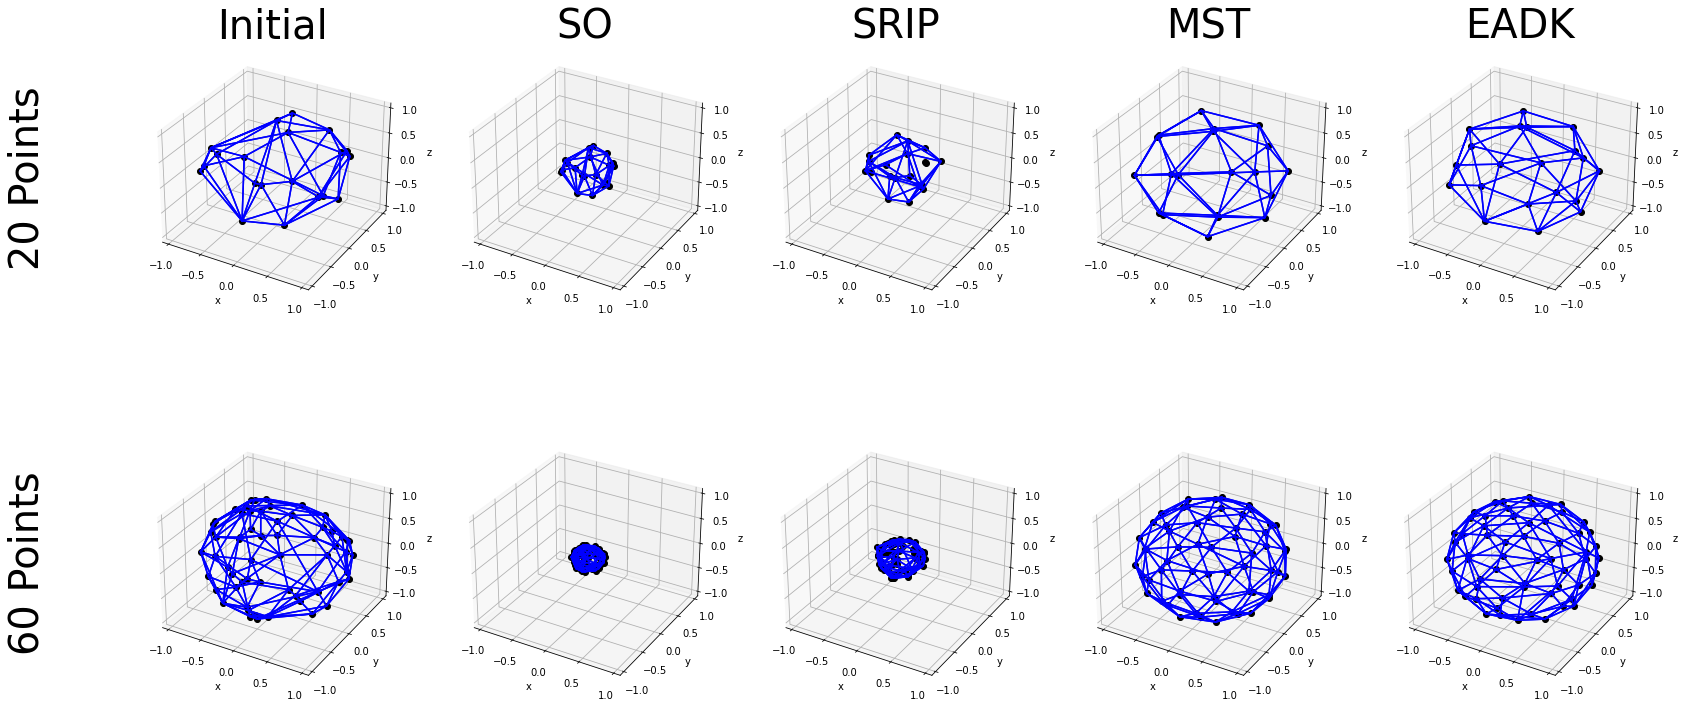

In [132]:
fig = plt.figure(figsize=(27, 13))

spec = gridspec.GridSpec(ncols=5, nrows=2)


pad = 5



ax = fig.add_subplot(spec[0], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
ax.set_title('Initial', size=40)
pts = W1_20.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
ax.annotate('20 Points', xy=(-80, -2), xytext=(-ax.zaxis.labelpad - pad, 0),
                xycoords=ax.zaxis.label, textcoords='offset points',
                size=40, ha='left', va='center', rotation=90)



ax = fig.add_subplot(spec[5], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
# ax.set_title('12 Points', size=40)
pts = W1_60.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
ax.annotate('60 Points', xy=(-80, -2), xytext=(-ax.zaxis.labelpad - pad, 0),
                xycoords=ax.zaxis.label, textcoords='offset points',
                size=40, ha='left', va='center', rotation=90)

# ####################

ax = fig.add_subplot(spec[1], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
ax.set_title('SO', size=40)
pts = W1_so_20.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
# ax.annotate('SO', xy=(-80, -2), xytext=(-ax.zaxis.labelpad - pad, 0),
#                 xycoords=ax.zaxis.label, textcoords='offset points',
#                 size=40, ha='left', va='center', rotation=90)



ax = fig.add_subplot(spec[6], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
pts = W1_so_60.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    
# ###################

ax = fig.add_subplot(spec[2], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
ax.set_title('SRIP', size=40)
pts = W1_srip_20.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
# ax.annotate('SRIP', xy=(-80, -2), xytext=(-ax.zaxis.labelpad - pad, 0),
#                 xycoords=ax.zaxis.label, textcoords='offset points',
#                 size=40, ha='left', va='center', rotation=90)



ax = fig.add_subplot(spec[7], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
pts = W1_srip_60.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))

# ##################


ax = fig.add_subplot(spec[3], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
ax.set_title('MST', size=40)
pts = W1_mst_20.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
# ax.annotate('MST', xy=(-80, -2), xytext=(-ax.zaxis.labelpad - pad, 0),
#                 xycoords=ax.zaxis.label, textcoords='offset points',
#                 size=40, ha='left', va='center', rotation=90)



ax = fig.add_subplot(spec[8], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
pts = W1_mst_60.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    
# #######################

ax = fig.add_subplot(spec[4], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
ax.set_title('EADK', size=40)
pts = W1_adk_20.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
# ax.annotate('EADK', xy=(-80, -2), xytext=(-ax.zaxis.labelpad - pad, 0),
#                 xycoords=ax.zaxis.label, textcoords='offset points',
#                 size=40, ha='left', va='center', rotation=90)



ax = fig.add_subplot(spec[9], projection='3d')
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.set_zlim(-1.05, 1.05)
pts = W1_adk_60.cpu().detach().numpy()
hull = ConvexHull(pts)
# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")
# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "b-")
# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
    
# fig.tight_layout()
plt.show()